# Mini Project 3  - IU 4.6 Machine Learning

<a id = 'content'><a/>
# Notebook Content Page

* [0.0 Function Creation](#section_0)
* [1.0 Data Overview](#section_1)
    * [1.1 Dataset Overview](#section_1.1)
    * [1.2 Exploring Duplicates](#section_1.2)
    * [1.3 Exploring Null Values](#section_1.3)
    * [1.4 Exploring Outliers for `UniqueSubs`,`DirectorAssistedCalls` and `Monthly Revenue`](#section_1.4)
    
* [2.0 EDA on Dataset](#section_2)
    * [2.1 Higher OverageMinutes have Higher Revenue?](#section_2.1)
    * [2.2 High number of active subscribers lead to low monthly revenue?](#section_2.2)
    * [2.3 Credit Rating on Churn Rate?](#section_2.3)
    * [2.4 Exploring Calls feature](#section_2.4)
    * [2.5 Exploring Subscription Info](#section_2.5)    
    * [2.6 Exploring Handset Features](#section_2.6)
    * [2.7a Customer Profile - Asset Features](#section_2.7a)
    * [2.7b Customer Profile - Personal Info](#section_2.7b)
    * [2.7c Customer Profile - Occupation and Income](#section_2.7c)
    * [2.8a Customer Interaction - Mail Related](#section_2.8a)
    * [2.8b Customer Interaction - Retention Related Features](#section_2.8b)
    * [2.9 Credit Card and Credit Ratings](#section_2.9)
    * [2.10 Higher Recurring Charges Churn more?](#section_2.10)    
    
* [3.0 Feature Engineering](#section_3)
    * [3.1 Dummfying Ordinal and Categorical Features](#section_3.1)
    * [3.2 Creating New features](#section_3.2)
* [4.0 Modelling with LR and RFC](#section_4)
    * [4.1 Baseline Model Without SMOTE](#section_4.2)        
    * [4.2 Preprocessing with SMOTE , Standard Scalar](#section_4.1)
    * [4.3 Modelling with Logistic Regression](#section_4.3)
    * [4.4 Modelling with Random Forest Classifier](#section_4.4)
    * [4.5 Result Comparison](#section_4.5)    
    * [4.6 Identifying Feature Importances](#section_4.6)
* [5.0 Generating Test Prediction](#section_5)    
    * [5.1 Predicting on Pre-split Test Data](#section_5.1)    
    * [5.2 Predicting on Seperate Hold Out Data (No labels)](#section_5.1)
* [6.0 What could be done next to improve model score?](#section_6)
* [7.0 Bonus Question](#section_7)

## Packages and setup

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix , plot_roc_curve , auc , roc_curve , roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 60)

In [2]:
plt.style.use('fivethirtyeight')
sns.set(style = 'white')
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
def EDA_subplot(nrows , ncols , feature_list , df , ylimit = None):

    plt.figure(figsize = (ncols*8 , nrows*9))
    for i in range(len(feature_list)):
        plt.subplot(nrows , ncols , i+1)
        
        # If numeric data feature , plot scatter
        if pd.api.types.is_numeric_dtype(df[feature_list[i]]):
        
            sns.kdeplot(data = df,
                        x = feature_list[i],
                        shade = True,
                        hue = 'Churn')
            plt.title(f'{feature_list[i]} vs Churn' , fontsize = 24)
            plt.xticks(rotation = 90 , fontsize = 20)
            plt.xlabel(xlabel = feature_list[i] , fontsize = 20)
            plt.ylabel(ylabel = 'Distribution' , fontsize = 20)
            plt.ylim(0 , ylimit)
        
        # If non - numeric data feature , plot boxplot
        else:
            sns.boxenplot(data = df,
                          x = feature_list[i],
                          y = 'MonthlyRevenue',
                          hue = 'Churn',
                          width = 0.5)
            plt.title(f'{feature_list[i]} vs Churn' , fontsize = 24)
            plt.xticks(rotation = 90 , fontsize = 20)
            plt.xlabel(xlabel = feature_list[i] , fontsize = 20)
            plt.ylabel(ylabel = 'MonthlyRevenue' , fontsize = 20)
            plt.ylim(0 , ylimit)

In [4]:
def eval_classification(y_true , y_pred , y_proba):

    from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score , auc , roc_curve , roc_auc_score

    # Define Scoring variables
    accuracy = accuracy_score(y_true , y_pred)
    precision = precision_score(y_true , y_pred)
    recall = recall_score(y_true , y_pred)
    f1_score = f1_score(y_true , y_pred)
    
    fpr , tpr , threshold = roc_curve(y_true , y_proba)
    auc_score = auc(fpr , tpr)
    
    gini_score = (2*auc_score) -1

    score_dict = {'Accuracy' : accuracy,
                  'Precision' : precision,
                  'Recall' : recall,
                  'F1 Score' : f1_score,
                  'AUC Score' : auc_score,
                  'Gini Score' : gini_score}

    return score_dict

<a id = 'section_1'><a/>
# 1.0 Data Overview
___
[(`back to top`)](#content)

In [5]:
#edit the file location of raw data set
df_cust = pd.read_csv('Dataset/Mini_project_3_Data.xls')

<a id = 'section_1.1'><a/>
### 1.1 Dataset Overview
___
[(back to top)](#content)

In [6]:
df_cust.head()

CustomerID Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0     3000002   Yes           24.00           219.0                  22.0   
1     3000010   Yes           16.99            10.0                  17.0   
2     3000014    No           38.00             8.0                  38.0   
3     3000022    No           82.28          1312.0                  75.0   
4     3000026   Yes           17.14             0.0                  17.0   

   DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
0                   0.25             0.0           0.0             -157.0   
1                   0.00             0.0           0.0               -4.0   
2                   0.00             0.0           0.0               -2.0   
3                   1.24             0.0           0.0              157.0   
4                   0.00             0.0           0.0                0.0   

   PercChangeRevenues  DroppedCalls  BlockedCalls  UnansweredCalls  \
0               -19.0           0.7           0.7              6.3   
1                 0.0           0.3           0.0              2.7   
2                 0.0           0.0           0.0              0.0   
3                 8.1          52.0           7.7             76.0   
4                -0.2           0.0           0.0              0.0   

   CustomerCareCalls  ThreewayCalls  ReceivedCalls  OutboundCalls  \
0                0.0            0.0           97.2            0.0   
1                0.0            0.0            0.0            0.0   
2                0.0            0.0            0.4            0.3   
3                4.3            1.3          200.3          370.3   
4                0.0            0.0            0.0            0.0   

   InboundCalls  PeakCallsInOut  OffPeakCallsInOut  DroppedBlockedCalls  \
0           0.0            58.0               24.0                  1.3   
1           0.0             5.0                1.0                  0.3   
2           0.0             1.3                3.7                  0.0   
3         147.0           555.7              303.7                 59.7   
4           0.0             0.0                0.0                  0.0   

   CallForwardingCalls  CallWaitingCalls  MonthsInService  UniqueSubs  \
0                  0.0               0.3               61           2   
1                  0.0               0.0               58           1   
2                  0.0               0.0               60           1   
3                  0.0              22.7               59           2   
4                  0.0               0.0               53           2   

   ActiveSubs ServiceArea  Handsets  HandsetModels  CurrentEquipmentDays  \
0           1   SEAPOR503       2.0            2.0                 361.0   
1           1   PITHOM412       2.0            1.0                1504.0   
2           1   MILMIL414       1.0            1.0                1812.0   
3           2   PITHOM412       9.0            4.0                 458.0   
4           2   OKCTUL918       4.0            3.0                 852.0   

   AgeHH1  AgeHH2 ChildrenInHH HandsetRefurbished HandsetWebCapable  \
0    62.0     0.0           No                 No               Yes   
1    40.0    42.0          Yes                 No                No   
2    26.0    26.0          Yes                 No                No   
3    30.0     0.0           No                 No               Yes   
4    46.0    54.0           No                 No                No   

  TruckOwner RVOwner Homeownership BuysViaMailOrder RespondsToMailOffers  \
0         No      No         Known              Yes                  Yes   
1         No      No         Known              Yes                  Yes   
2         No      No       Unknown               No                   No   
3         No      No         Known              Yes                  Yes   
4         No      No         Known              Yes                  Yes   

  OptOutMa

In [7]:
# Type your code here to explore and understand the data better

print('DF Shape shape: ' , df_cust.shape)
print('DF ndim: ' , df_cust.ndim)
print('DF size: ' , df_cust.size)

DF Shape shape:  (51047, 58)
DF ndim:  2
DF size:  2960726


In [8]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [9]:
# Observed to have alot of outliers for numerical features
df_cust.describe()

CustomerID  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
count  5.104700e+04    50891.000000    50891.000000          50891.000000   
mean   3.201957e+06       58.834492      525.653416             46.830088   
std    1.169056e+05       44.507336      529.871063             23.848871   
min    3.000002e+06       -6.170000        0.000000            -11.000000   
25%    3.100632e+06       33.610000      158.000000             30.000000   
50%    3.201534e+06       48.460000      366.000000             45.000000   
75%    3.305376e+06       71.065000      723.000000             60.000000   
max    3.399994e+06     1223.380000     7359.000000            400.000000   

       DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
count           50891.000000    50891.000000  50891.000000       50680.000000   
mean                0.895229       40.027785      1.236244         -11.547908   
std                 2.228546       96.588076      9.818294         257.514772   
min                 0.000000        0.000000      0.000000       -3875.000000   
25%                 0.000000        0.000000      0.000000         -83.000000   
50%                 0.250000        3.000000      0.000000          -5.000000   
75%                 0.990000       41.000000      0.300000          66.000000   
max               159.390000     4321.000000   1112.400000        5192.000000   

       PercChangeRevenues  DroppedCalls  BlockedCalls  UnansweredCalls  \
count        50680.000000  51047.000000  51047.000000     51047.000000   
mean            -1.191985      6.011489      4.085672        28.288981   
std             39.574915      9.043955     10.946905        38.876194   
min          -1107.700000      0.000000      0.000000         0.000000   
25%             -7.100000      0.700000      0.000000         5.300000   
50%             -0.300000      3.000000      1.000000        16.300000   
75%              1.600000      7.700000      3.700000        36.300000   
max           2483.500000    221.700000    384.300000       848.700000   

       CustomerCareCalls  ThreewayCalls  ReceivedCalls  OutboundCalls  \
count       51047.000000   51047.000000   51047.000000   51047.000000   
mean            1.868999       0.298838     114.800121      25.377715   
std             5.096138       1.168277     166.485896      35.209147   
min             0.000000       0.000000       0.000000       0.000000   
25%             0.000000       0.000000       8.300000       3.300000   
50%             0.000000       0.000000      52.800000      13.700000   
75%             1.700000       0.300000     153.500000      34.000000   
max           327.300000      66.000000    2692.400000     644.300000   

       InboundCalls  PeakCallsInOut  OffPeakCallsInOut  DroppedBlockedCalls  \
count  51047.000000    51047.000000       51047.000000         51047.000000   
mean       8.178104       90.549515          67.650790            10.158003   
std       16.665878      104.947470          92.752699            15.555284   
min        0.000000        0.000000           0.000000             0.000000   
25%        0.000000       23.000000          11.000000             1.700000   
50%        2.000000       62.000000          35.700000             5.300000   
75%        9.300000      121.300000          88.700000            12.300000   
max      519.300000     2090.700000        1474.700000           411.700000   

       CallForwardingCalls  CallWaitingCalls  MonthsInService    UniqueSubs  \
count         51047.000000      51047.000000     51047.000000  51047.000000   
mean              0.012277          1.840504        18.756264      1.532157   
std               0.594168          5.585129         9.800138      1.223384   
min               0.000000          0.000000         6.000000      1.000000   
25%               0.000000          0.000000        11.000000      1.000000   
50%               0.000000          0.300000        16.000000      1.00000

<a id = 'section_1.2'><a/> 
### 1.2 Exploring Duplicates [(`back to top`)](#content)
___   

In [10]:
# Any Duplicated Customer ID?
df_cust['CustomerID'].duplicated().sum()

0

<a id = 'section_1.3'><a/>
### 1.3 Exploring Null Value [(`back to top`)](#content)
___
    
* 1.3.1 - Exploring Null Values in Service Area
* 1.3.2 - How many columns has missing values percentage > 5%
* 1.3.3 - Dropping Null Value for ServiceArea
* 1.3.4 - Impute Numeric Feature with Median
* 1.3.5 - Checking Null After Data Processing
* 1.3.6 - Unknown Data in HandSetPrice Column    

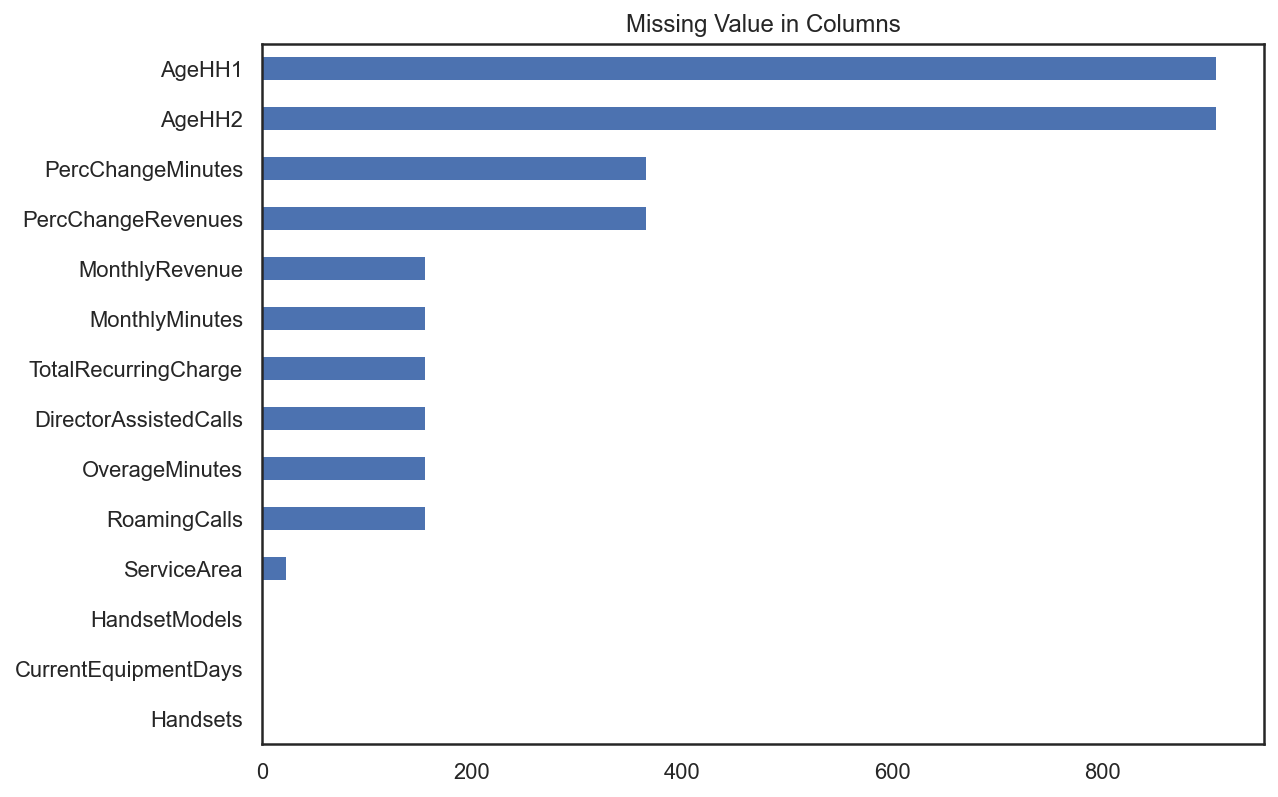

In [11]:
df_cust.isnull().sum().sort_values(ascending = True)[-14:].plot(kind = 'barh' , figsize = (8,6))
plt.title('Missing Value in Columns');

#### 1.3.1. Exploring Null Values in Service Area
___

In [12]:
# Checking the Unique Value for ServiceArea
# For this dataset , we could have tried to pre-group them base on certain characteristic such as PrizsmCode and impute accordinly. 
# However since dataset is small at 24 counts (0.04%) and the number of unique Service Area is large at 748 , we will just drop them.
print('No. of Unique Service Area : ' , len(df_cust['ServiceArea'].unique()))
print('No. of Rows with NA Service Area : ' , len(df_cust[df_cust['ServiceArea'].isna()]))
print('Percentage of NA Service Area to Total DF : ' , len(df_cust[df_cust['ServiceArea'].isna()]) / len(df_cust))
print('-------------------------')

df_cust[df_cust['ServiceArea'].isna()].head()[['CustomerID' , 'ServiceArea' , 'PrizmCode']]


No. of Unique Service Area :  748
No. of Rows with NA Service Area :  24
Percentage of NA Service Area to Total DF :  0.0004701549552373303
-------------------------


CustomerID ServiceArea PrizmCode
2025      3015822         NaN     Other
2866      3022406         NaN     Other
6098      3047802         NaN     Rural
9326      3073410         NaN      Town
10460     3082514         NaN     Other

#### 1.3.2 How many columns has missing values percentage > 5%
___

In [13]:
df_null = pd.DataFrame(df_cust.isnull().sum())
df_null.rename(columns = {0 : "Null Count"} , inplace = True)

In [14]:
df_null['Percent Null'] = (df_null['Null Count'] / len(df_cust) *100)
df_null.sort_values(by = 'Percent Null' , ascending=False)[:14]

Null Count  Percent Null
AgeHH2                        909      1.780712
AgeHH1                        909      1.780712
PercChangeMinutes             367      0.718945
PercChangeRevenues            367      0.718945
MonthlyRevenue                156      0.305601
MonthlyMinutes                156      0.305601
TotalRecurringCharge          156      0.305601
DirectorAssistedCalls         156      0.305601
OverageMinutes                156      0.305601
RoamingCalls                  156      0.305601
ServiceArea                    24      0.047015
CurrentEquipmentDays            1      0.001959
Handsets                        1      0.001959
HandsetModels                   1      0.001959

#### 1.3.3 Dropping Null Value for ServiceArea
___
* 24 Data row is NaN
* This is only 0.04% of dataset
* Too many unique value to consider (748 unique value)

In [15]:
print('DF Shape before dropping NaN Service Area : ' , df_cust.shape)

df_cust = df_cust[~df_cust['ServiceArea'].isna()]

print('DF Shape After dropping NaN Service Area : ' , df_cust.shape)

DF Shape before dropping NaN Service Area :  (51047, 58)
DF Shape After dropping NaN Service Area :  (51023, 58)


#### 1.3.4 Impute Numeric Feature with Median
___

In [16]:
for col , data in df_cust.items():
    if pd.api.types.is_numeric_dtype(data):
        # Fill Nan Value in Numeric columns with Median Values
        df_cust[col].fillna(value = df_cust[col].median() , inplace = True)

#### 1.3.5 Checking Null After Data Processing
___

In [17]:
df_cust.isnull().sum().sum()

0

#### 1.3.6 Unknown Data in HandsetPrice and Marital Status
___

* [(Refer to Section 2.6 for the observation and data processing for HandsetPrice)](#section_2.6)
* [(Refer to Section 2.7b for the observation and data processing for MaritalStatus)](#section_2.7b)

<a id = 'section_1.4'><a/>
### 1.4 Exploring Outliers for `UniqueSubs` , `DirectorAssistedCalls` and `Monthly Revenue`
___
[(back to top)](#content)    

#### 1.4.1 Zero Monthly Revenue
___

In [18]:
zero_revenue = df_cust.loc[df_cust['MonthlyRevenue']==0]
print(f'No. of Rows with 0 Revenue : {len(zero_revenue)}')
print(f'DF Shape before remove: {df_cust.shape}')

df_cust = df_cust.loc[df_cust['MonthlyRevenue']!=0]

print(f'DF Shape after remove: {df_cust.shape}')

No. of Rows with 0 Revenue : 6
DF Shape before remove: (51023, 58)
DF Shape after remove: (51017, 58)


#### 1.4.2 UniqueSubs and DirectorAssistedCalls
___

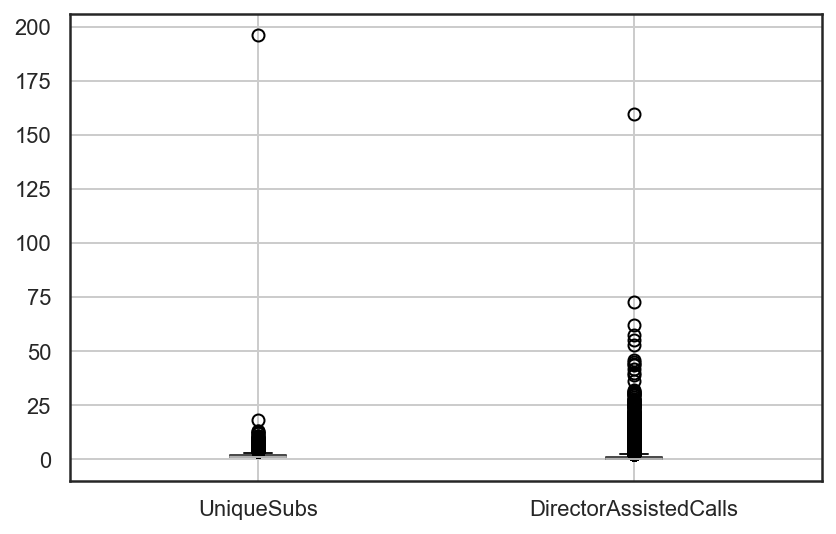

In [19]:
#plot box plot using pandas for columns "UniqueSubs" and "DirectorAssistedCalls"
cols=['UniqueSubs' , 'DirectorAssistedCalls']
df_cust.boxplot(column=cols);

In [20]:
# Getting the value at the 99th Percentile
p_99 = np.quantile(a = df_cust["UniqueSubs"],
                   q = 0.99)
print('Value at 99th Percentile:' , p_99)

Value at 99th Percentile: 5.0


In [21]:
# There are around 234 rows 
df_cust.loc[df_cust['UniqueSubs'] > p_99][['UniqueSubs']].sort_values(by = 'UniqueSubs' , ascending=False)[:10]
print(f' No. of Rows above the 99th percentile value: {len(df_cust.loc[df_cust["UniqueSubs"] > p_99])}')

UniqueSubs
23267         196
19802          18
16602          13
38835          13
5489           12
48358          12
43004          12
7001           11
29504          11
41602          11

 No. of Rows above the 99th percentile value: 234


In [22]:
print(f'No. of Rows above the 99th percentile value: {len(df_cust.loc[df_cust["UniqueSubs"] > p_99])}')
print(f'DF Shape before remove: {df_cust.shape}')

df_cust = df_cust.loc[df_cust["UniqueSubs"] <= p_99]

print(f'DF Shape after remove: {df_cust.shape}')

No. of Rows above the 99th percentile value: 234
DF Shape before remove: (51017, 58)
DF Shape after remove: (50783, 58)


In [23]:
p_99_DAC = np.quantile(a = df_cust["DirectorAssistedCalls"],
                       q = 0.99)

print('Value at 99th Percentile for DAC:' , p_99_DAC)

Value at 99th Percentile for DAC: 9.65


In [24]:
# There are around 490 rows. This is still less than 1% of the dataset. 
df_cust.loc[df_cust['DirectorAssistedCalls'] > p_99_DAC][['DirectorAssistedCalls']].sort_values(by = 'DirectorAssistedCalls' , ascending=False)[:10]
print(f' No. of Rows above the 99th percentile value: {len(df_cust.loc[df_cust["DirectorAssistedCalls"] > p_99_DAC])}')

DirectorAssistedCalls
5970                  159.39
31953                  72.77
44745                  62.12
19484                  57.67
161                    55.19
4806                   52.97
18269                  45.79
2772                   45.05
83                     44.30
41425                  43.56

 No. of Rows above the 99th percentile value: 483


In [25]:
print(f'No. of Rows above the 99th percentile value: {len(df_cust.loc[df_cust["DirectorAssistedCalls"] > p_99_DAC])}')
print(f'DF Shape before remove: {df_cust.shape}')

df_cust = df_cust.loc[df_cust["DirectorAssistedCalls"] <= p_99_DAC]

print(f'DF Shape after remove: {df_cust.shape}')

No. of Rows above the 99th percentile value: 483
DF Shape before remove: (50783, 58)
DF Shape after remove: (50300, 58)


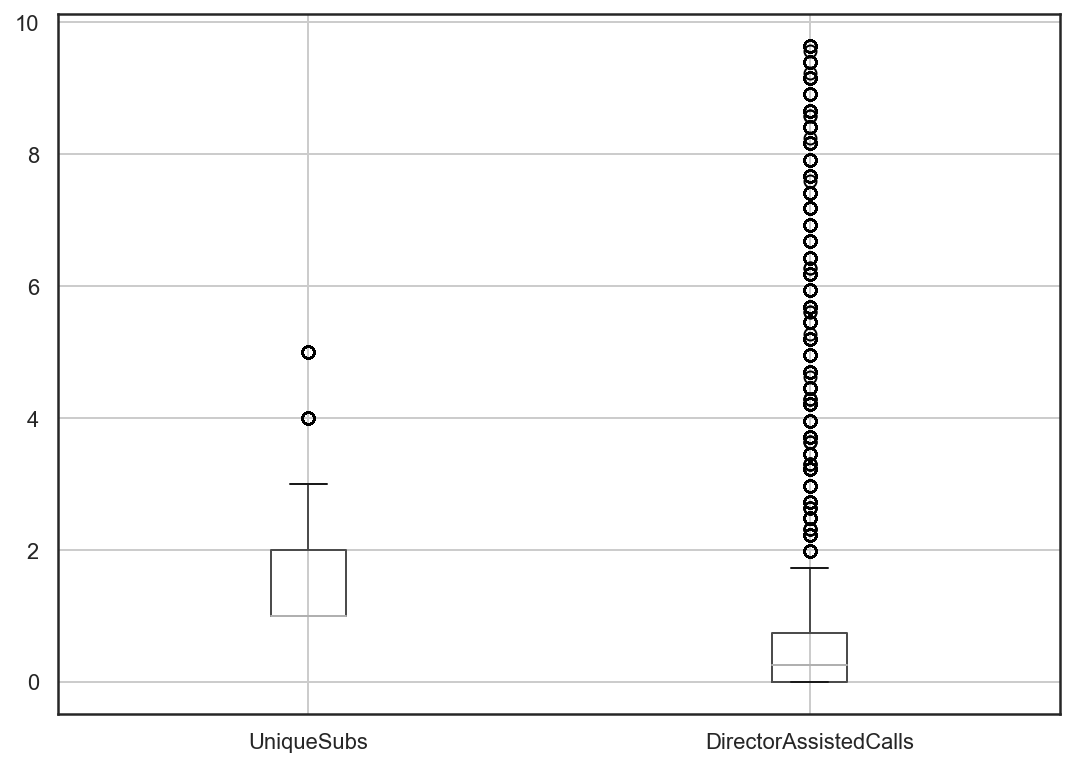

In [26]:
cols=['UniqueSubs' , 'DirectorAssistedCalls']
df_cust.boxplot(column=cols , figsize = (8,6));

<a id = 'section_2'><a/>
# 2.0. Exploratory analysis to analyze customer churn
___
[(`back to top`)](#content)

<a id = 'section_2.1'><a/>
### 2.1 High overage minutes have high revenue? [(`back to top`)](#content)
___
<mark>__Result:__ 
 * Graph 1 :Before removing outliers , the results are very clustered at region where OverageMinutes < 500.
 * Graph 2 :After removing minor outliers where OverageMinutes > 3000 and MonthlyRevenue >1000 , Some linear relation could be observed.
 * Graph 3 : It could be observed clearly that the higher  the monthly revenue , the higher then OverageMinutes.

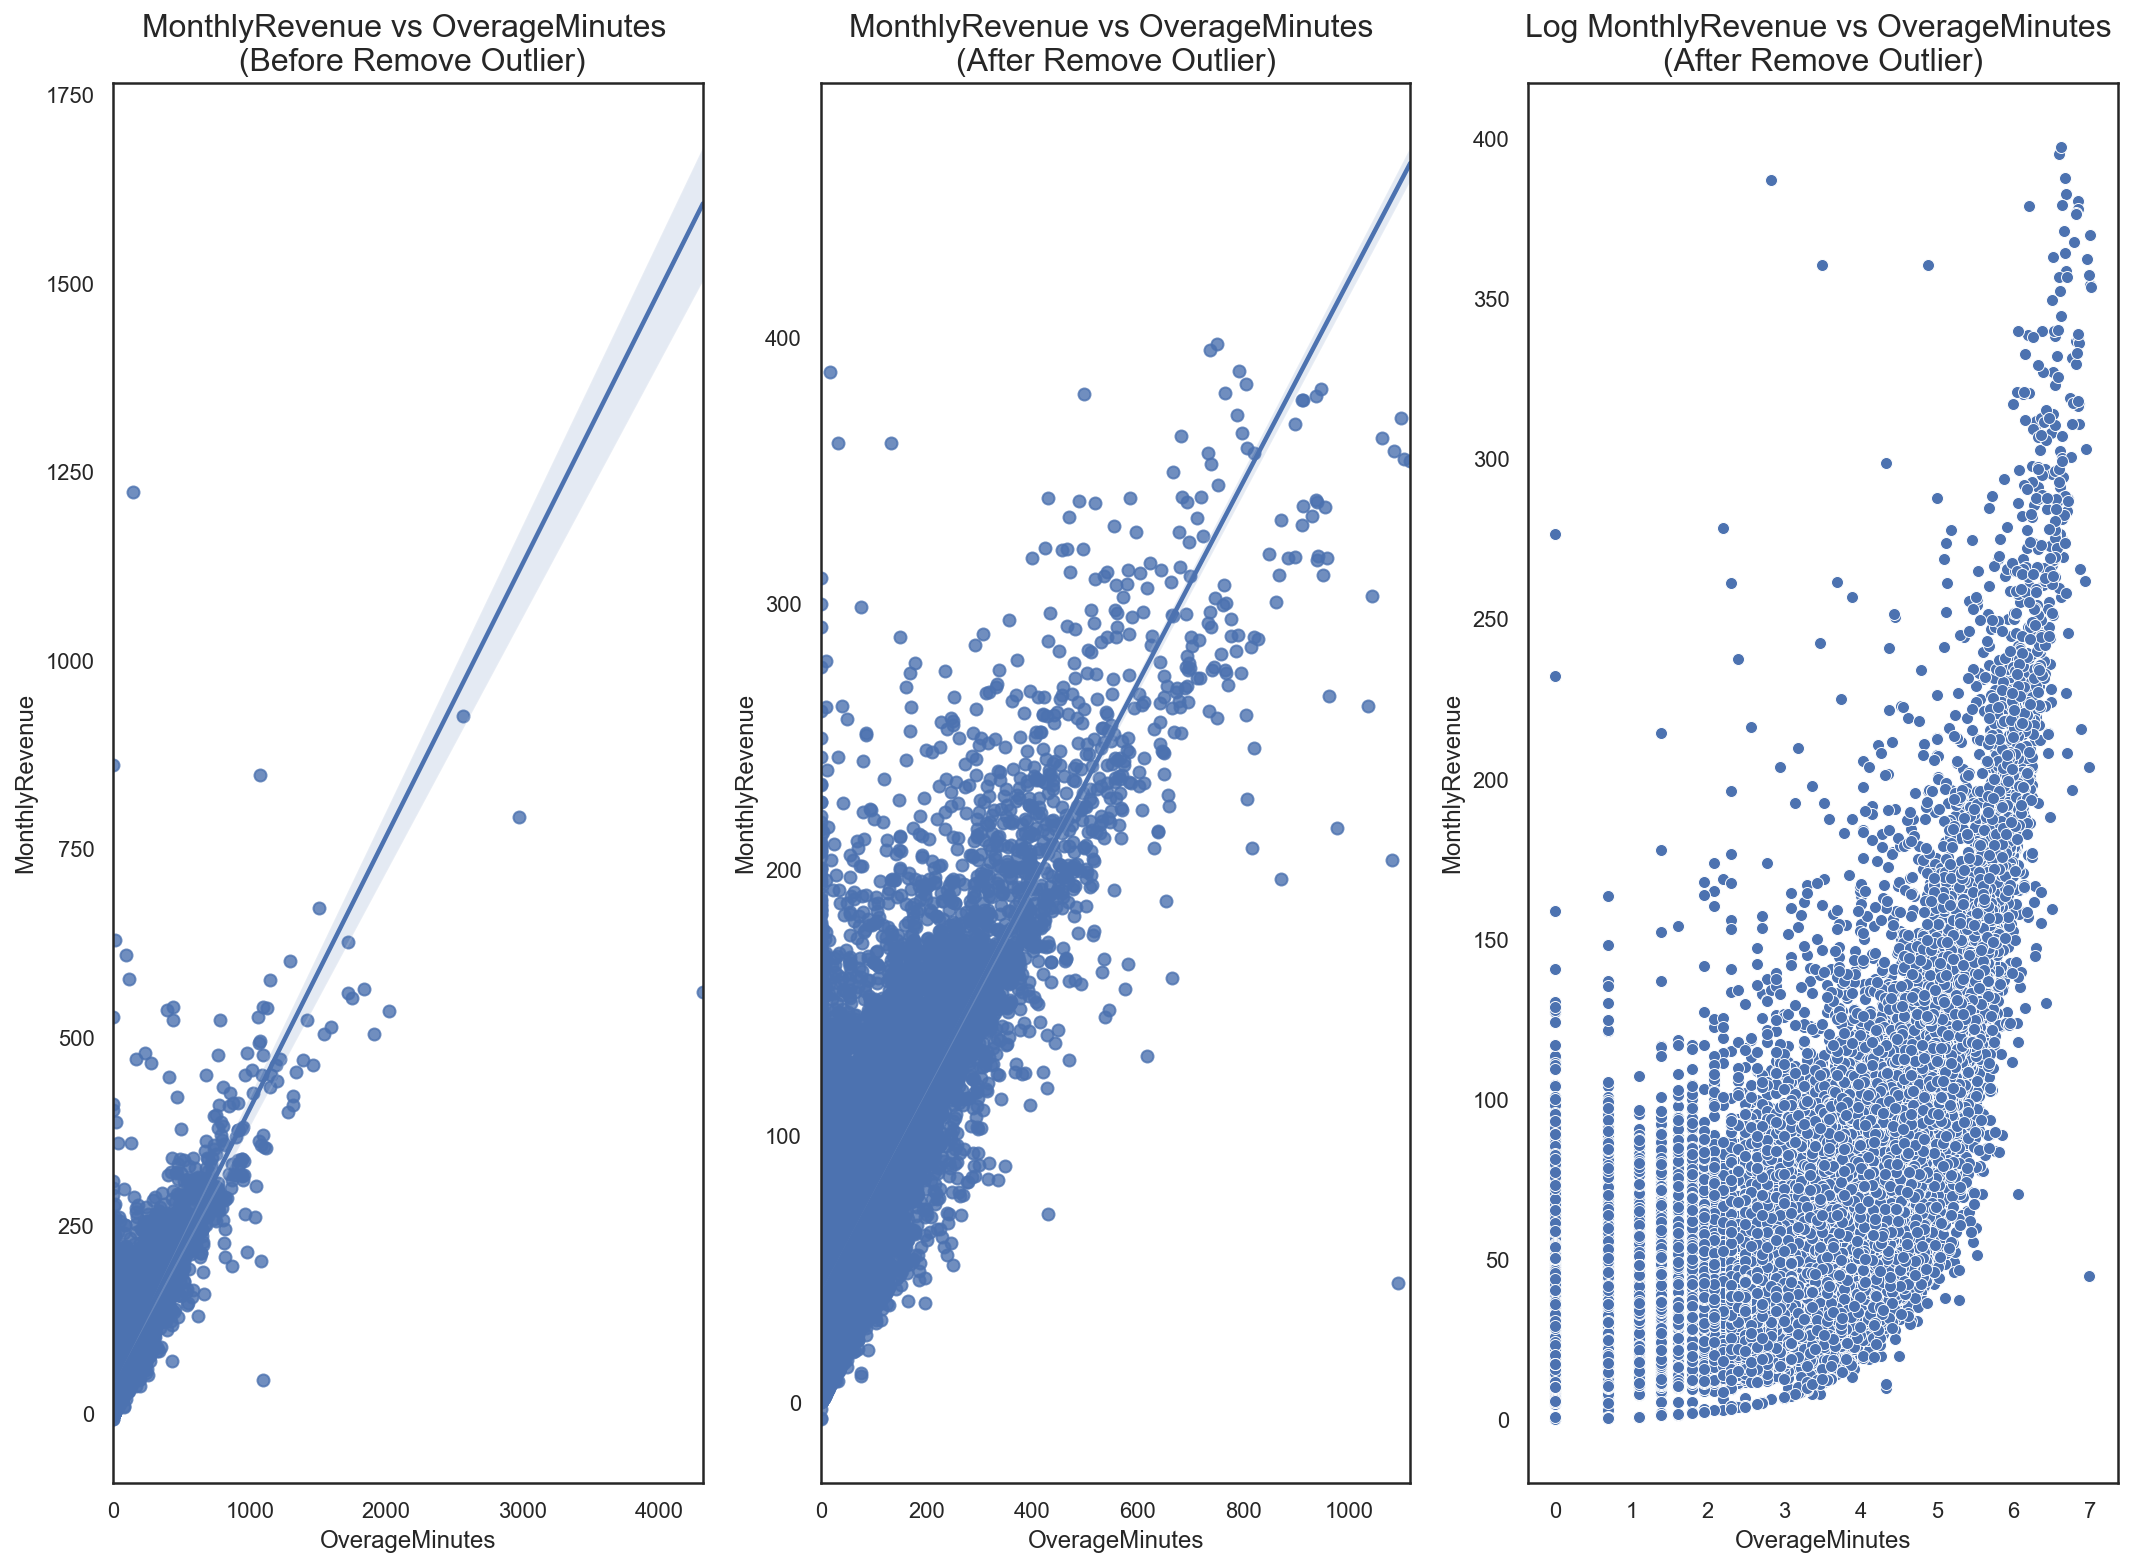

In [27]:
#use scatter plot to find the correlation between monthly revenue and overage minutes
plt.figure(figsize = (16,12))

plt.subplot(1,3,1)
sns.regplot(x = 'OverageMinutes', y = 'MonthlyRevenue', data = df_cust )
plt.title('MonthlyRevenue vs OverageMinutes \n (Before Remove Outlier)' , fontsize = 16)

df_cust = df_cust[df_cust['MonthlyRevenue'] < 400]
df_cust = df_cust[df_cust['OverageMinutes'] < 3000]

plt.subplot(1,3,2)
sns.regplot(x = 'OverageMinutes', y = 'MonthlyRevenue', data = df_cust )
plt.title('MonthlyRevenue vs OverageMinutes \n(After Remove Outlier)' , fontsize = 16);

plt.subplot(1,3,3)
sns.scatterplot(x = np.log(df_cust.OverageMinutes), y = 'MonthlyRevenue', data = df_cust )
plt.title('Log MonthlyRevenue vs OverageMinutes \n(After Remove Outlier)' , fontsize = 16);

<a id = 'section_2.2'><a/>
### 2.2 High number of active subscribers lead to low monthly revenue? [(`back to top`)](#content)
___   
<mark>__Result:__
    
* `Average`Revenue Value at 0 active subscribers is the highest
* As active subscribers increases , the `Average` Monthly Revenue decreases.
* Although group with 5 active subs have higher monthly revenue , their population size is only 0.19% and might not be representative.
* **Therefore higher the active subs , lower the monthly revenue.**
* One of the reason could be probably as the number of family subscribers increases , the bundle discount might take into effect.    

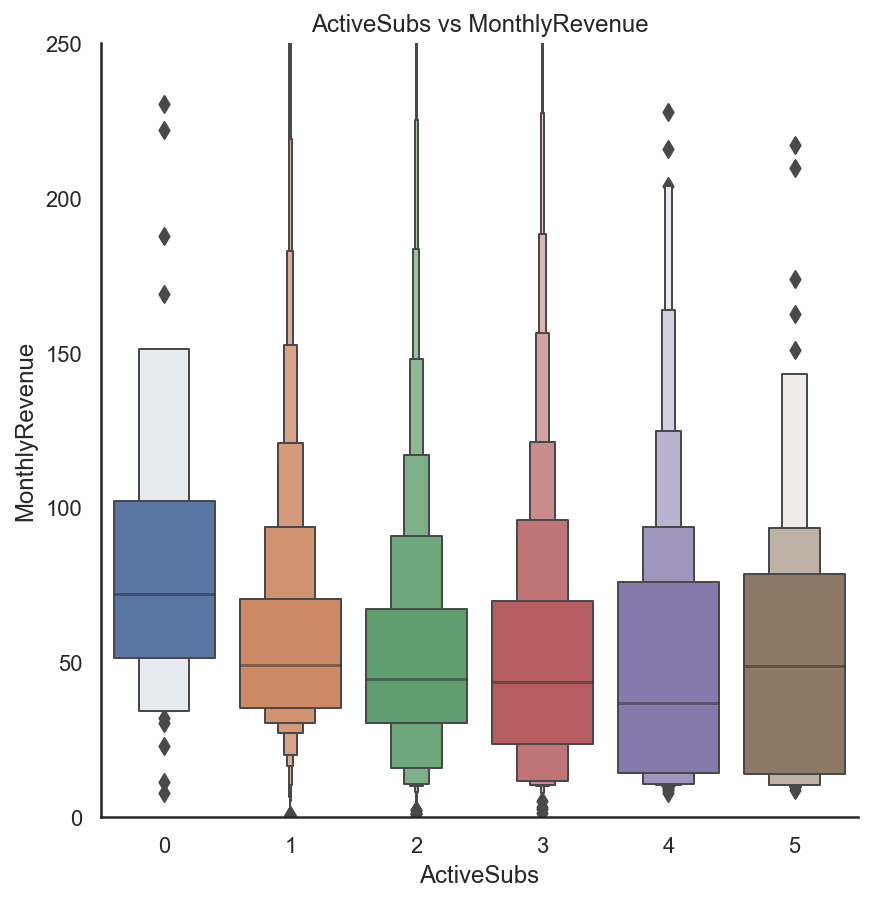

In [28]:
sns.catplot(x = 'ActiveSubs', y = 'MonthlyRevenue', data = df_cust , height = 6 , kind = 'boxen')
plt.title('ActiveSubs vs MonthlyRevenue')
plt.ylim(0,250);

<a id = 'section_2.3'><a/>
### 2.3 Credit Rating on Churn Rate? [(`back to top`)](#content)
___
<mark>__Result:__
    
No clear trendline. Credit rating does not seem to be a factor in predicting customer churn    

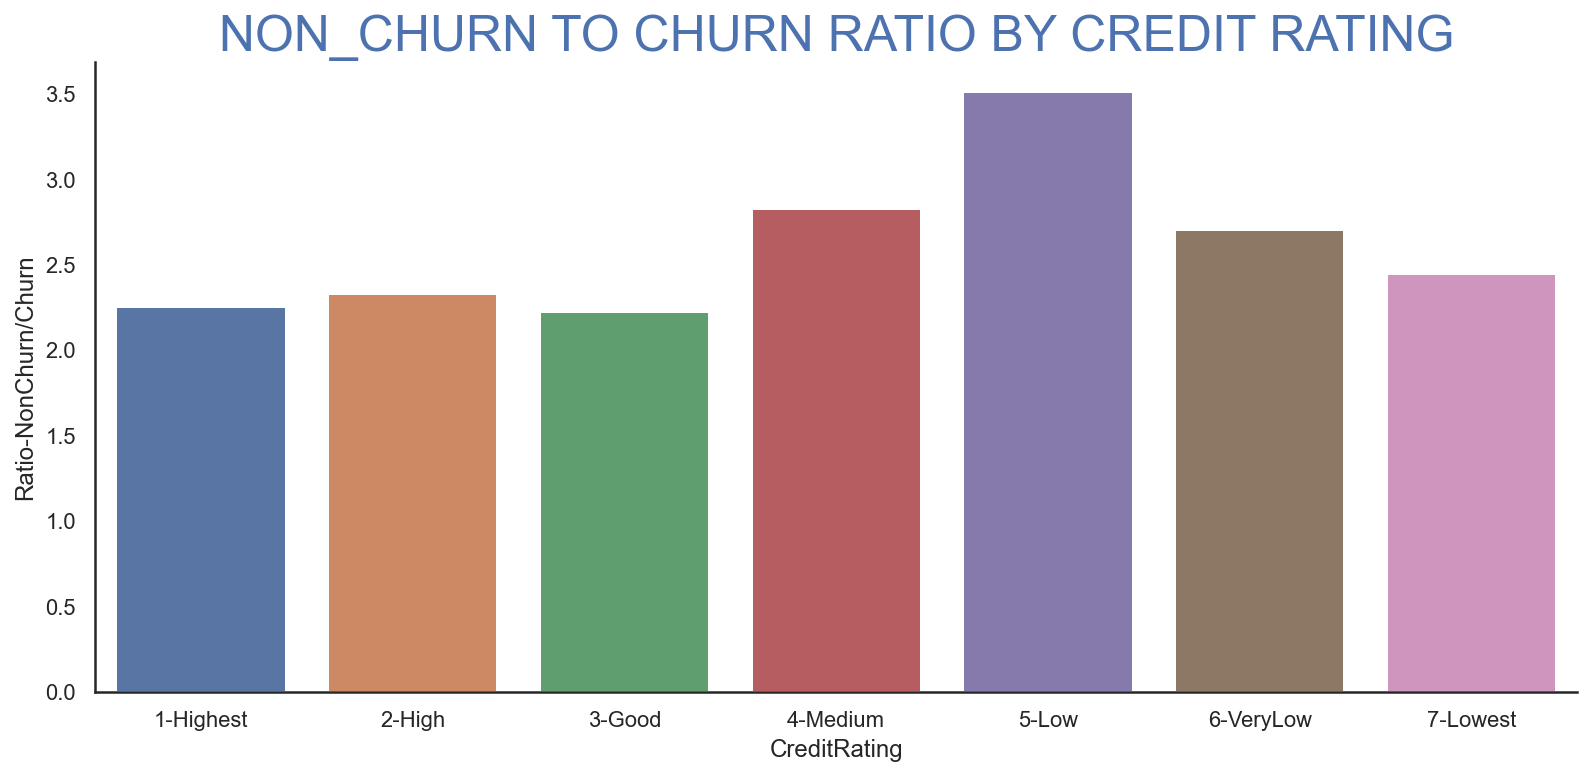

In [29]:
# create new df_temp by grouping cust_df by CreditRating and Churn. The new column 'Count' counts churners
# and non-churner in each CreditRating catergory
temp_df=df_cust.groupby(["CreditRating", "Churn"])["CustomerID"].count().reset_index(name="Count")

# within each Credit Rating Category, get the ratio of non-churners to churners. since they are in alertnate rows,
# just divide each even row with the next odd row
alternate_rows=range(14)[::2]
Ratio=[]
for i in alternate_rows:
    Ratio.append((temp_df.loc[i,"Count"])/(temp_df.loc[i+1,"Count"]))
    
# get unique values for CreditRating column
CRvalues=temp_df.CreditRating.unique()

# creat a new dataframe by combining Ratio and CRValues lists
new_df = pd.DataFrame(np.column_stack([CRvalues, Ratio]),columns=['CreditRating','Ratio-NonChurn/Churn'])

# plot CreditRating vs Ratio to see if there's any pattern or trend
g=sns.catplot(data=new_df, kind="bar",x="CreditRating", y='Ratio-NonChurn/Churn',aspect=2.2)
g.ax.set_title('NON_CHURN TO CHURN RATIO BY CREDIT RATING', color='C20',fontsize="25");

#new_df
#temp_df
#CRvalues

In [30]:
#Contingency Table Calculations
one_y = (len(df_cust[(df_cust['CreditRating'] == '1-Highest') & (df_cust['Churn'] == 'Yes')]))
one_n = (len(df_cust[(df_cust['CreditRating'] == '1-Highest') & (df_cust['Churn'] == 'No')]))
two_y = (len(df_cust[(df_cust['CreditRating'] == '2-High') & (df_cust['Churn'] == 'Yes')]))
two_n = (len(df_cust[(df_cust['CreditRating'] == '2-High') & (df_cust['Churn'] == 'No')]))
three_y = (len(df_cust[(df_cust['CreditRating'] == '3-Good') & (df_cust['Churn'] == 'Yes')]))
three_n = (len(df_cust[(df_cust['CreditRating'] == '3-Good') & (df_cust['Churn'] == 'No')]))
four_y = (len(df_cust[(df_cust['CreditRating'] == '4-Medium') & (df_cust['Churn'] == 'Yes')]))
four_n = (len(df_cust[(df_cust['CreditRating'] == '4-Medium') & (df_cust['Churn'] == 'No')]))
five_y = (len(df_cust[(df_cust['CreditRating'] == '5-Low') & (df_cust['Churn'] == 'Yes')]))
five_n = (len(df_cust[(df_cust['CreditRating'] == '5-Low') & (df_cust['Churn'] == 'No')]))
six_y = (len(df_cust[(df_cust['CreditRating'] == '6-VeryLow') & (df_cust['Churn'] == 'Yes')]))
six_n = (len(df_cust[(df_cust['CreditRating'] == '6-VeryLow') & (df_cust['Churn'] == 'No')]))
seven_y = (len(df_cust[(df_cust['CreditRating'] == '7-Lowest') & (df_cust['Churn'] == 'Yes')]))
seven_n = (len(df_cust[(df_cust['CreditRating'] == '7-Lowest') & (df_cust['Churn'] == 'No')]))
total_y = one_y + two_y + three_y + four_y + five_y + six_y + seven_y
total_n = one_n + two_n + three_n + four_n + five_n + six_n + seven_n
total_cust = one_y + two_y + three_y + four_y + five_y + six_y + seven_y + one_n + two_n + three_n + four_n + five_n + six_n + seven_n

#Install prettytable 
! pip install prettytable
from prettytable import PrettyTable 
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(['', 'Customers who churned', 'Customers who stayed', 'Total']) 
  
# Add rows 
myTable.add_row(['\n Credit Score 1 \n (Highest) \n', 
                 '\n ' + str(one_y) + '\n  \n',  
                 '\n ' + str(one_n) + '\n  \n',  
                 '\n ' + str(one_y + one_n) + '\n  \n']) 

myTable.add_row(['\n Credit Score 2 \n (High) \n', 
                 '\n ' + str(two_y) + '\n  \n',  
                 '\n ' + str(two_n) + '\n  \n',  
                 '\n ' + str(two_y + two_n) + ' \n  \n']) 

myTable.add_row(['\n Credit Score 3 \n (Good) \n', 
                 '\n ' + str(three_y) + '\n  \n',  
                 '\n ' + str(three_n) + '\n  \n',  
                 '\n ' + str(three_y + three_n) + '\n  \n']) 

myTable.add_row(['\n Credit Score 4 \n (Medium) \n', 
                 '\n ' + str(four_y) + '\n  \n',  
                 '\n ' + str(four_n) + '\n  \n',  
                 '\n ' + str(four_y + four_n) + '\n  \n']) 

myTable.add_row(['\n Credit Score 5 \n (Low) \n', 
                 '\n ' + str(five_y) + '\n  \n',  
                 '\n ' + str(five_n) + '\n  \n',  
                 '\n ' + str(five_y + five_n) + '\n  \n']) 

myTable.add_row(['\n Credit Score 6 \n (Very Low) \n', 
                 '\n ' + str(six_y) + '\n  \n',  
                 '\n ' + str(six_n) + '\n  \n',  
                 '\n ' + str(six_y + six_n) + '\n  \n']) 

myTable.add_row(['\n Credit Score 7 \n (Lowest) \n', 
                 '\n ' + str(seven_y) + '\n  \n',  
                 '\n ' + str(seven_n) + '\n  \n',  
                 '\n ' + str(seven_y + seven_n) + '\n  \n']) 

myTable.add_row(['\n Total \n\n', 
                 '\n ' + str(total_y) + '\n  \n',  
                 '\n ' + str(total_n) + '\n  \n',  
                 '\n ' + str(total_cust) + ' \n  \n']) 
  
print('\n\033[1mContingency Table - Churn & Credit Rating\033[0m\n') 
print(myTable)

from scipy.stats import chi2_contingency
from scipy.stats import chi2

print('\n\n\033[1mChi-Square Test Results\033[0m\n')

data_credit_churn_chi = [[one_y, two_y, three_y, four_y, five_y, six_y, seven_y],
                        [one_n, two_n, three_n, four_n, five_n, six_n, seven_n]]


stat, p, dof, expected = chi2_contingency(data_credit_churn_chi)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('Test Statistic\n' +
      'probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('X^2 > critical value, Categorial Variables are Dependent (reject H0)\n')
else:
    print('X^2 < critical value, Categorial Variables are Independent (fail to reject H0)\n')
# interpret p-value
alpha = 1.0 - prob
print('p-value\n' +
      'significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('p-value < 0.05, Categorial Variables are Dependent (reject H0)\n')
else:
    print('p-value > 0.05, Categorial Variables are Independent (fail to reject H0)\n')


Contingency Table - Churn & Credit Rating

+------------------+-----------------------+----------------------+---------+
|                  | Customers who churned | Customers who stayed |  Total  |
+------------------+-----------------------+----------------------+---------+
|                  |                       |                      |         |
|  Credit Score 1  |          2566         |         5771         |   8337  |
|    (Highest)     |                       |                      |         |
|                  |                       |                      |         |
|                  |                       |                      |         |
|  Credit Score 2  |          5656         |         13160        |  18816  |
|      (High)      |                       |                      |         |
|                  |                       |                      |         |
|                  |                       |                      |         |
|  Credit Score 3  |

<a id = 'section_2.4'><a/>
### 2.4 Exploring Calls feature [(`back to top`)](#content)
___   

* Total of 18 features related to Calls.
* General observation is that individual features does not seem to exhibit any close relation to churn rate. 
* Alot of Outliers observed for these features.    

| Feature | Description | Unit |
|---|---|---|
| MonthlyMinutes | Monthly minutes | Minutes |
| DirectorAssistedCalls | Automated call<br>(directory assisted calls) | Minutes |
| OverageMinutes | Extra minutes above<br>the postpaid allocation | Minutes |
| RoamingCalls | Minutes on calls<br>while roaming | Minutes |
| PercChangeMinutes | Percentage change in minutes<br>from previous month | Percent |
| DroppedCalls | Dropped calls in minutes | Minutes |
| BlockedCalls | Blocked calls in minutes | Minutes |
| UnansweredCalls | Unanswered calls in minutes | Minutes |
| CustomerCareCalls | Customer care call duration<br>in minutes | Minutes |
| ThreewayCalls | Minutes spend on<br>Conference calls | Minutes |
| ReceivedCalls | Total received calls in minutes | Minutes |
| OutboundCalls | Marketing calls received from<br>customer service in minutes | Minutes |
| InboundCalls | Total duration in minutes of calls<br>made to customer service | Minutes |
| PeakCallsInOut | Incoming/outgoing calls<br>during peak time | Minutes |
| OffPeakCallsInOut | Incoming/outgoing calls<br>during off peak time | Minutes |
| DroppedBlockedCalls | Summation of dropped<br>and blocked | Minutes |
| CallForwardingCalls | Minutes in call forwarding | Minutes |
| CallWaitingCalls | Minutes spend on hold<br>during call | Minutes |

 Features in this list : ['MonthlyMinutes', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls']


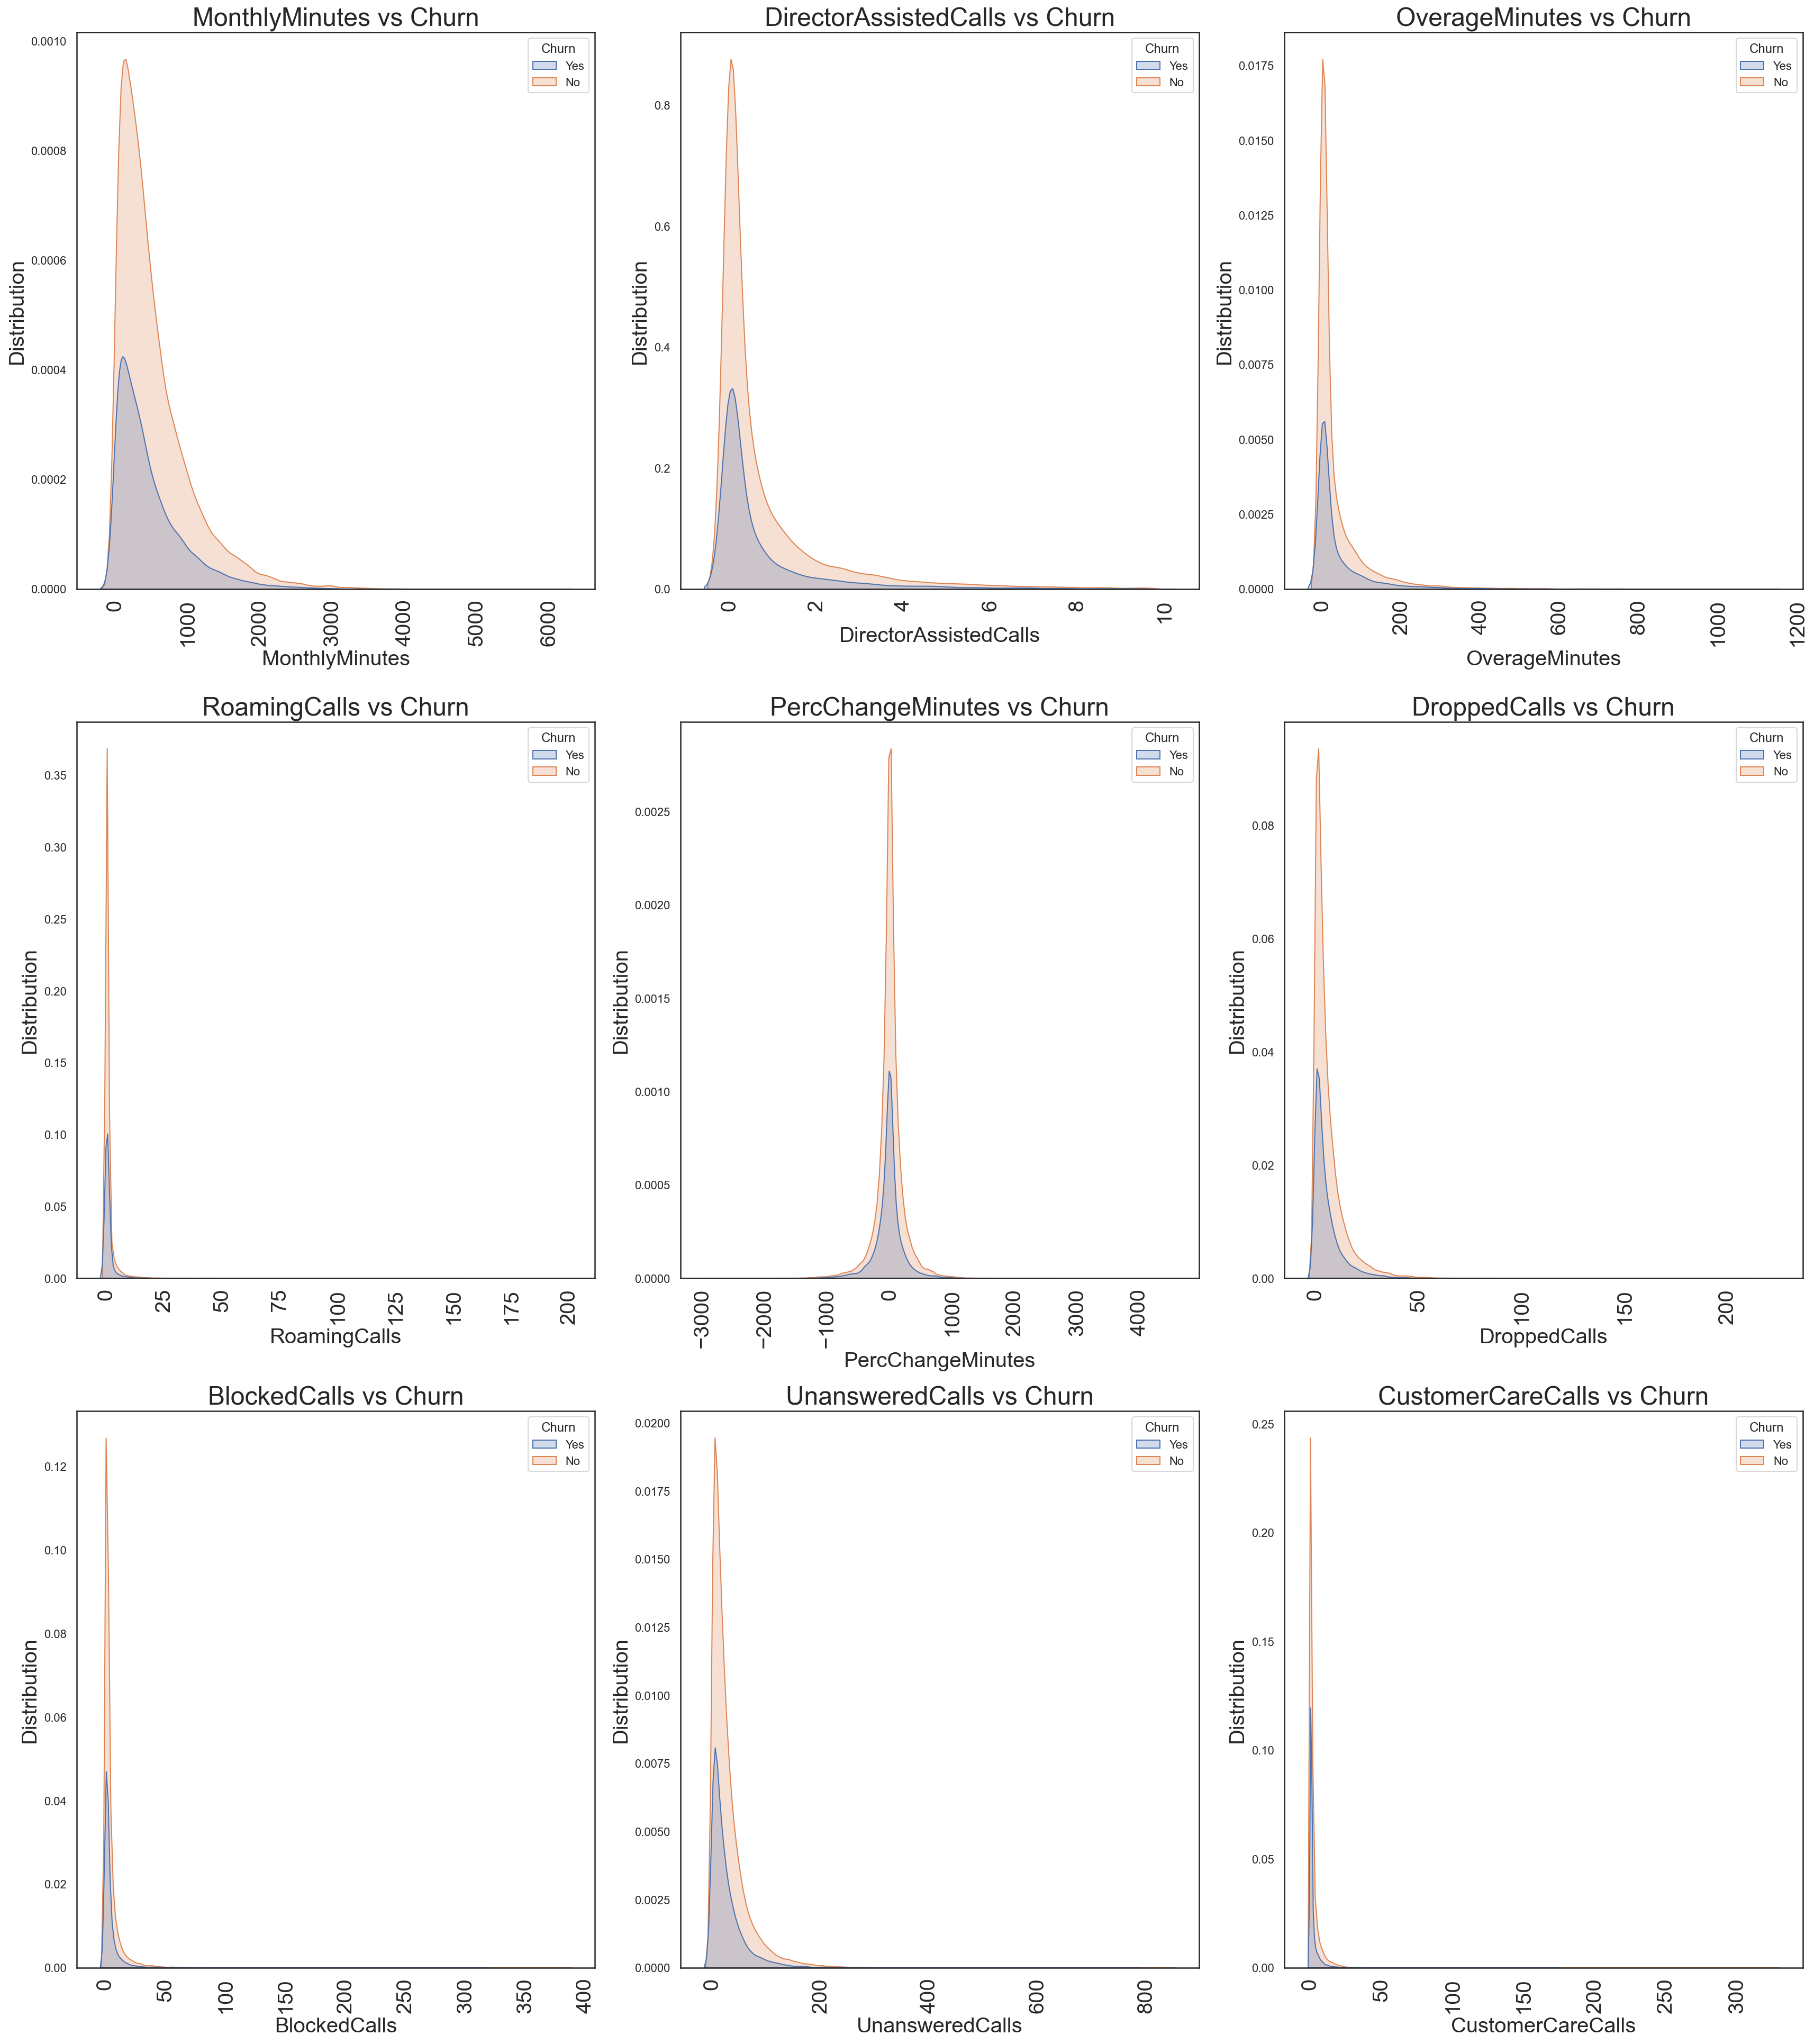

In [31]:
list_calls = [col for col in df_cust if 'Calls' in col or 'Minutes' in col]
list_calls.remove('RetentionCalls')
print(f' Features in this list :' ,list_calls[:9])
#Exploring the first 9 Call features
EDA_subplot(3,3 , list_calls[:9] , df_cust)
plt.tight_layout()

Features in this list : ['ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls']


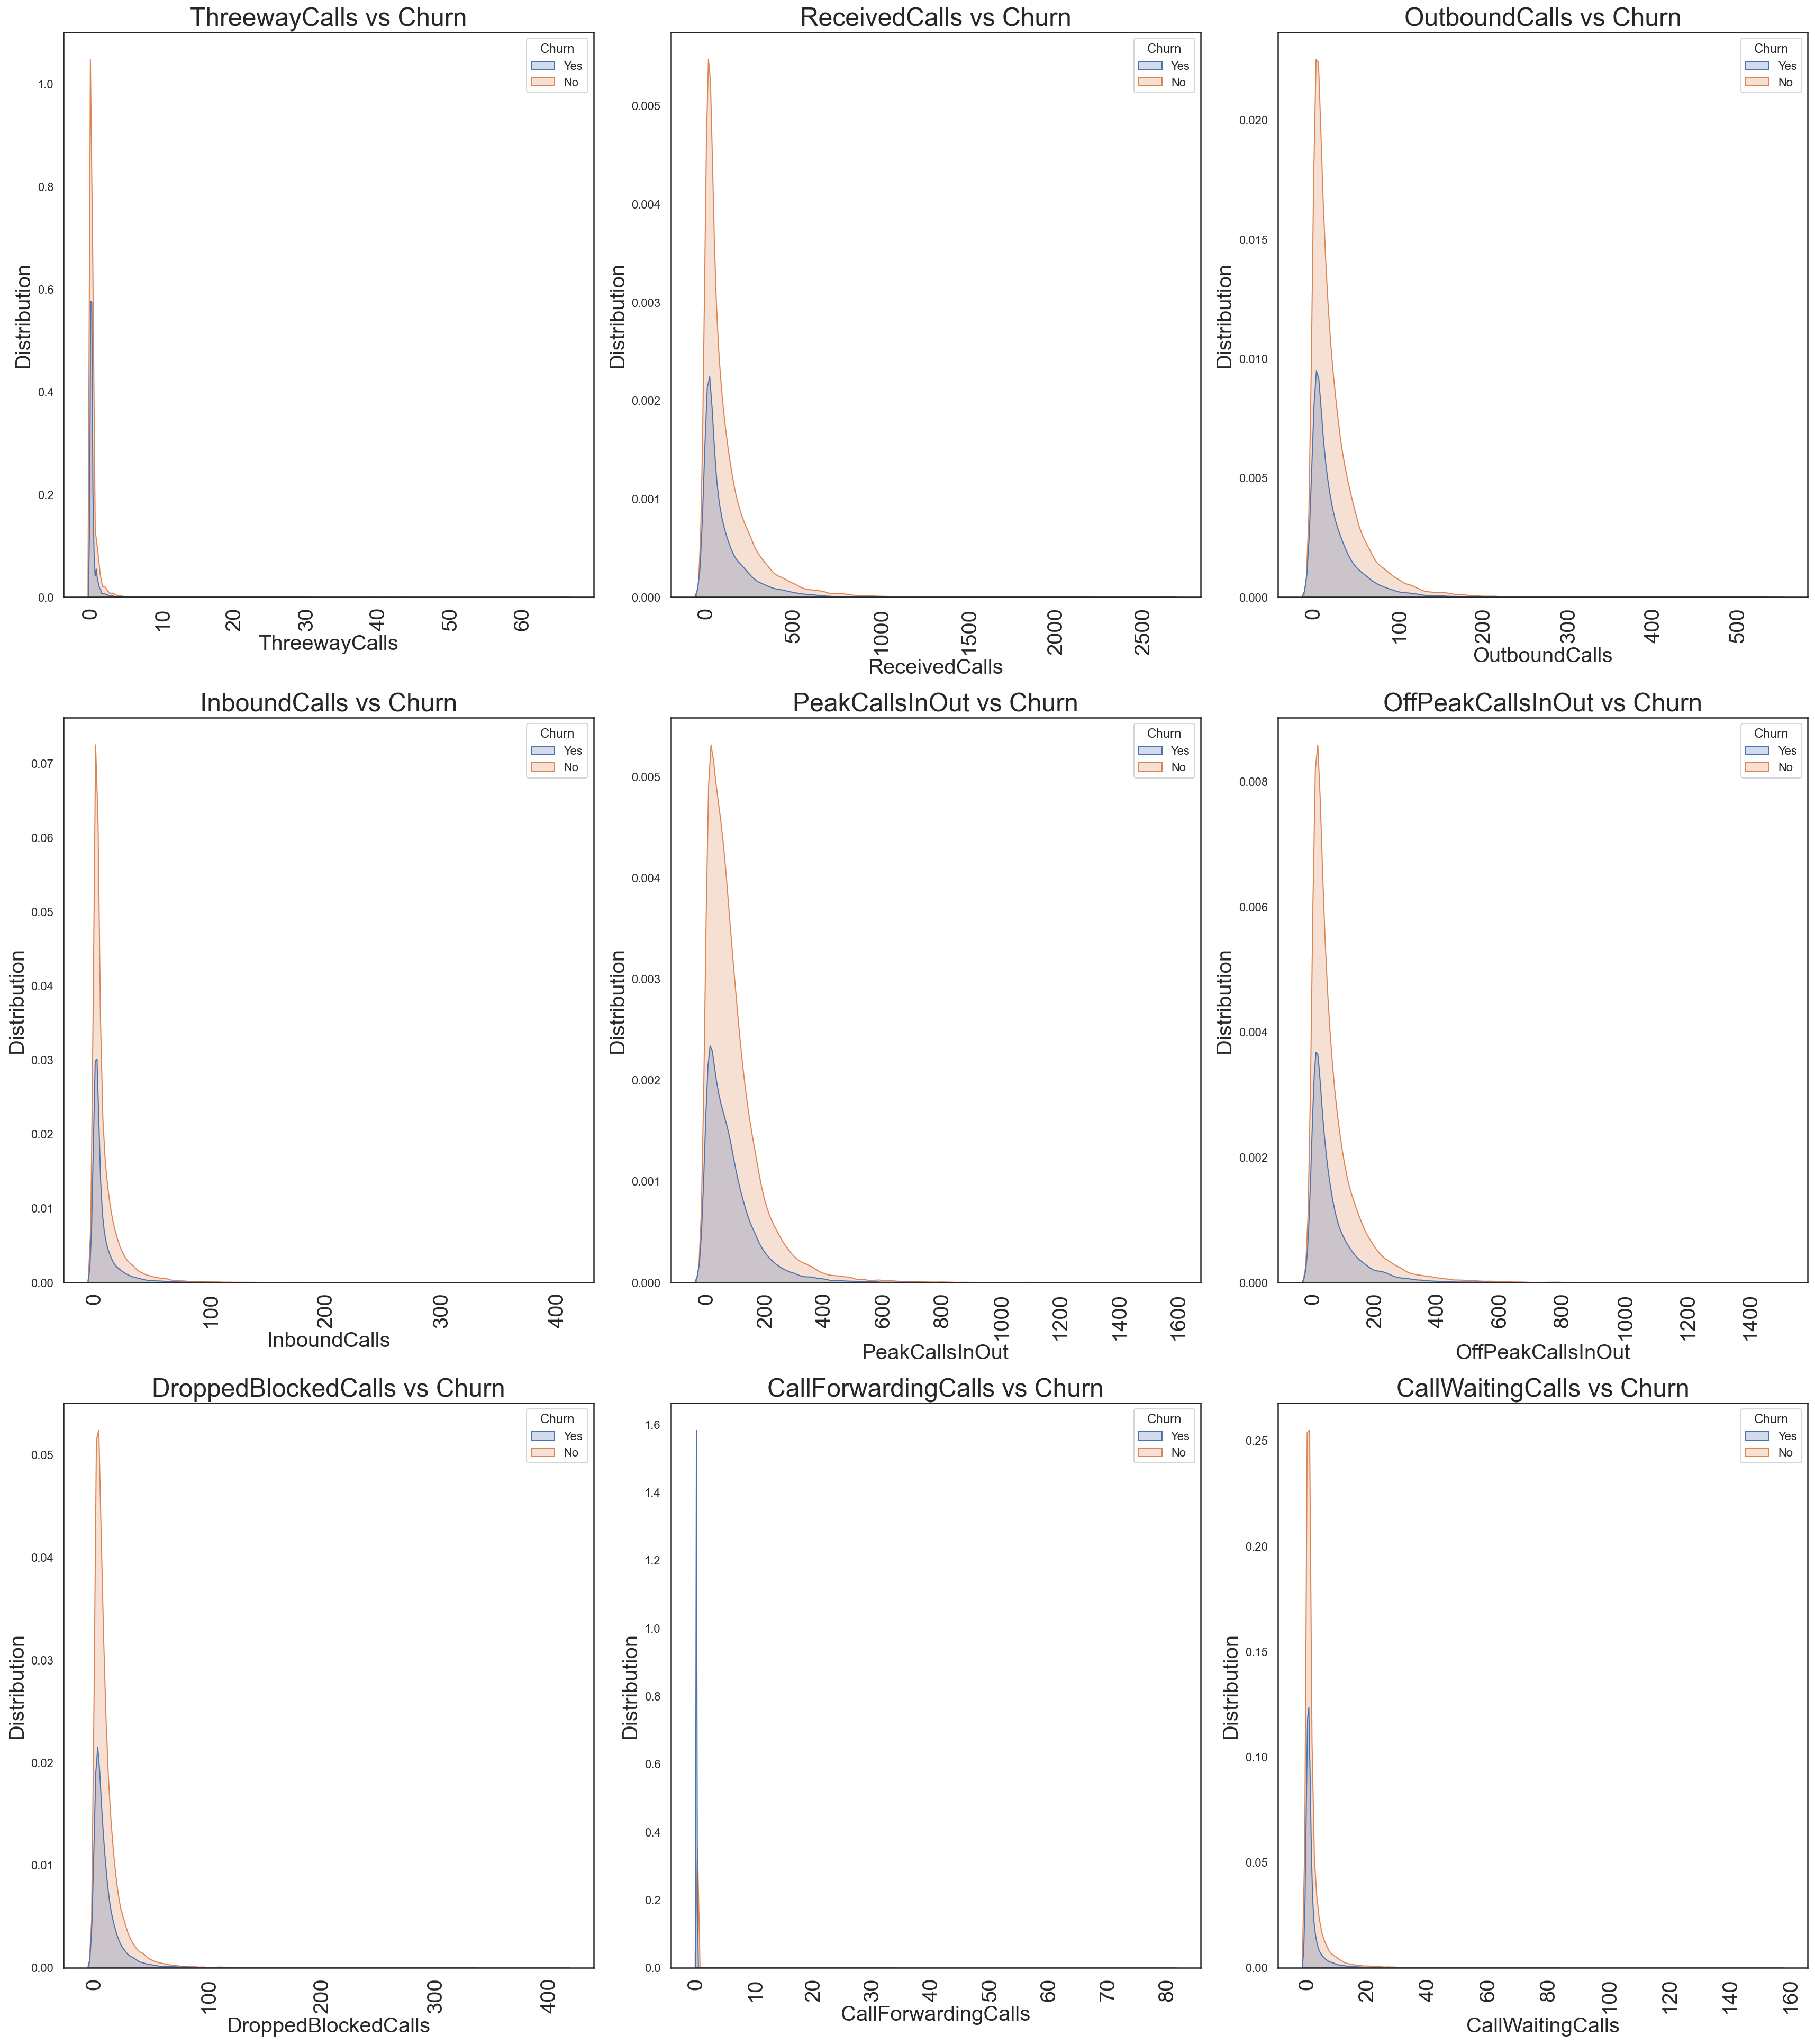

In [32]:
# Exploring the next 9 of 18 Call Features
print(f'Features in this list :' ,list_calls[9:])
EDA_subplot(3,3 , list_calls[9:] , df_cust)
plt.tight_layout()

<a id = 'section_2.5'><a/>
### 2.5 Subscription Info [(`back to top`)](#content)
___   
| Feature | Description | Column Value | Unit |
|---|---|---|---|
| MonthsInService | Total months in service | Numeric:<br>Range 0 - 70 | Quantity |
| UniqueSubs | Total number of unique sim card<br>subscriptions (includes inactive connection) | Numeric:<br>Range 0 - 5 | Quantity |
| ActiveSubs | Total # of active subscriptions | Numeric:<br>Range 0 - 5 | Quantity |
| AgeHH1 | Primary holder | Numeric:<br>Range 0 - 100 | Years Old |
| AgeHH2 | Secondary holder | Numeric:<br>Range 0 - 100 | Years Old |    

 Features in this list : ['MonthsInService', 'UniqueSubs', 'ActiveSubs', 'AgeHH1', 'AgeHH2']


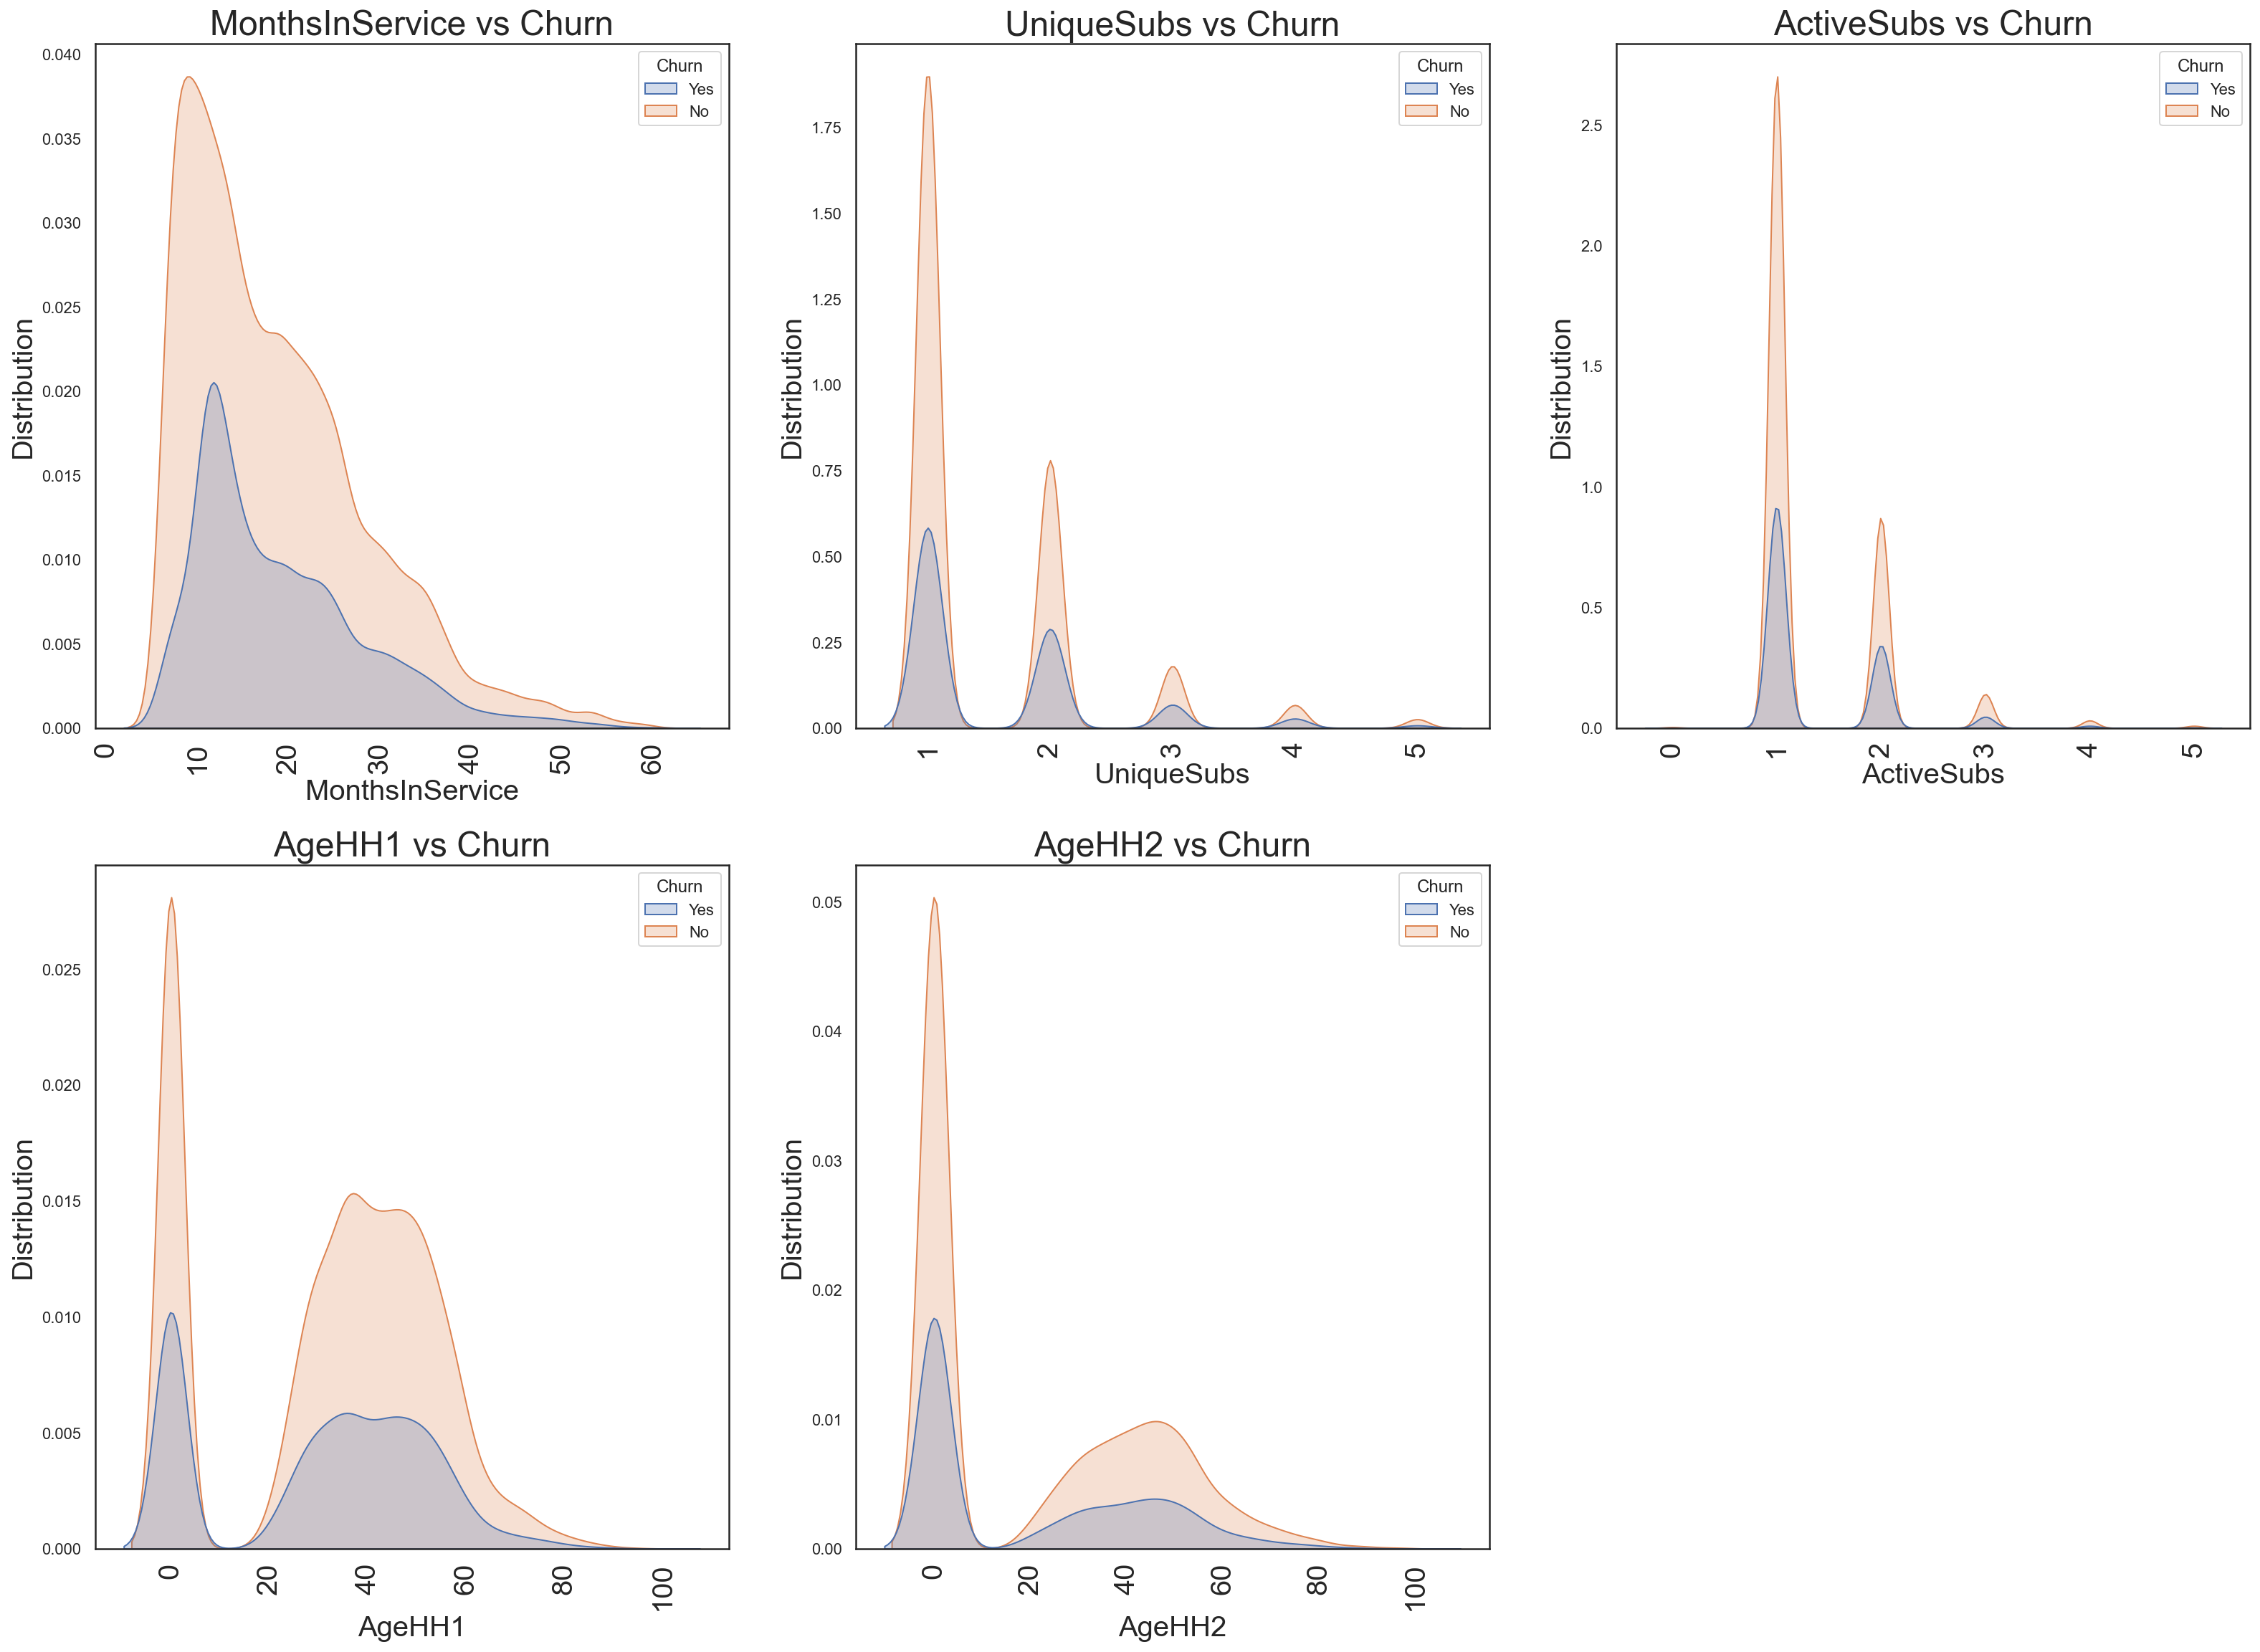

In [33]:
list_subscription = ['MonthsInService', 'UniqueSubs', 'ActiveSubs', 'AgeHH1', 'AgeHH2']
print(f' Features in this list :' ,list_subscription)
EDA_subplot(2,3,list_subscription , df_cust)

<a id = 'section_2.6'><a/>
### 2.6 Exploring Handset Features [(`back to top`)](#content)
___
    
* From the Visualisation , we observed there is some data discrepancies for the `HandSetPrice`. There is Unknown Data in this column.
* There are 28722 rows with Unknown data for `HandsetPrice`. This is more than 50% of the dataset.
* The logical move will be to drop this column.  

| Feature | Description | Column Value | Unit |
|---|---|---|---|
| Handsets | Total # of handsets | Numeric:<br>Range 0 - 25 | Quantity |
| HandsetModels | Total # of unique handset model | Numeric:<br>Range 0 - 12 | Quantity |
| CurrentEquipmentDays | Number of days since the<br>activation of current equipment | Numeric:<br>Range 0 - 2000 | Days |
| HandsetRefurbished | Handset refurbished flag<br>(returned to company and then<br>they sell it to different customer) | Yes<br>No | - |
| HandsetWebCapable | Internet connectivity | Yes<br>No | - |
| HandsetPrice | Price of the handset in USD | Numeric:<br>Range 0 - 500 | USD |

Features in this list : ['Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'HandsetRefurbished', 'HandsetWebCapable', 'HandsetPrice']


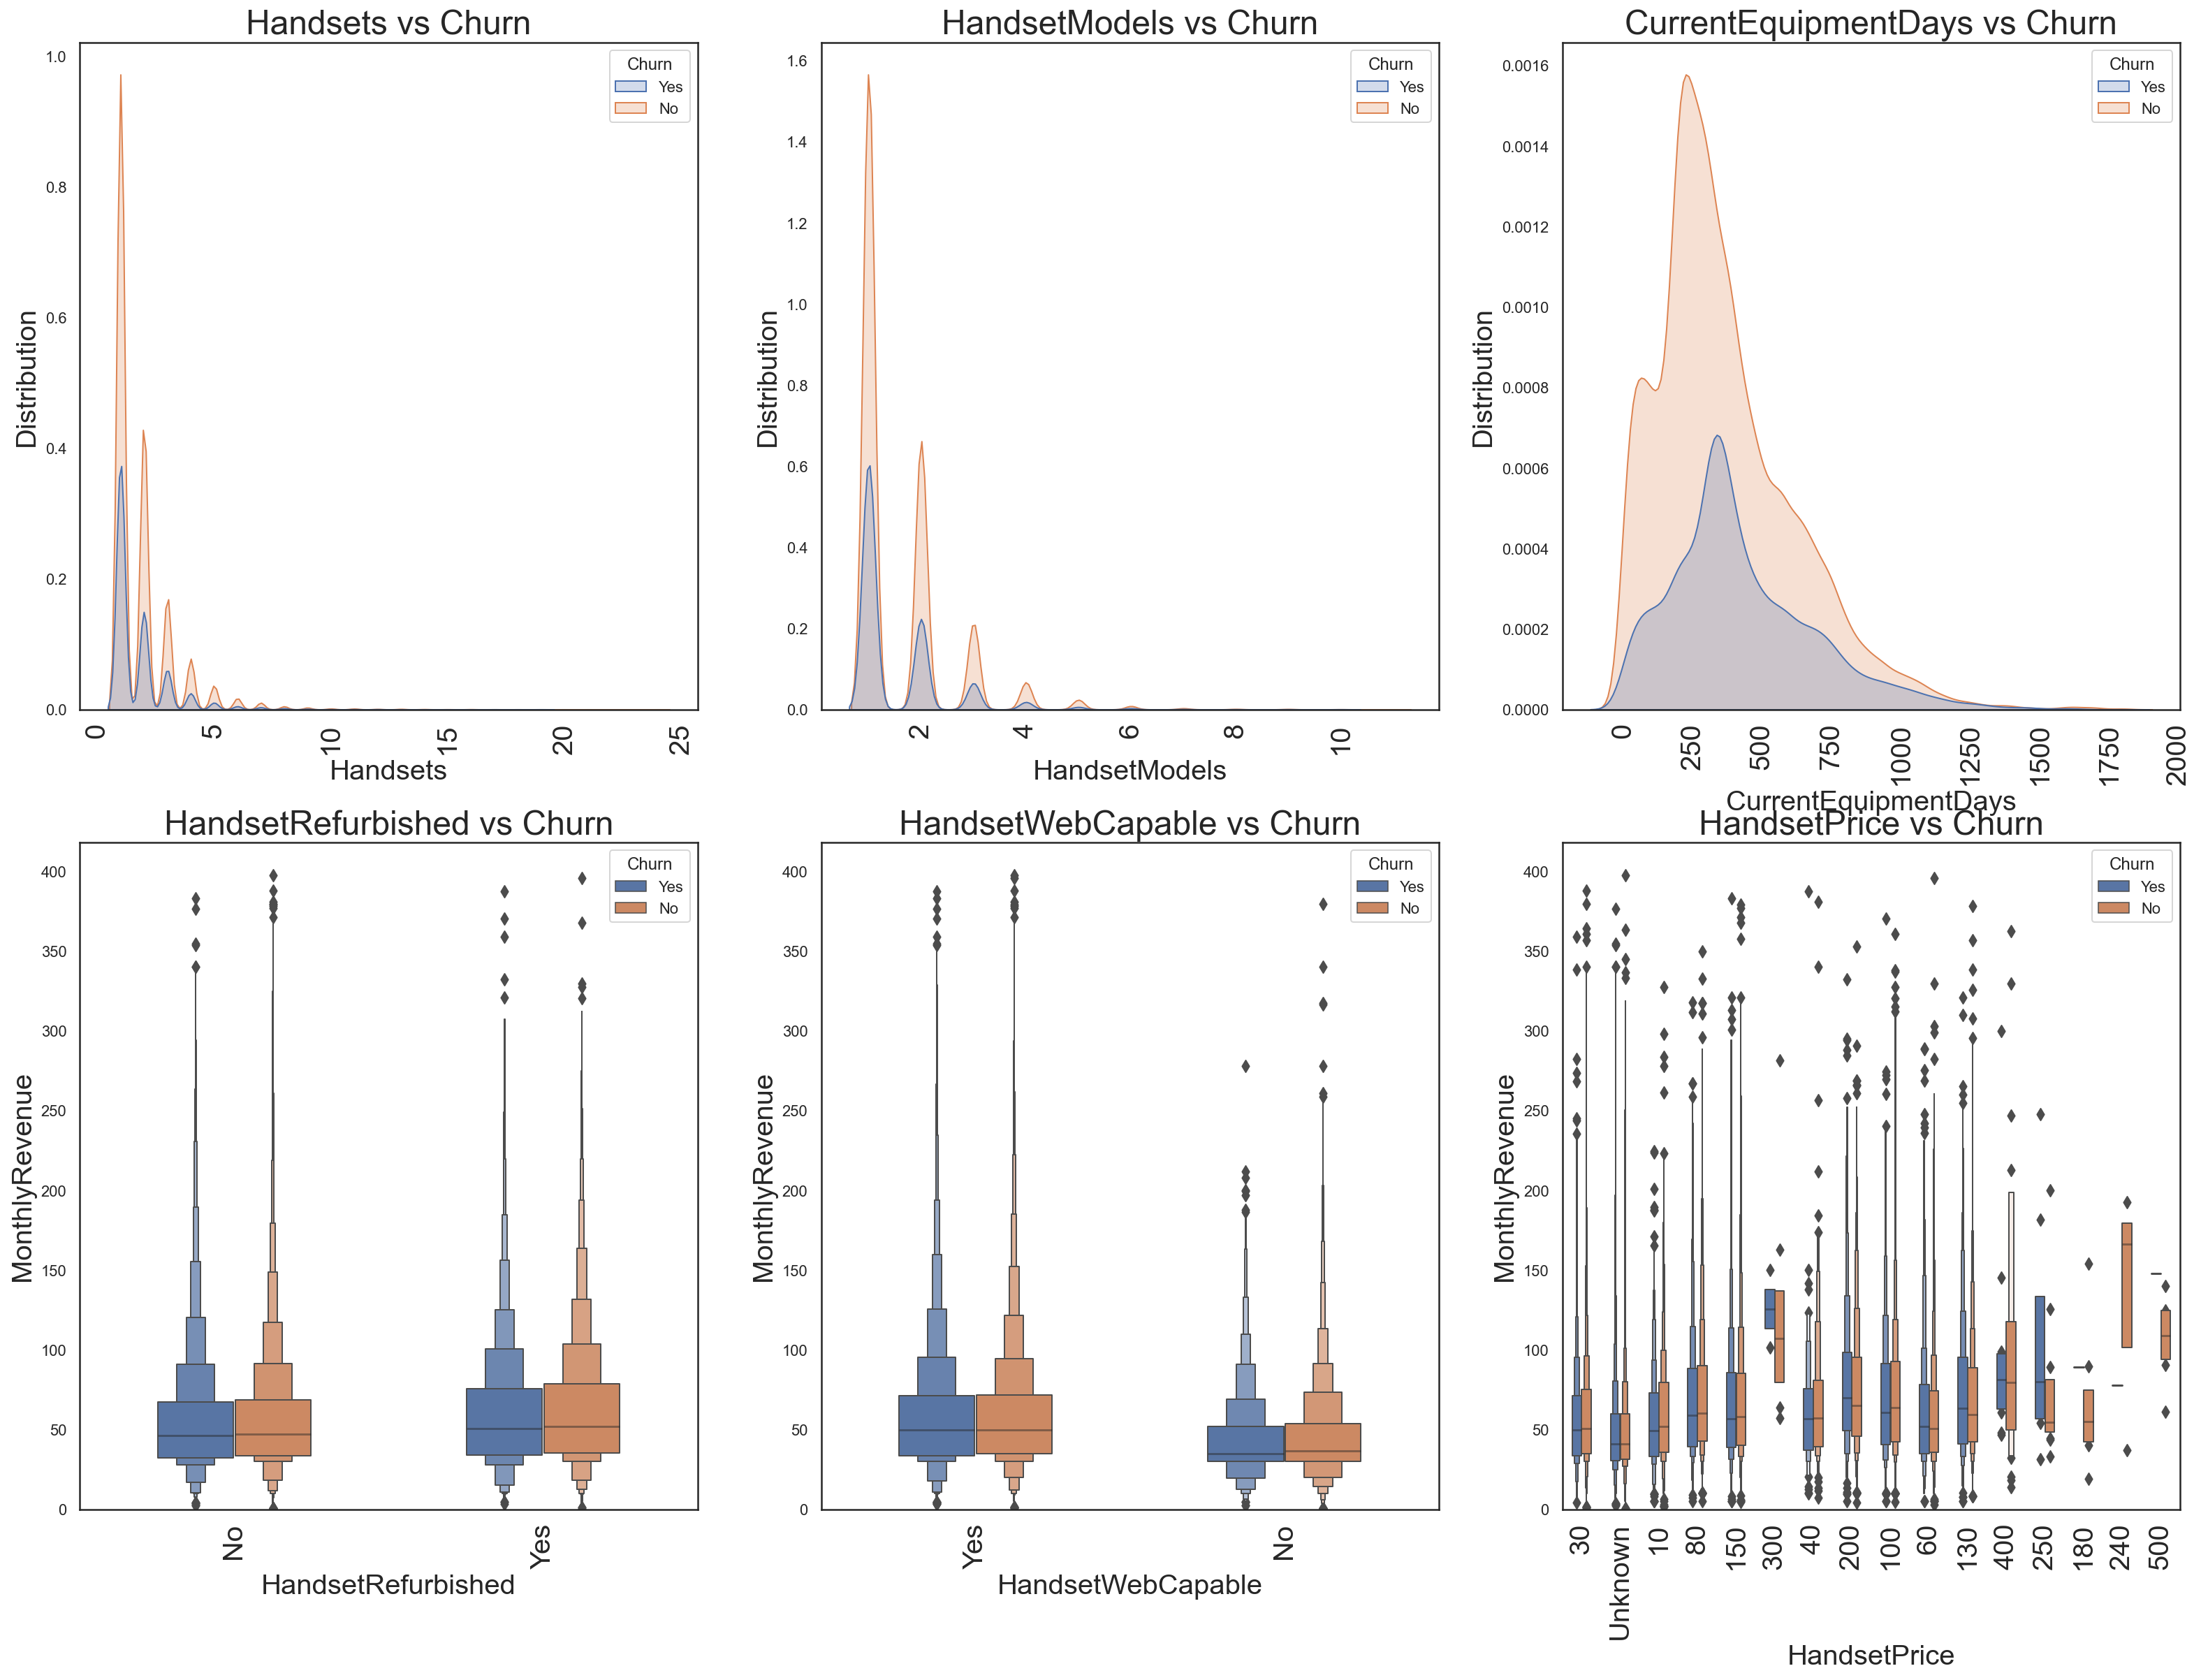

In [34]:
list_handset = [col for col in df_cust if 'Handset' in col or 'CurrentEquipmentDays' in col]
print(f'Features in this list :' ,list_handset)
EDA_subplot(2 , 3, list_handset , df_cust)

In [35]:
print(f'There are {len(df_cust[df_cust["HandsetPrice"] == "Unknown"])} of Unknown Data for this column')

There are 28707 of Unknown Data for this column


In [36]:
# Drop HandsetPrice column. 'Unknown' Data make up more than 50%.

print('DF before drop column: ' , df_cust.shape)
df_cust.drop('HandsetPrice' , inplace = True , axis = 1)
print('DF after drop column : ' , df_cust.shape)

DF before drop column:  (50237, 58)
DF after drop column :  (50237, 57)


<a id = 'section_2.7a'><a/>
### 2.7a Customer Profile - Asset Features [(`back to top`)](#content)
___
    
| Feature | Description | Column Value |
|---|---|---|
| TruckOwner | Flag indicating whether the<br>Customer owns a truck | No<br>Yes |
| RVOwner | Customer owns RV or not | No<br>Yes |
| Homeownership | Home owned by customer | Known<br>Unknown |
| OwnsComputer | Whether customer<br>Owns computers | No<br>Yes |
| OwnsMotorcycle | Owns motorcycle flag | No<br>Yes |    

 Features in this list : ['TruckOwner', 'RVOwner', 'Homeownership', 'OwnsComputer', 'OwnsMotorcycle']


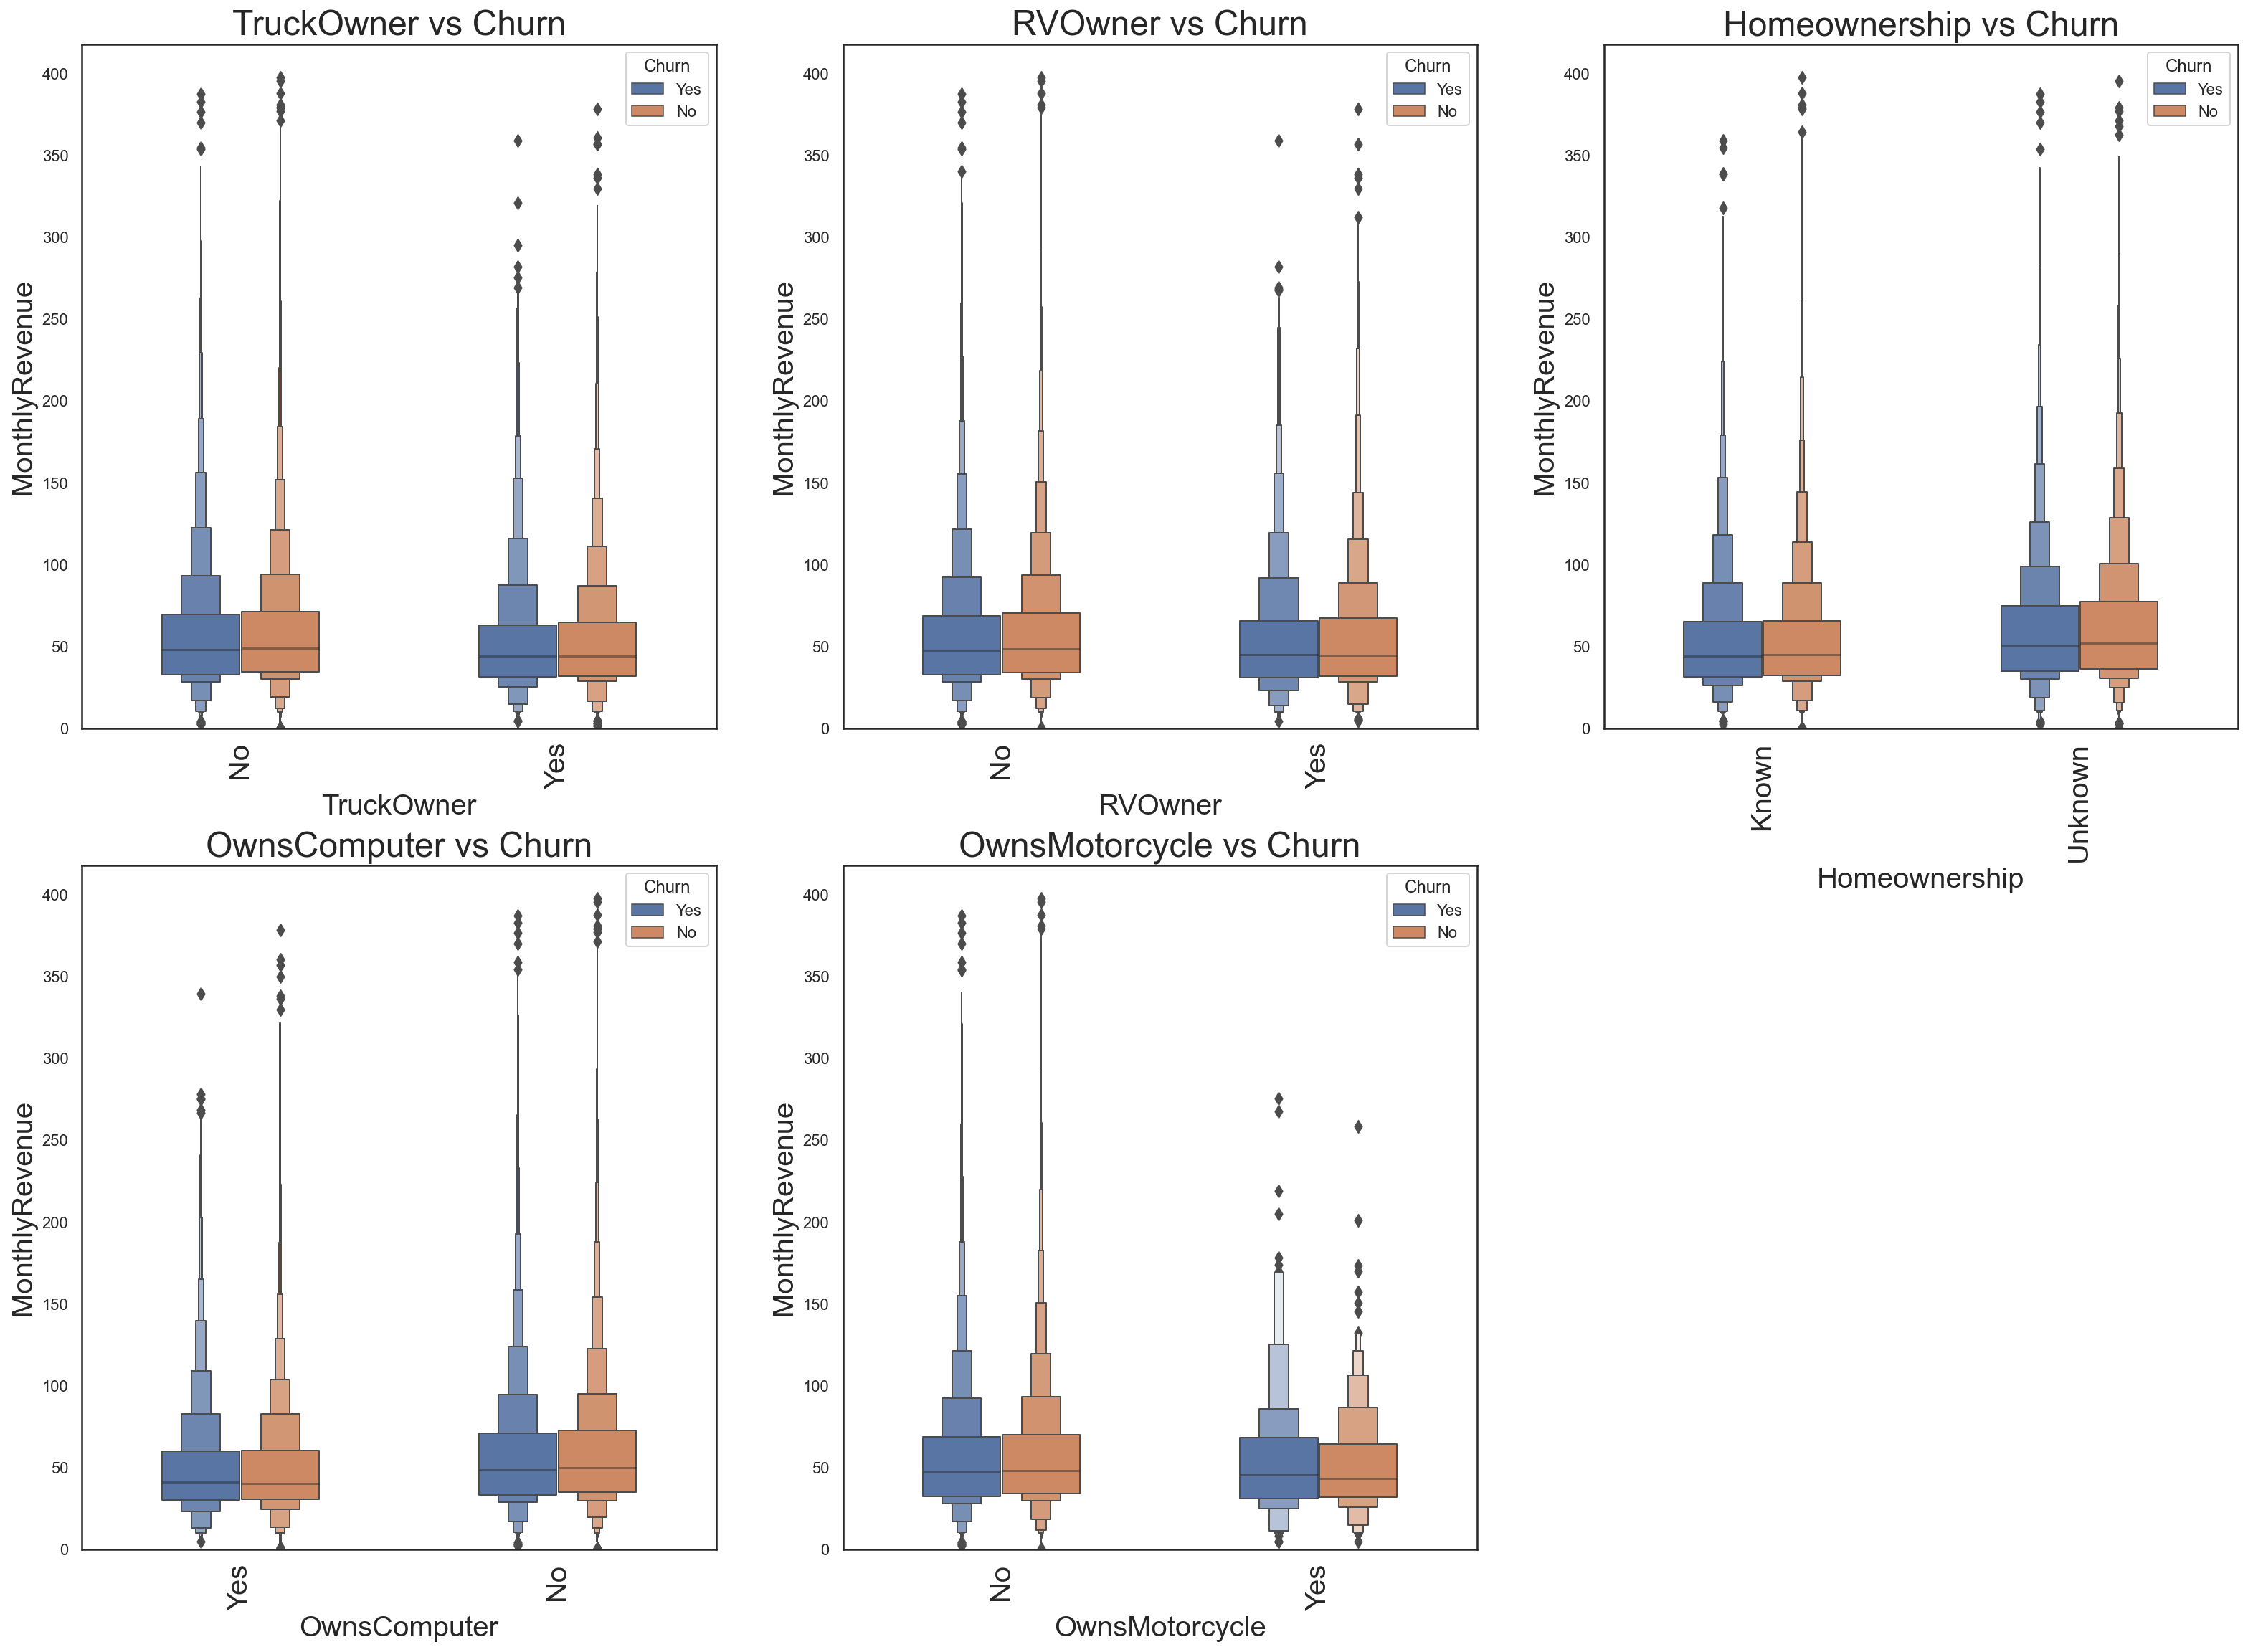

In [37]:
list_owner = [col for col in df_cust if 'Own' in col or 'own' in col]
print(f' Features in this list :' ,list_owner)
EDA_subplot(2 , 3, list_owner , df_cust)

<a id = 'section_2.7b'><a/>
### 2.7b Customer Profile - Persona Info
___
[(back to top)](#content)
    
* From the Visualisation , we observed there is some data discrepancies for the `MaritalStatus`. There is Unknown Data in this column.
* There are 19351 rows with Unknown data for `MaritalStatus`. This is around than 30% of the dataset.
* The logical move will be to drop this column.  

| Feature | Description | Column Value | Unit |
|---|---|---|---|
| ChildrenInHH | Flag indicating childen in household | Numeric:<br>0 and 1 | Boolean |
| NonUSTravel | Flag indicating whether the customer<br>has travelled outside of US | Numeric:<br>0 and 1 | Boolean |
| NewCellphoneUser | New cellphone user flag | Numeric:<br>0 and 1 | Boolean |
| NotNewCellphoneUser | Total not new cellphone user flag | Numeric:<br>0 and 1 | Boolean |
| PrizmCode | Area group of customer home location | Numeric:<br>Range 1 to 4 | - |
| MaritalStatus | Marital status | No<br>Yes<br>Unknown | - |

 Features in this list : ['ChildrenInHH', 'NonUSTravel', 'NewCellphoneUser', 'NotNewCellphoneUser', 'PrizmCode', 'MaritalStatus']


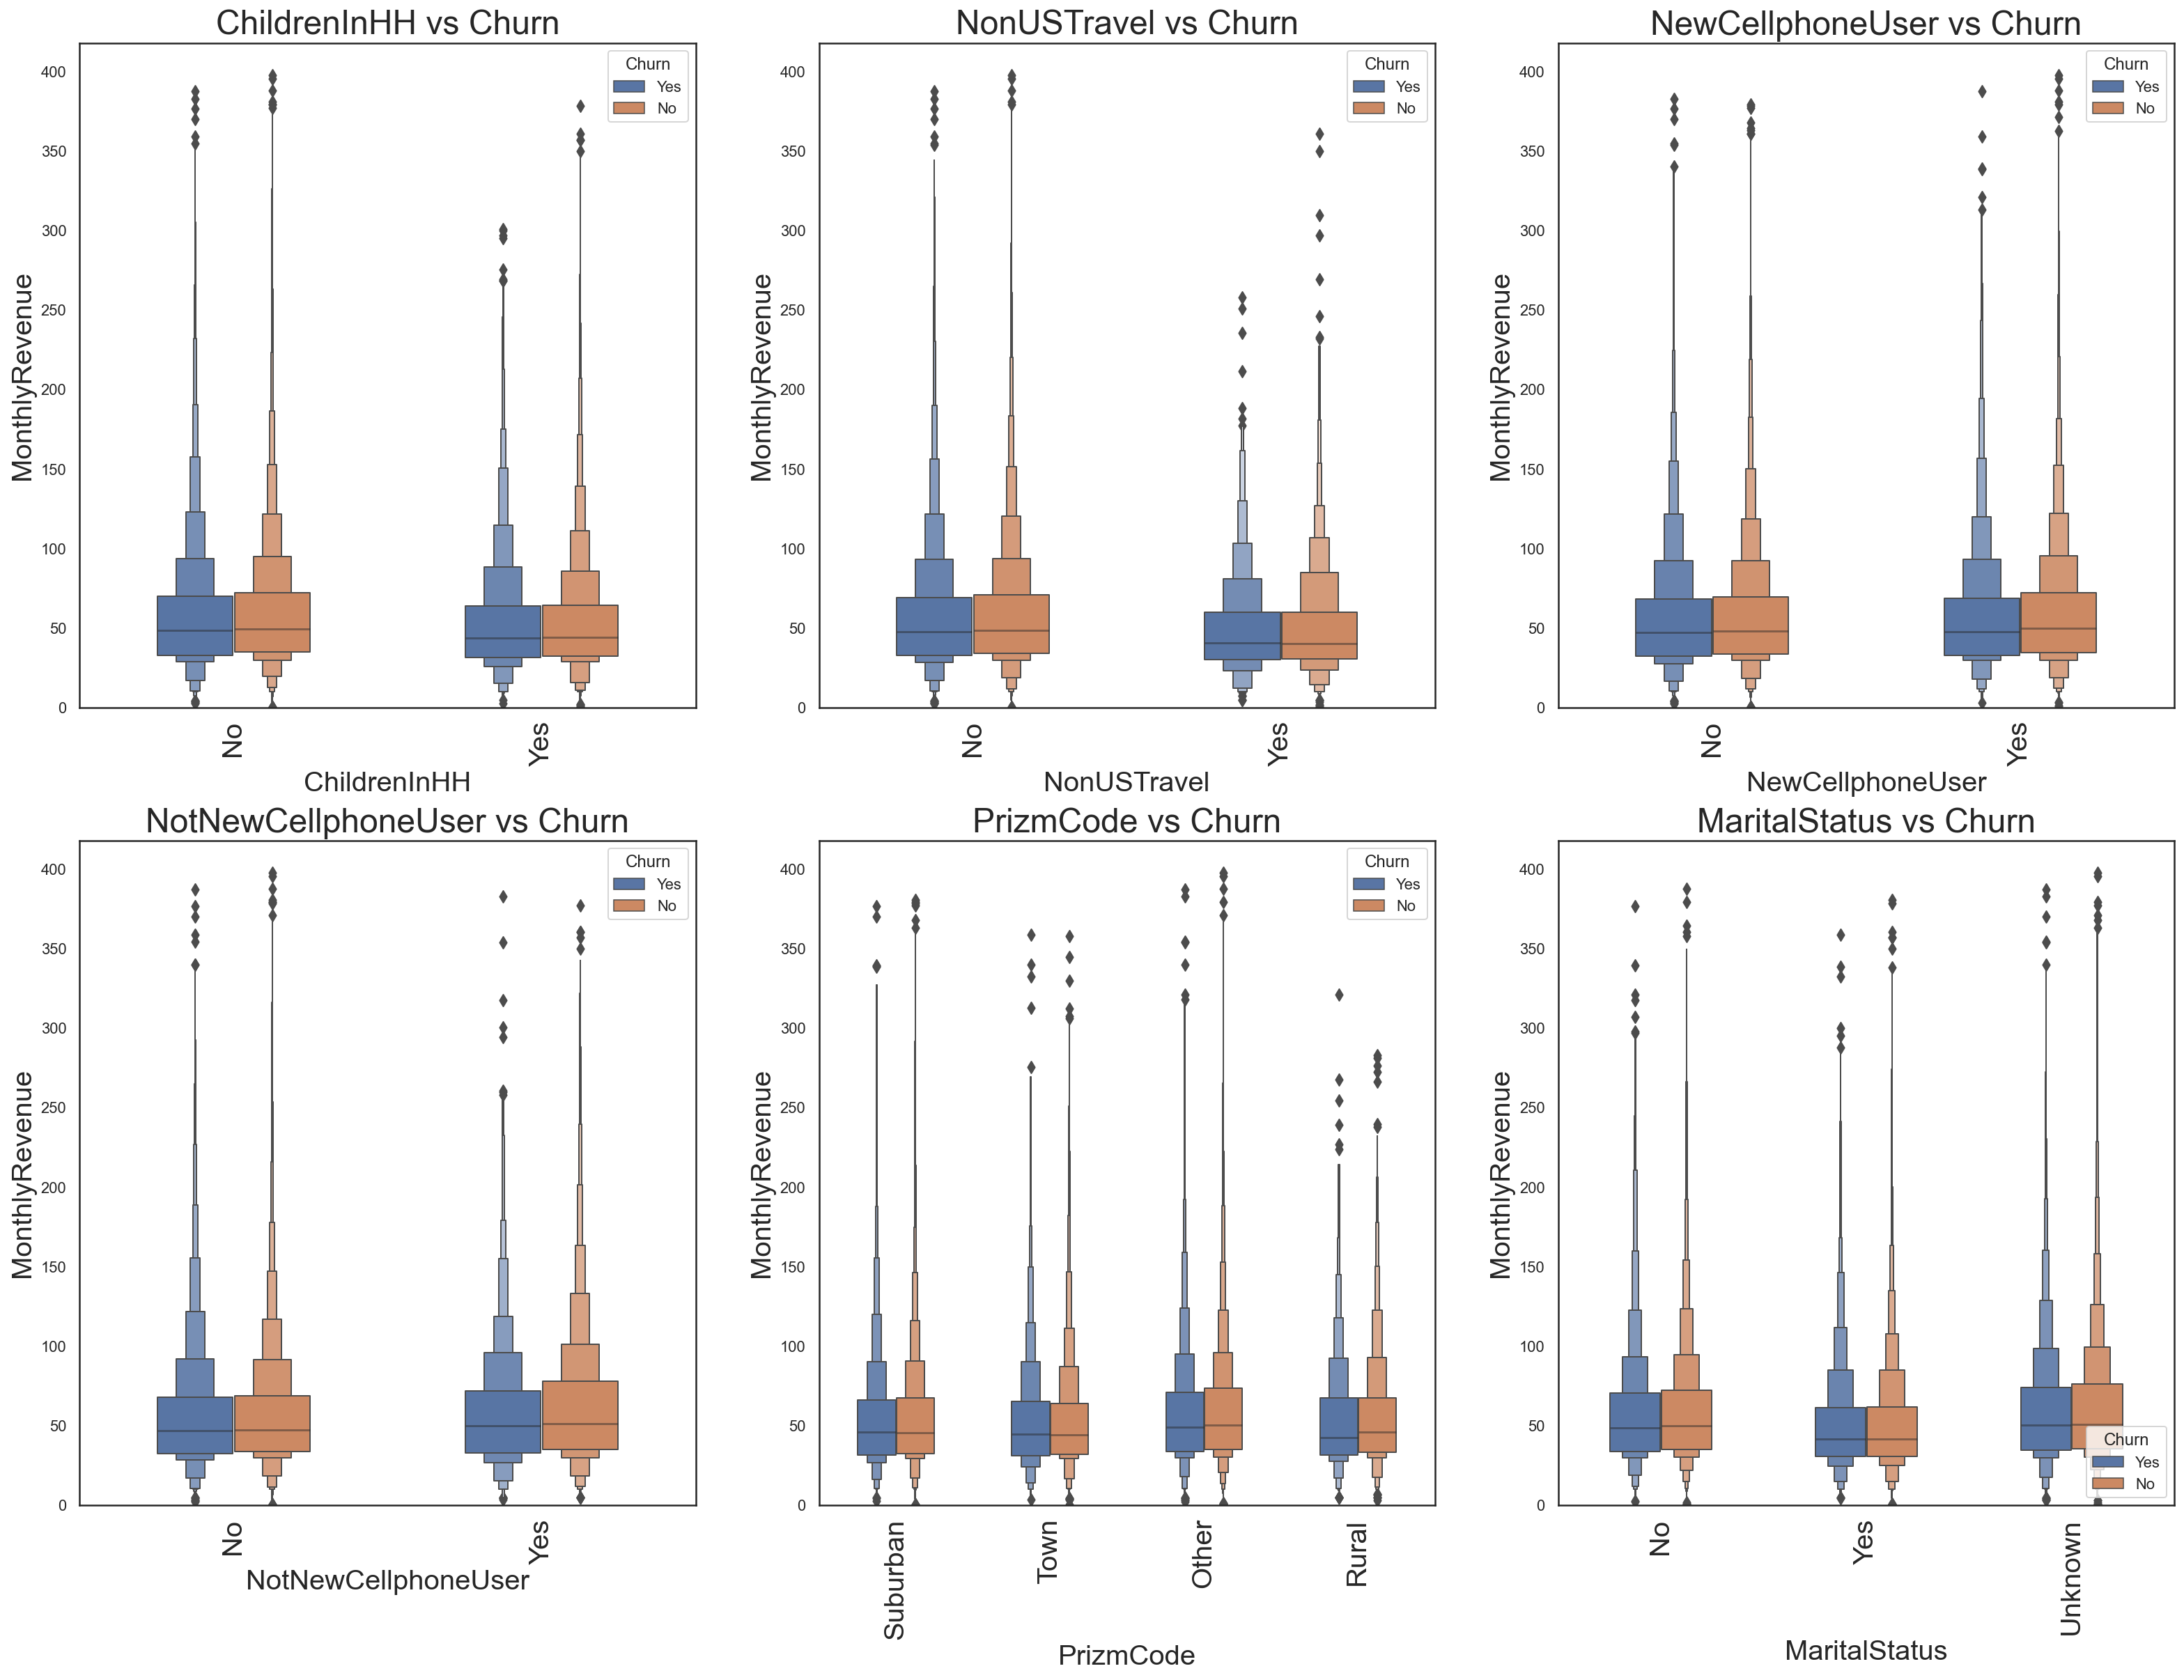

In [38]:
list_person = ['ChildrenInHH', 'NonUSTravel', 'NewCellphoneUser', 'NotNewCellphoneUser', 'PrizmCode', 'MaritalStatus']
print(f' Features in this list :' ,list_person)
EDA_subplot(2,3,list_person , df_cust)

In [39]:
print(f'There are {len(df_cust[df_cust["MaritalStatus"] == "Unknown"])} of Unknown Data for this column')

There are 19321 of Unknown Data for this column


In [40]:
# Drop MaritalStatus column. 'Unknown' Data make up more than 30%.

print('DF before drop column: ' , df_cust.shape)
df_cust.drop('MaritalStatus' , inplace = True , axis = 1)
print('DF after drop column : ' , df_cust.shape)

DF before drop column:  (50237, 57)
DF after drop column :  (50237, 56)


<a id = 'section_2.7c'><a/>
### 2.7c Customer Profile - Occupation and Income
___
[(back to top)](#content)
    
| Feature | Description | Column Value |
|---|---|---|
| IncomeGroup | Income group | Numeric:<br>Range 0 - 10 |
| Occupation | Type of occupation | Professional<br>Crafts<br>Other<br>Self<br>Retired<br>Homemaker<br>Clerical<br>Student |    

 Features in this list : ['IncomeGroup', 'Occupation']


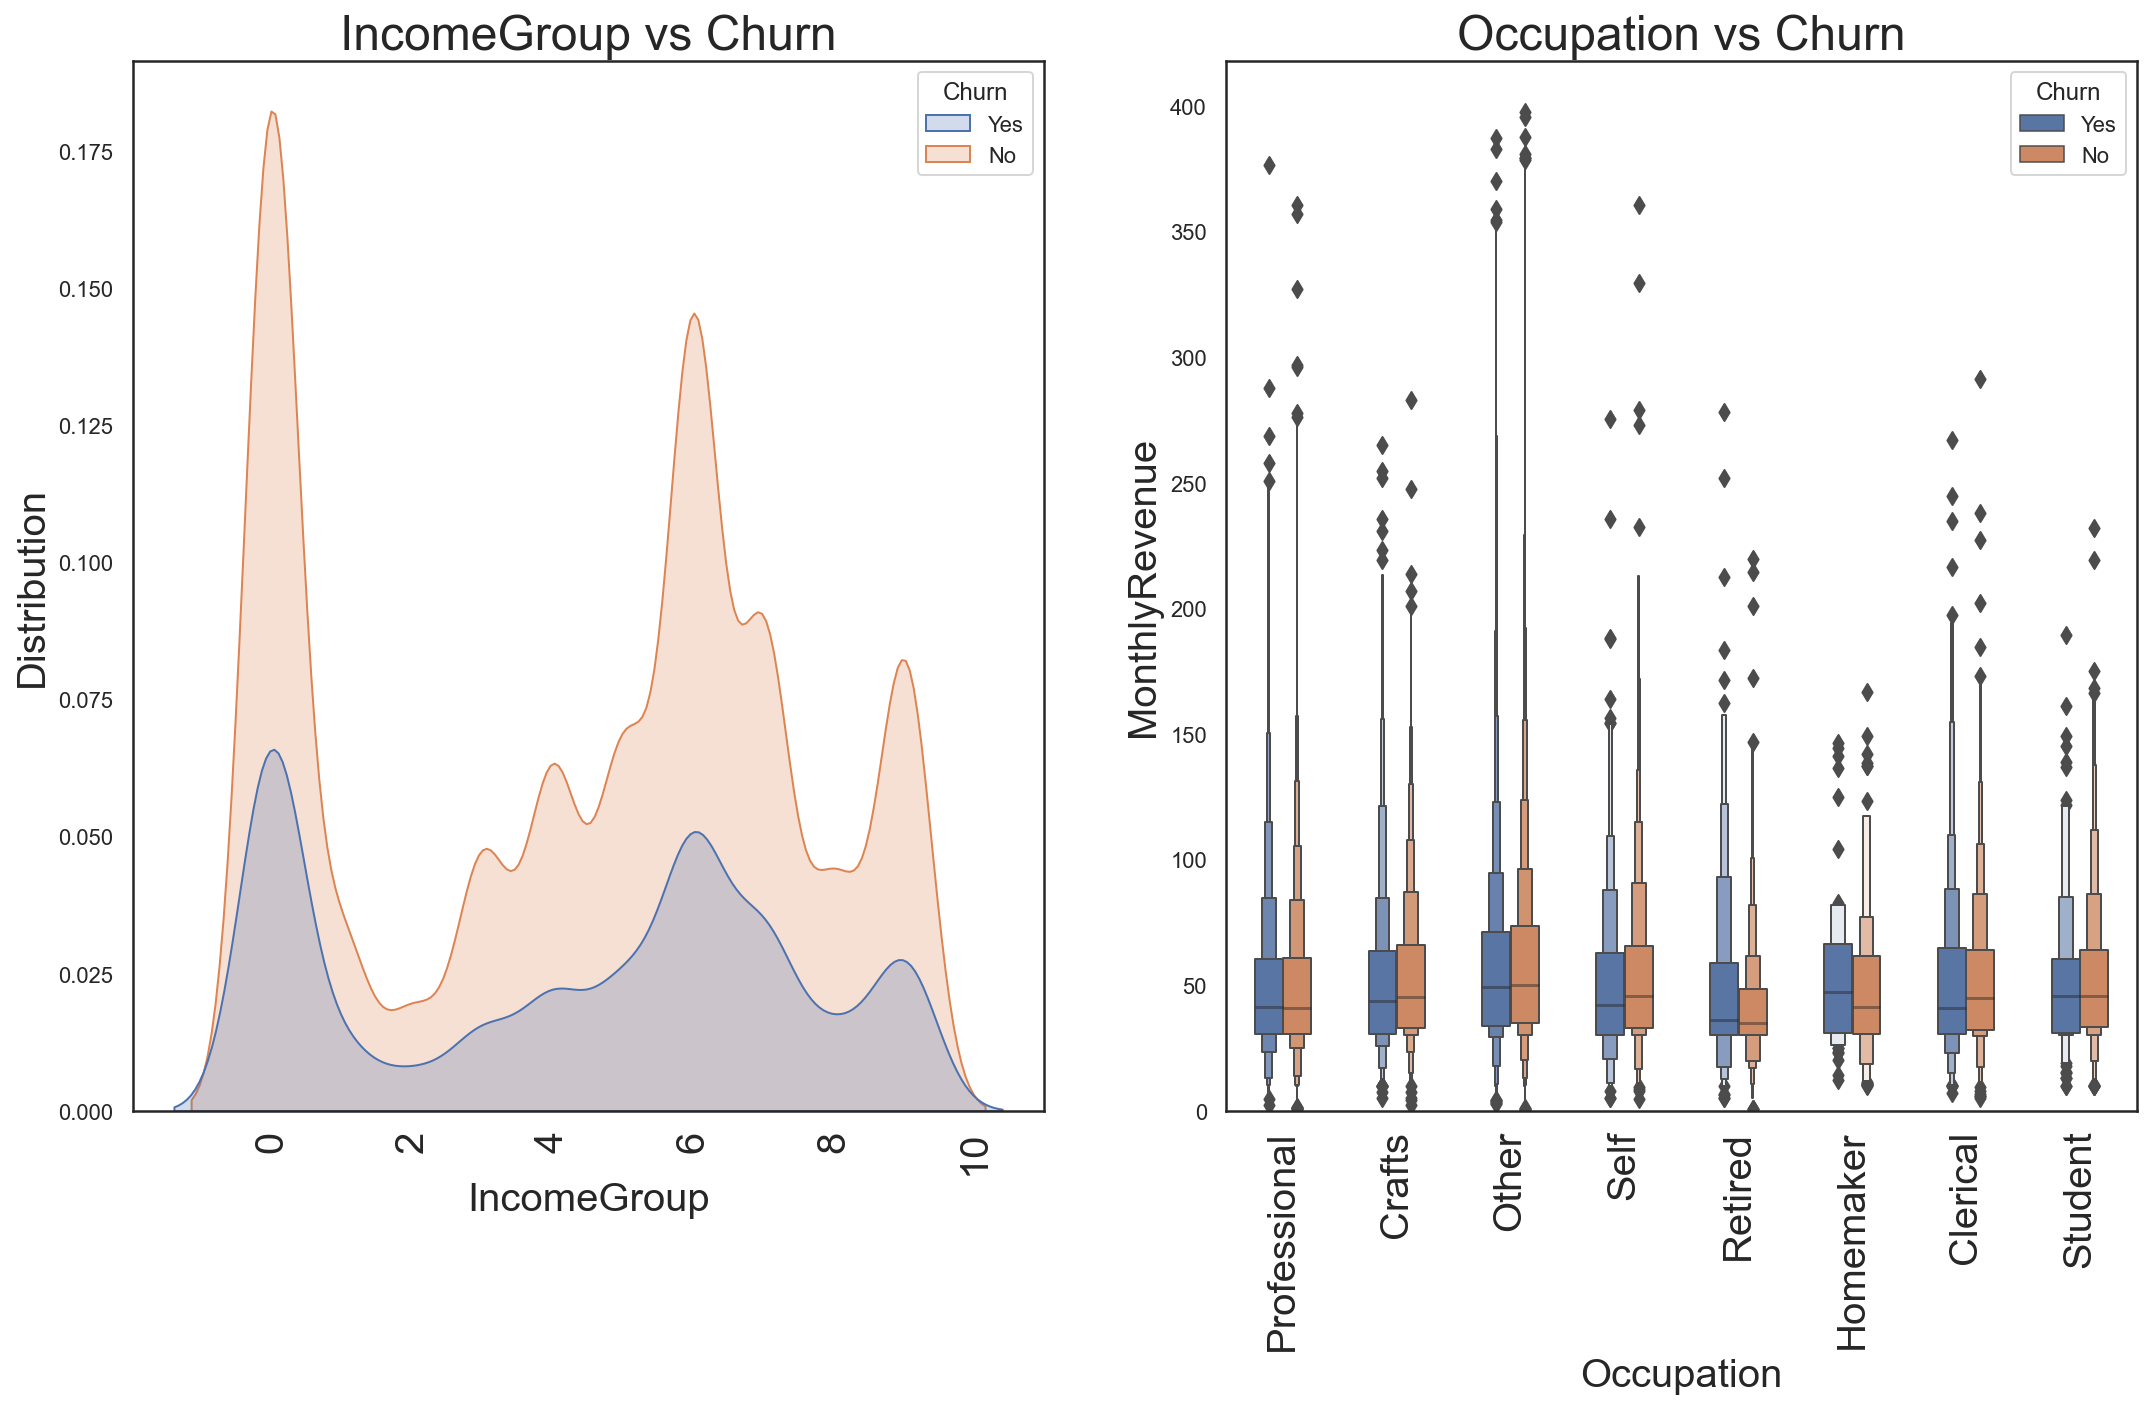

In [41]:
# df_cust['IncomeGroup'] = df_cust['IncomeGroup'].astype('category')

list_career = [col for col in df_cust if 'Income' in col or 'Occupation' in col]
print(f' Features in this list :' ,list_career)
EDA_subplot(1,2,list_career , df_cust)

<a id = 'section_2.8a'><a/>
### 2.8a Customer Interaction - Mail & Referral Related
___
        
[(back to top)](#content)
    
| Feature | Description | Column Value | Unit |
|---|---|---|---|
| BuysViaMailOrder | Whether customer has bought anything<br>via clicking an option on email | No<br>Yes | - |
| RespondsToMailOffers | Flag indicating whether customer<br>responds to mail offers | No<br>Yes | - |
| OptOutMailings | Whether the customer has opted<br>out of mailing | No<br>Yes | - |
| ReferralsMadeBySubscriber | Total referrals made by subscriber | Numeric:<br>Range 0 - 40 | Quantity |    

 Features in this list : ['BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'ReferralsMadeBySubscriber']


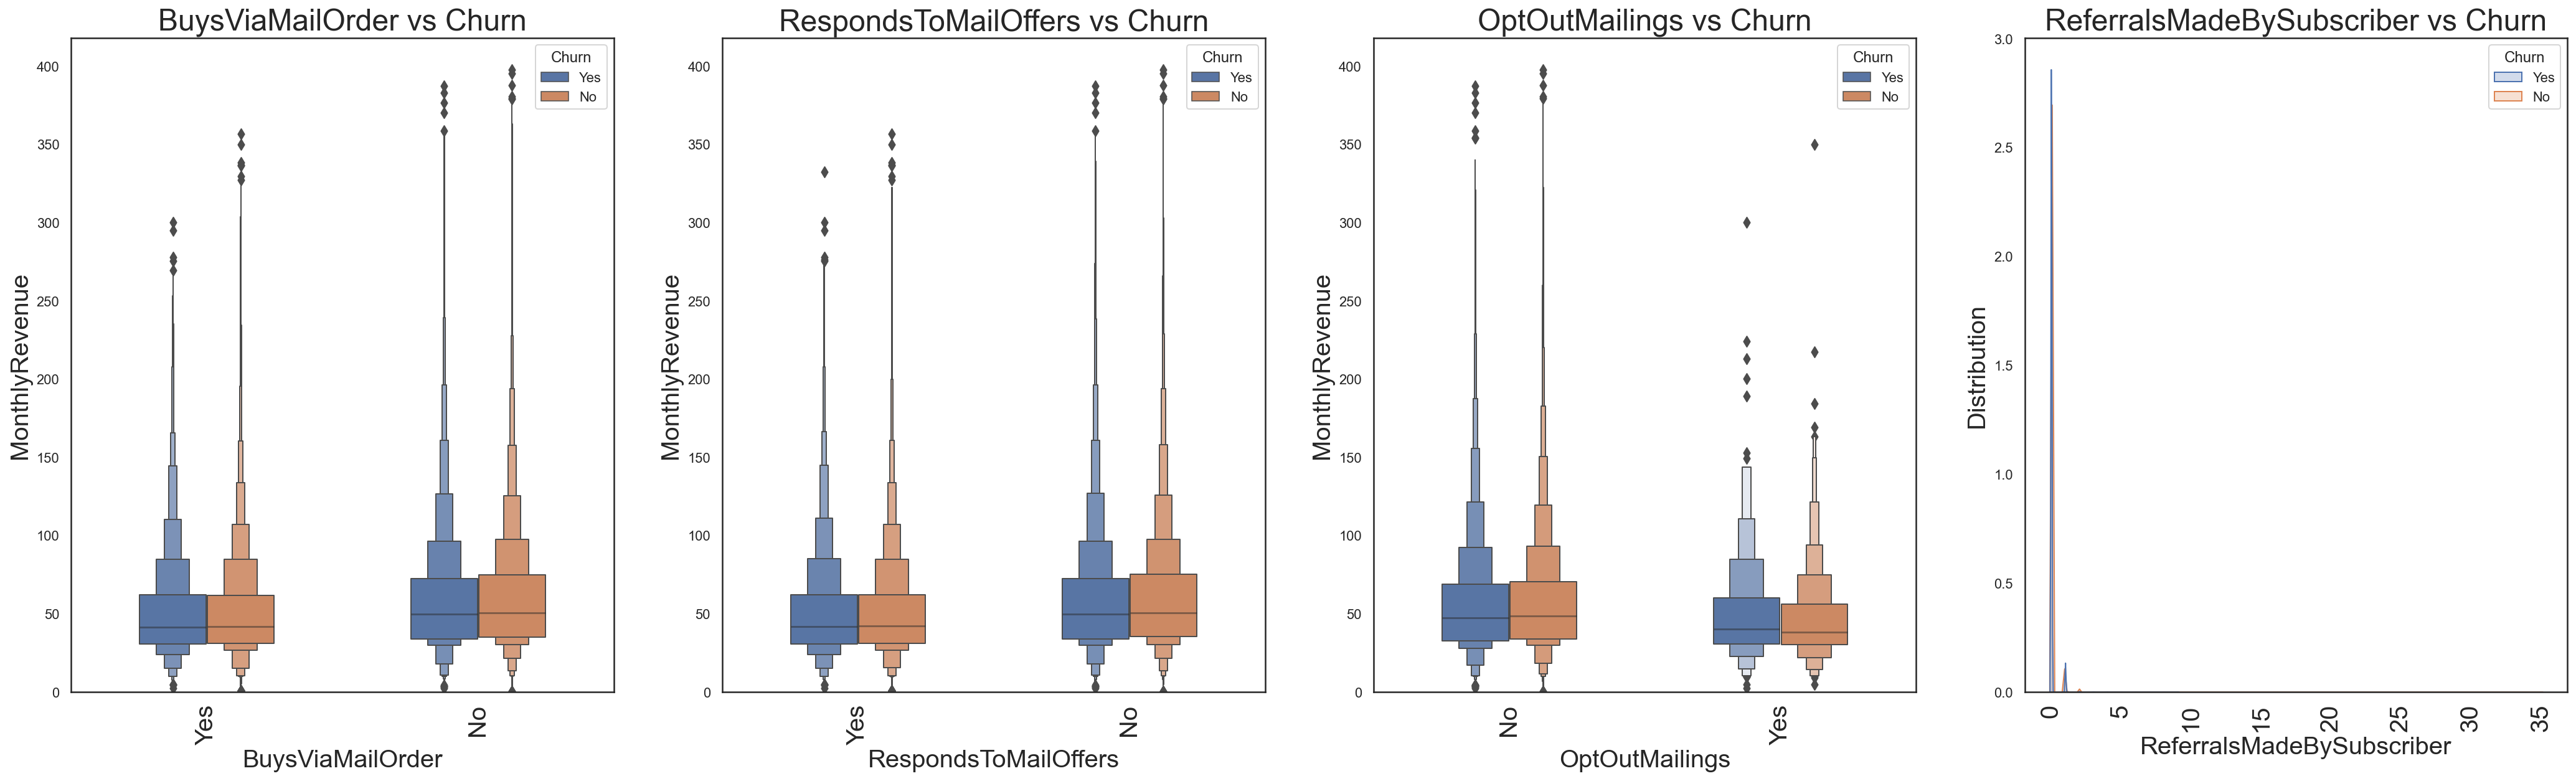

In [42]:
list_mail = [col for col in df_cust if 'Mail' in col or 'ReferralsMadeBySubscriber' in col]
print(f' Features in this list :' ,list_mail)
EDA_subplot(1,4,list_mail , df_cust)

<a id = 'section_2.8b'><a/>
### 2.8b Customer Interaction - Retention Related Features
___
[(back to top)](#content)
    
| Feature | Description | Column Value | Unit |
|---|---|---|---|
| RetentionCalls | Whether customer responded to<br>retention calls | Numeric:<br>Range 0 - 4 | Quantity |
| RetentionOffersAccepted | Whether customer accepted<br>retention offers | Numeric:<br>Range 0 - 3 | Quantity |
| MadeCallToRetentionTeam | Flag indicating whether customer<br>made call to retention team | No<br>Yes | - |    

 Features in this list : ['RetentionCalls', 'RetentionOffersAccepted', 'MadeCallToRetentionTeam']


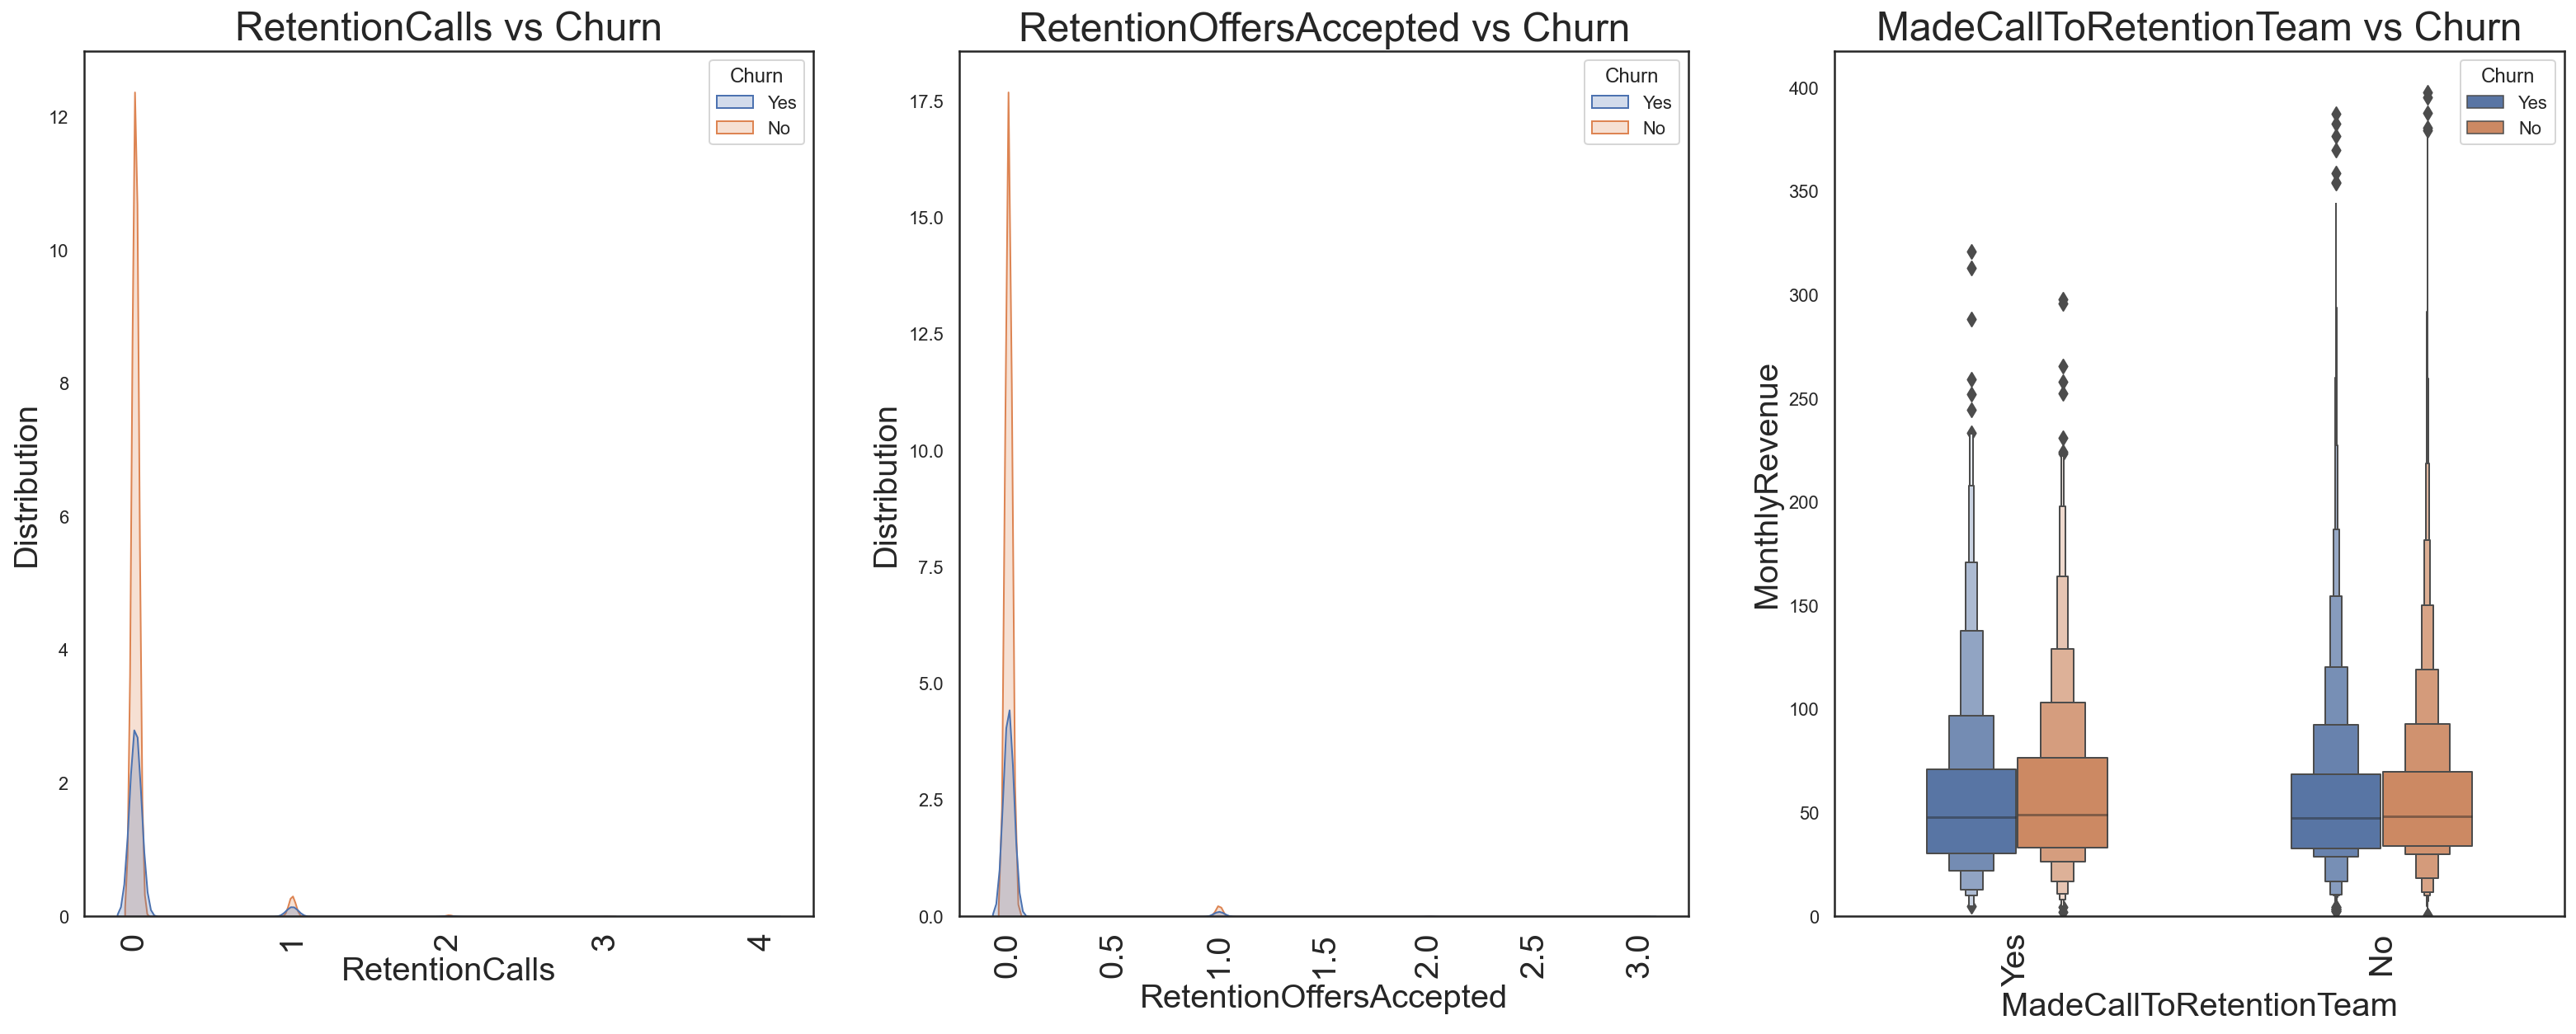

In [43]:
list_retention = [col for col in df_cust if 'Retention' in col]
print(f' Features in this list :' ,list_retention)
EDA_subplot(1,3,list_retention , df_cust)

<a id = 'section_2.9'><a/>
### 2.9 Credit cards and Credit Rating
___
[(back to top)](#content)
    
| Feature | Description | Column Value | Unit |
|---|---|---|---|
| HasCreditCard | Whether customer owns<br>a credit card | No<br>Yes | - |
| AdjustmentsToCreditRating | Number of time the credit rating<br>has ranged in past 1 year | Numeric:<br>Range 0 - 30 | Quantity |
| CreditRating | Credit rating of the customer | 1 - Highest<br>2 - High<br>3 - Good<br>4 - Medium<br>5 - Low<br>6 - VeryLow<br>7 - Lowest | - |    

 Features in this list : ['HasCreditCard', 'AdjustmentsToCreditRating', 'CreditRating']


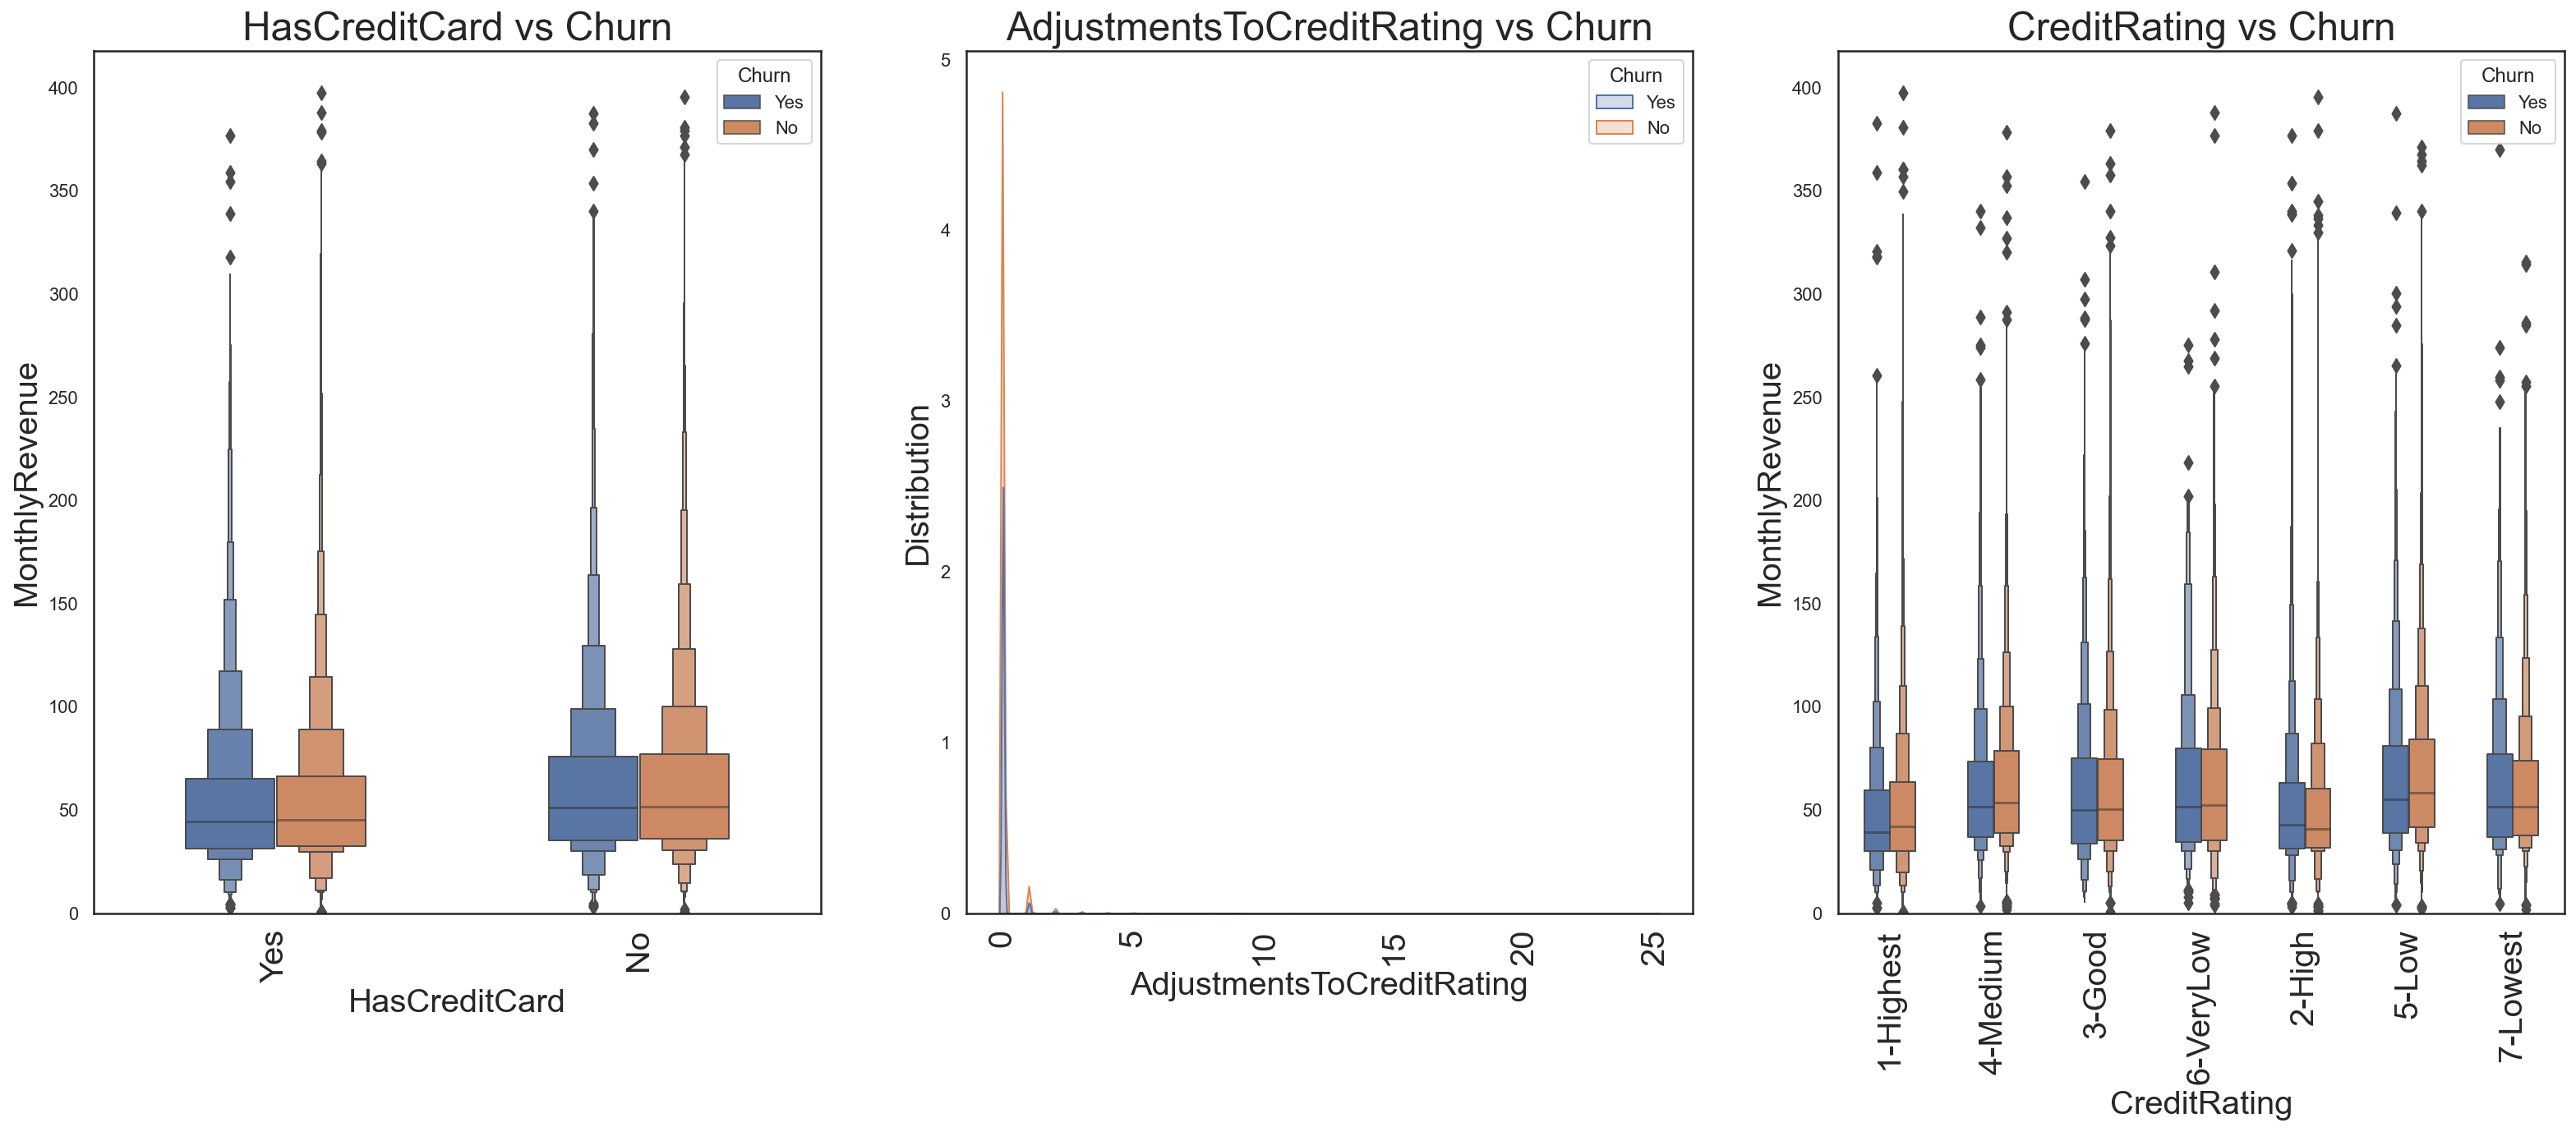

In [44]:
list_credit = [col for col in df_cust if 'Credit' in col]
print(f' Features in this list :' ,list_credit)
EDA_subplot(1,3,list_credit , df_cust)

<a id = 'section_2.10'><a/>
### 2.10 Higher Recurring Charges Churn more?
___
[(back to top)](#content)
    
| Feature | Description | Column Value | Unit |
|---|---|---|---|
| TotalRecurringCharge | Recurring charges in the past month | Numeric:<br>Range 0 - 6 | Quantity |    

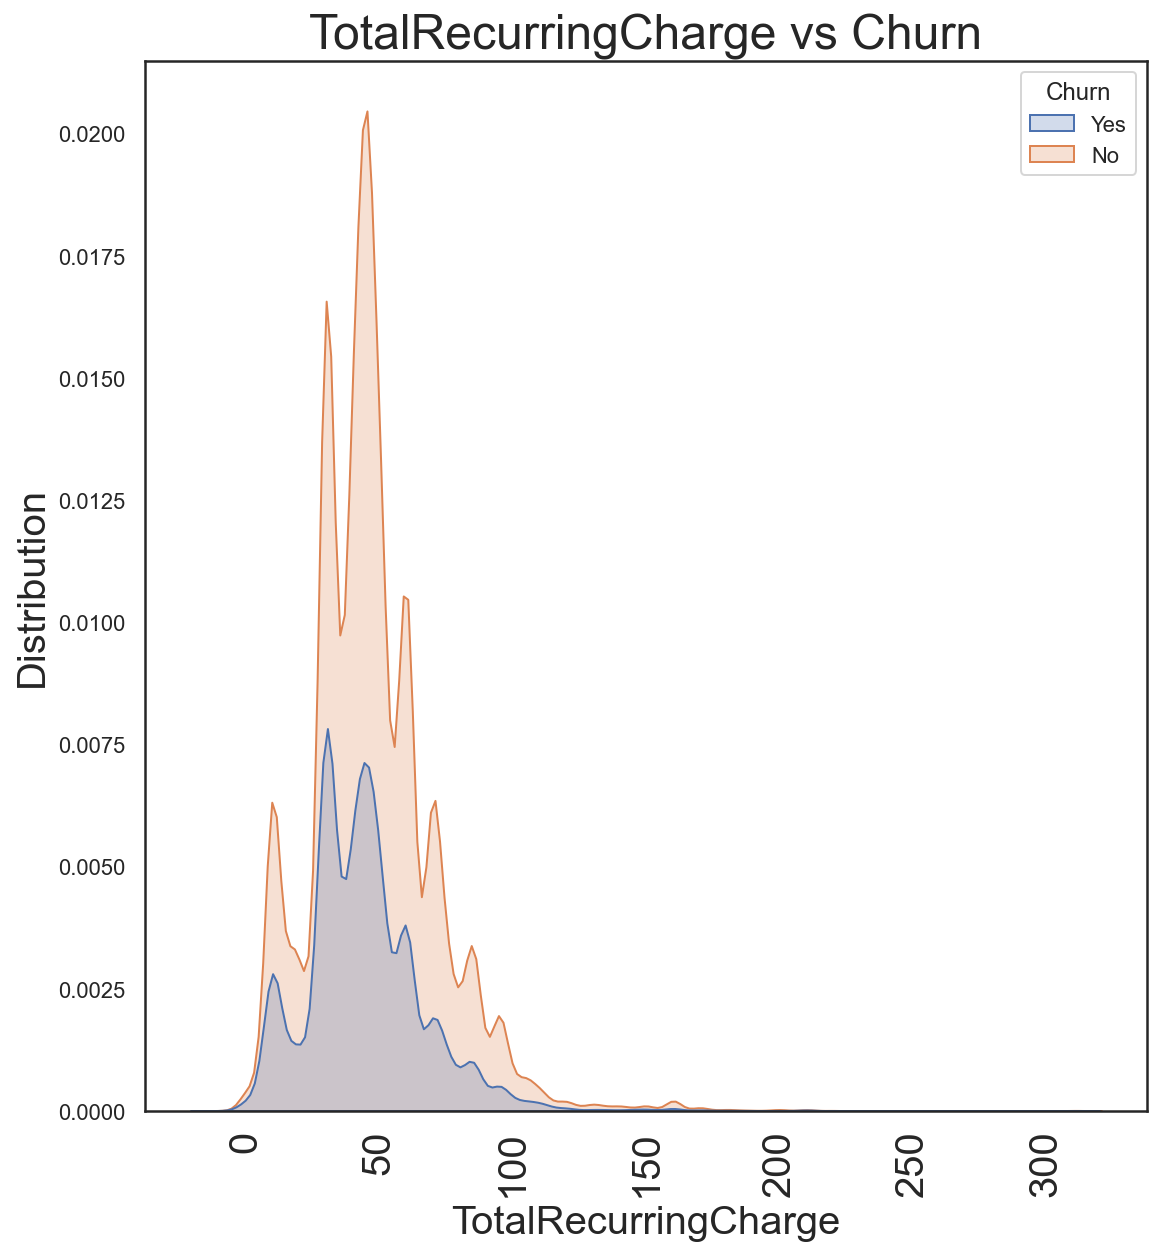

In [45]:
EDA_subplot(1,1, ['TotalRecurringCharge'] , df_cust)

<a id = 'section_3'><a/>
# 3.0. Feature Engineering
___
[(back to top)](#content)    

<a id = 'section_3.1'><a/>
### 3.1 Dummfying Ordinal and Categorical Features
___
[(back to top)](#content)        

In [46]:
# We will rate those ordinal features with more positive 
ordinal_dict = {'1-Highest' : 7 , '2-High' :6 , '3-Good' : 5 , '4-Medium' :4 , '5-Low' : 3 , '6-VeryLow' : 2 , '7-Lowest' : 1,
                'Known' : 1 , 'Unknown' : 0,
                'Yes' : 1 , 'No' : 0}


def ordinal_dummy(df):
    
    
    # Replacing ordinal categorical feature with pre-defined dictionary
    for col_name , data in df.items():
        if not pd.api.types.is_numeric_dtype(data):
            df.replace({col_name:ordinal_dict} , inplace = True)
            
    
    # For remaining Non Categorical Features , we will just parse it through the pd.get_dummies            
    for col_name , data in df.items():
        if not pd.api.types.is_numeric_dtype(data):
            df[col_name] = pd.Categorical(data).codes + 1
    
    return df            



In [47]:
df_cust = ordinal_dummy(df_cust)

<a id = 'section_3.2'><a/>
### 3.2 Creating New features
___
[(back to top)](#content)        

In [48]:
#wrapper function to create additional features for churn prediction
def create_features(df):
    
    #3.1 Percent of current active subs over total subs
#     df['perc_active_subs'] = df['ActiveSubs'] / df['UniqueSubs']

    perc_sub_list = []

    for rows in df[['ActiveSubs' , 'UniqueSubs']].itertuples():
        _ , active_sub , unique_sub = rows
        if unique_sub == 0:
            perc_sub = 0
            perc_sub_list.append(perc_sub)
        else:
            perc_sub = active_sub / unique_sub
            perc_sub_list.append(perc_sub) 
            
    df['perc_active_subs'] = perc_sub_list        
    
    #3.2 Percent of recurrent charge to monthly charge
    df['perc_recurrent_charge']= df['TotalRecurringCharge'] / df['MonthlyRevenue']
    
    #3.3 Percent of overage minutes over total monthly minutes
    
    # There are 0 for monthlyminutes , thus when dividing 0 with 0 , it will give inifinity.
    # To prevent this , for any rows with 0 monthly_minutes , we will set perc_overage_min as 0.
    perc_overage_list = []

    for rows in df[['OverageMinutes' , 'MonthlyMinutes']].itertuples():
        _ , overage_min , monthly_min = rows
        if monthly_min == 0:
            perc_overage = 0
            perc_overage_list.append(perc_overage)
        else:
            perc_overage = overage_min / monthly_min
            perc_overage_list.append(perc_overage) 
    
    df['perc_overage_min'] = perc_overage_list
    
    
    # Active Calls 
    df['active_calls'] = df[['DirectorAssistedCalls',
                             'RoamingCalls' , 
                             'ThreewayCalls' ,  
                             'ReceivedCalls',
                             'OutboundCalls',
                             'InboundCalls',
                             'PeakCallsInOut',
                             'OffPeakCallsInOut']].sum(axis = 1)
    
    df['inactive_calls'] = df[['DroppedCalls',
                               'BlockedCalls' , 
                               'UnansweredCalls' , 
                               'CustomerCareCalls' ,  
                               'DroppedBlockedCalls',
                               'CallForwardingCalls',
                               'CallWaitingCalls']].sum(axis = 1)
      
    return df


In [49]:
#Make a call to the feature engineering wrapper function for churn prediction
df_cust=create_features(df_cust)

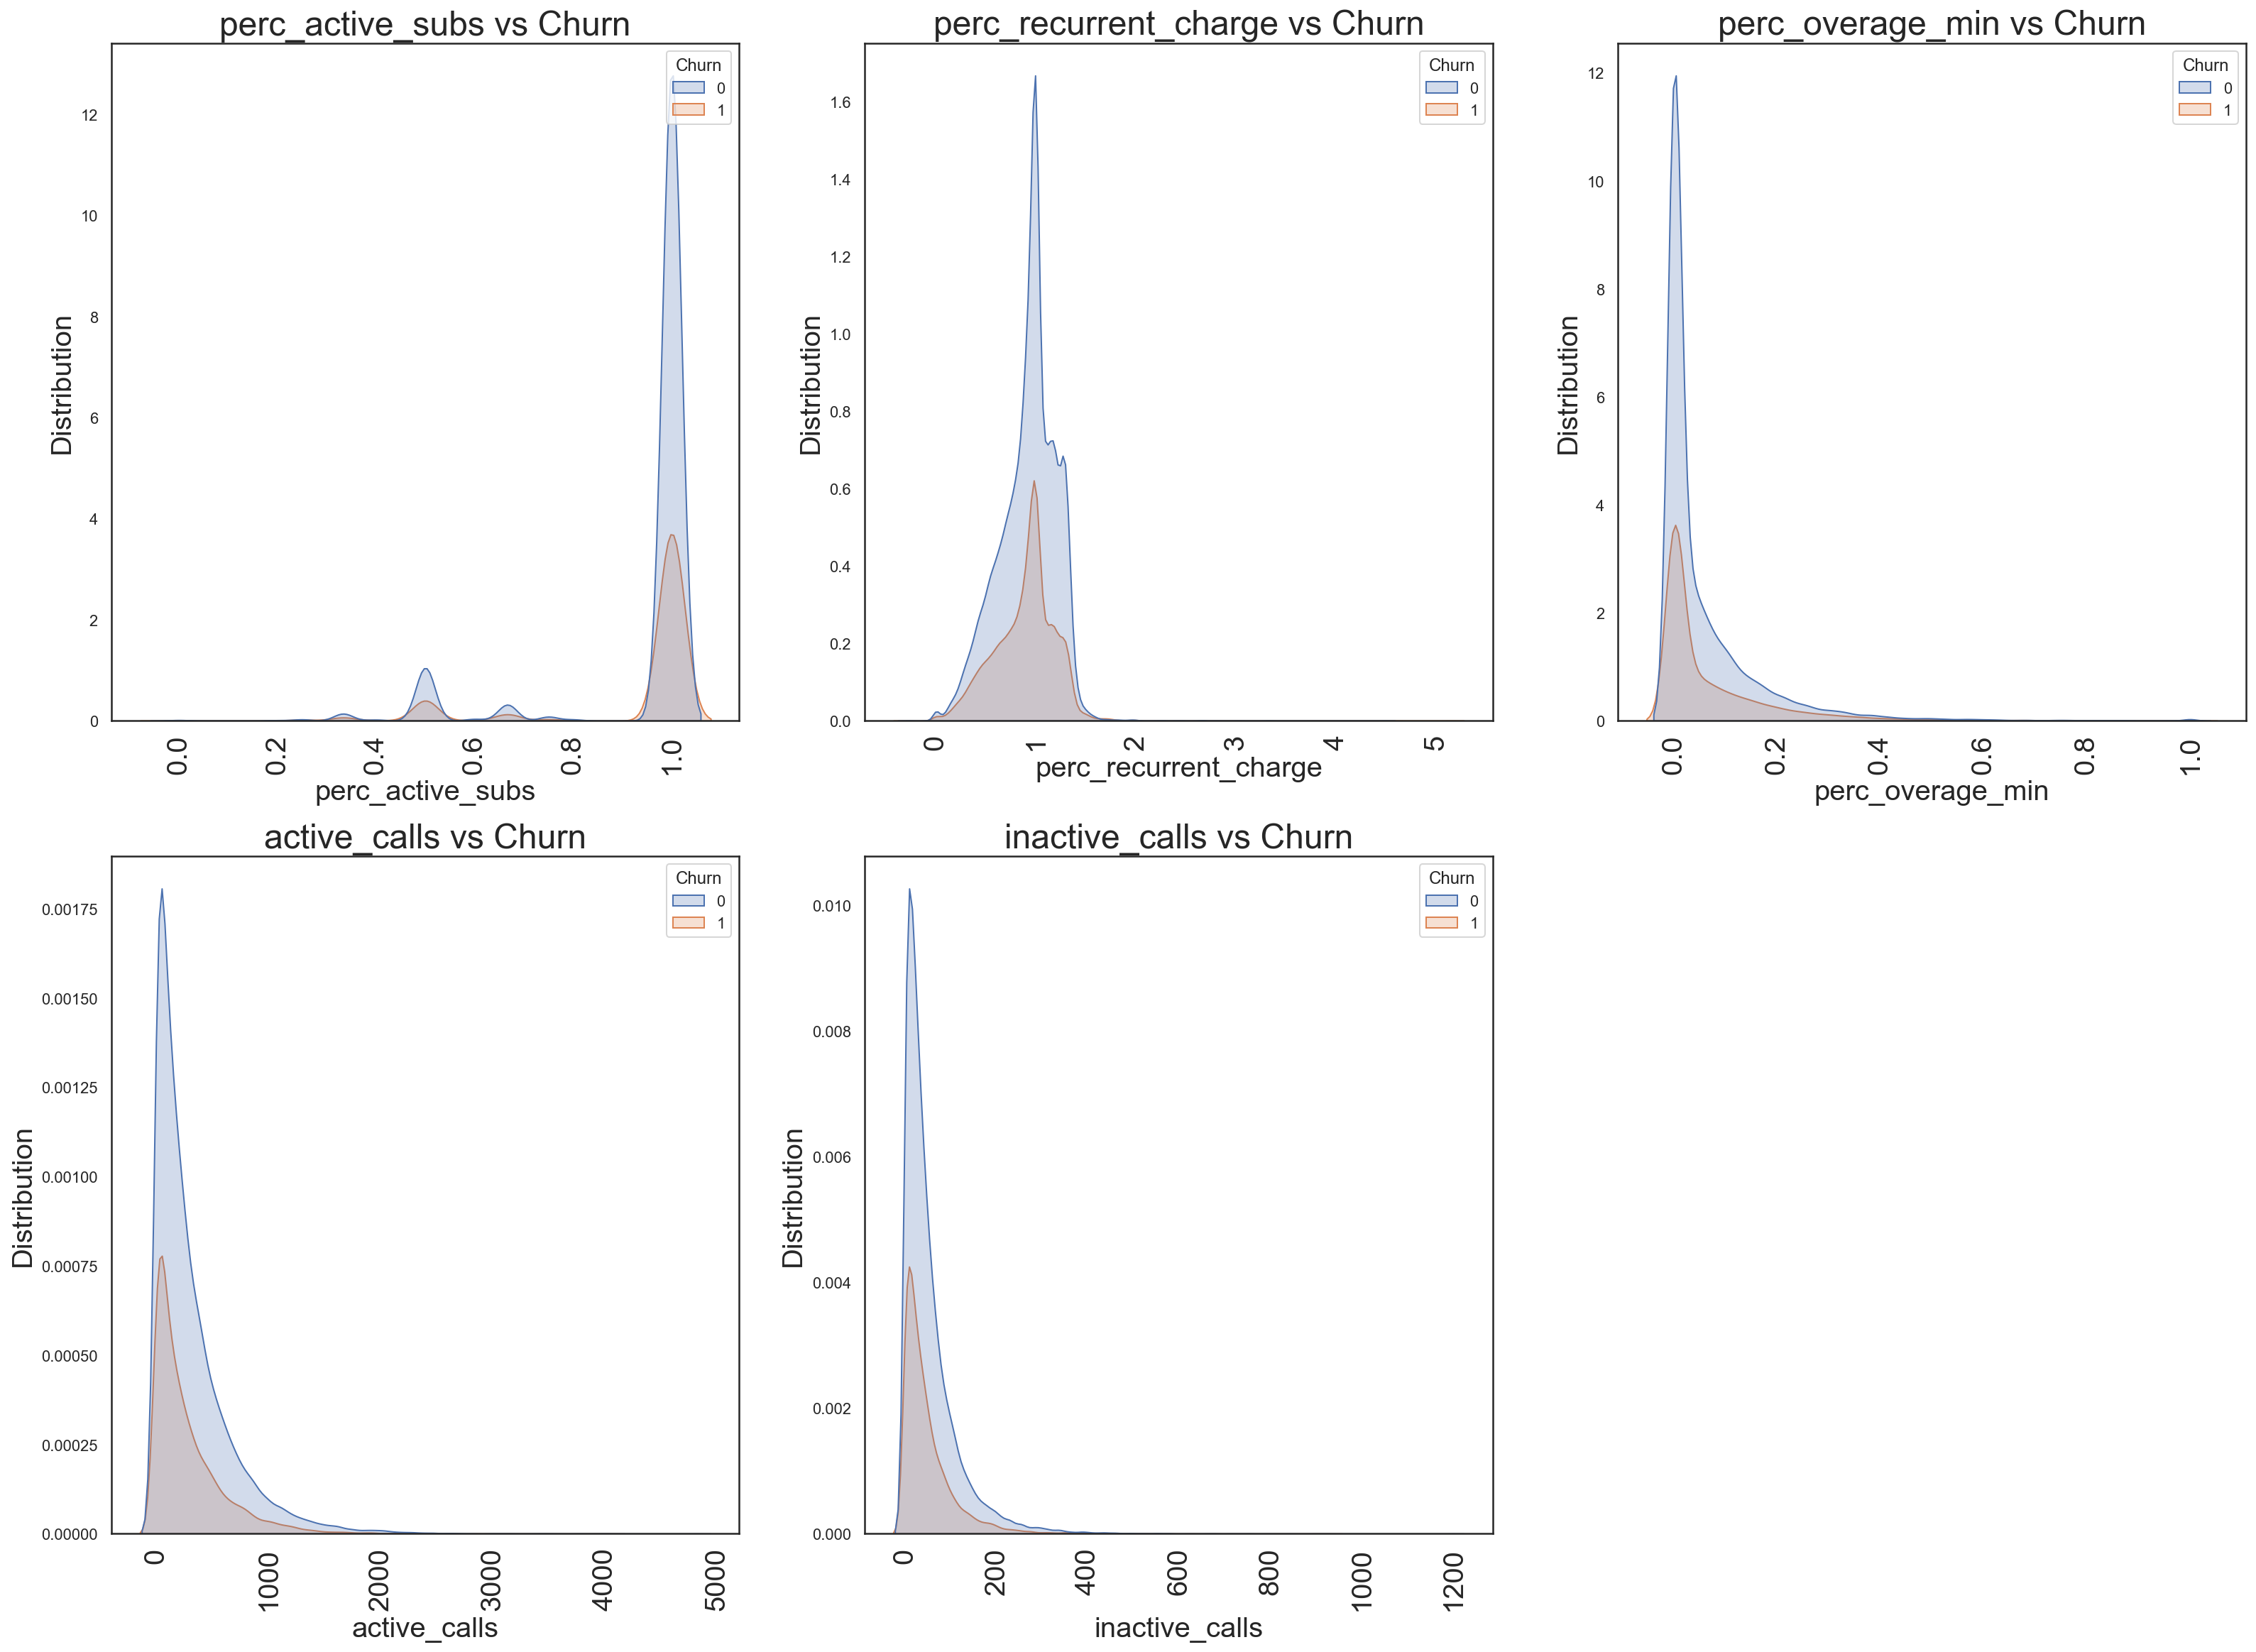

In [50]:
new_features = ['perc_active_subs' , 'perc_recurrent_charge' , 'perc_overage_min' , 'active_calls' , 'inactive_calls']
EDA_subplot(2,3, new_features , df_cust)

In [51]:
# from sklearn.feature_selection import RFECV 

# X = df_cust.drop('Churn' , axis = 1)
# y = df_cust['Churn']

# selector = RFECV(RandomForestClassifier(),step=1 , min_features_to_select = 40)
# selector = selector.fit(X, y)

<a id = 'section_4'><a/>
# 4.0 Modelling With Logistic Regression & RandomForest Classifier
___
[(`back to top`)](#content)

In [52]:
# We Have Imbalance Data , need to SMOTE before that.
print(f' No Churn % : {df_cust["Churn"].value_counts(normalize=True)[0]*100}')
print(f' Churn % : {df_cust["Churn"].value_counts(normalize=True)[1]*100}')

 No Churn % : 71.18259450206024
 Churn % : 28.817405497939763


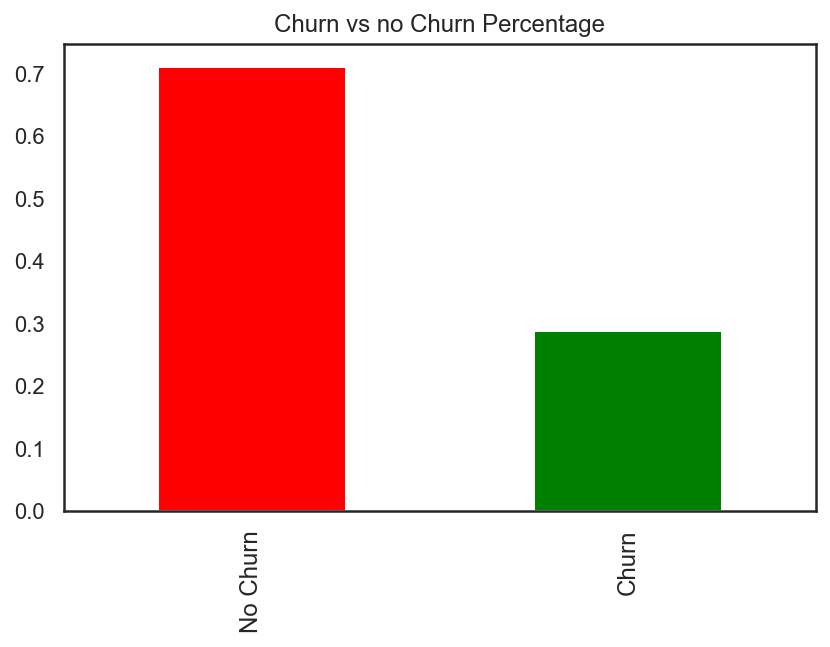

In [53]:
ax = df_cust["Churn"].value_counts(normalize=True).plot(kind = 'bar' , color = ['red' , 'green'])
ax.set_xticklabels(['No Churn' , 'Churn'],fontsize=12);
ax.set_title('Churn vs no Churn Percentage');

<a id = 'section_4.1'><a/>
### 4.1 Baseline Model Without SMOTE  [(`back to top`)](#content)
___
    
* We will split `10% testing data` to further score our trained model `as the hold out data csv provided` do not have any label.
* We will further split the remaining 90% data into train and validation.
* In this section , we will create baseline model to explore the metrics without SMOTE.
* We observed that it is predicting badly on the Churn section , which is as expected , since the majority in No Churn at 70%    

In [54]:
# Splitting data into 10% Hold Out Data and 90% Main Data for Train and Val

from imblearn.combine import SMOTETomek , SMOTEENN

to_drop_list = ['Churn', 'CustomerID' , 'CurrentEquipmentDays']

#Define columns to be included in X and y
X = df_cust.drop(to_drop_list , axis = 1)
y = df_cust['Churn']

# Pre splitting for 10% Hold Out Test Data
X_main , X_test , y_main , y_test = train_test_split(X , y , test_size=0.10 , stratify = y , random_state = 4)

print('Dataframe Data Size :', X.shape)
print('Main (Train and Val) Data Size :', X_main.shape)
print('Hold Out Test Data Size :' , X_test.shape)

# Train and Val Split on Remaining 90% of data
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.2, stratify=y_main , random_state=4)

#Feature scaling for all continuous variable
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)

Dataframe Data Size : (50237, 58)
Main (Train and Val) Data Size : (45213, 58)
Hold Out Test Data Size : (5024, 58)


#### 4.1.1 Baseline Model for Logistic Regression with No SMOTE
___
* We observed that it is predicting badly on the Churn section , which is as expected , since the majority in `No Churn` at 70%    

In [55]:
# Instantiate and Fit
model_lr_noSM = LogisticRegression(random_state = 42)

model_lr_noSM.fit(X_train_scaled , y_train)

# Predict Value
model_lr_noSM_pred = model_lr_noSM.predict(X_val_scaled)
model_lr_noSM_proba = model_lr_noSM.predict_proba(X_val_scaled)

# Evaluate Metrics
model_lr_noSM_score = eval_classification(y_true = y_val , 
                                     y_pred = model_lr_noSM_pred,
                                     y_proba = model_lr_noSM_proba[: , 1])
model_lr_noSM_score

LogisticRegression(random_state=42)

{'Accuracy': 0.7116001326993254,
 'Precision': 0.4918032786885246,
 'Recall': 0.023023791250959325,
 'F1 Score': 0.0439882697947214,
 'AUC Score': 0.6155065609638063,
 'Gini Score': 0.23101312192761259}

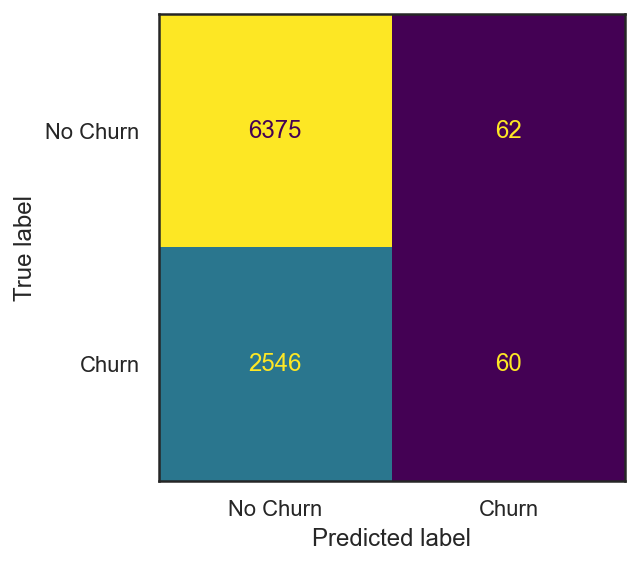

In [56]:
plot_confusion_matrix(model_lr_noSM , 
                      X_val_scaled ,
                      y_val,
                      colorbar = False,
                      display_labels = ['No Churn' , 'Churn']);

#### 4.1.2 Baseline Model for RFC with No SMOTE
___

* We observed that it is predicting badly on the Churn section , which is as expected , since the majority in `No Churn` at 70%    

In [57]:
# Instantiate and Fit
model_rfc_noSM = RandomForestClassifier(random_state = 42)

model_rfc_noSM.fit(X_train_scaled , y_train)

# Predict Value
model_rfc_noSM_pred = model_rfc_noSM.predict(X_val_scaled)
model_rfc_noSM_proba = model_rfc_noSM.predict_proba(X_val_scaled)

# Evaluate Metrics
model_rfc_noSM_score = eval_classification(y_true = y_val , 
                                     y_pred = model_rfc_noSM_pred,
                                     y_proba = model_rfc_noSM_proba[: , 1])
model_rfc_noSM_score

RandomForestClassifier(random_state=42)

{'Accuracy': 0.7213314165652991,
 'Precision': 0.6472602739726028,
 'Recall': 0.07252494244052188,
 'F1 Score': 0.13043478260869565,
 'AUC Score': 0.6603342795530109,
 'Gini Score': 0.3206685591060219}

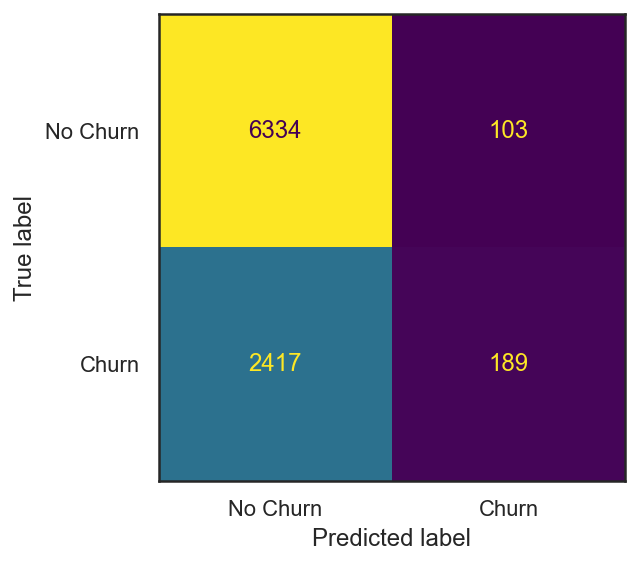

In [58]:
plot_confusion_matrix(model_rfc_noSM , 
                      X_val_scaled ,
                      y_val,
                      colorbar = False,
                      display_labels = ['No Churn' , 'Churn']);

<a id = 'section_4.2'><a/>
### 4.2 Preprocessing with SMOTE , Standard Scalar  [(`back to top`)](#content)
___
    
* We will split main data into train and validation
* We will SMOTE on the `train data only` to prevent data leakage on test.
* We will `fit_ transform` on train data only
* We will `only transform` validation & test data (Later section)    

In [59]:
# Splitting Main Data into Train and Val

# Train and Val Split on Remaining 90% of data
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.2, stratify = y_main ,  random_state=4)

# SMOTE on Train and Val from X_main and y_main
smote = SMOTE(random_state = 4 , n_jobs=-1 , k_neighbors = 3)

print('Churn Distribution before SMOTE :' ,np.bincount(y_train))

X_train , y_train = smote.fit_resample(np.array(X_train), 
                                           np.array(y_train))

print('Churn Distribution after SMOTE :' ,np.bincount(y_train))

#Feature scaling for all continuous variable
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)

print(f'X_train Shape : {X_train_scaled.shape}')
print(f'X_val Shape : {X_val_scaled.shape}')
print(f'y_train Shape : {y_train.shape}')
print(f'y_val Shape : {y_val.shape}')

Churn Distribution before SMOTE : [25747 10423]
Churn Distribution after SMOTE : [25747 25747]
X_train Shape : (51494, 58)
X_val Shape : (9043, 58)
y_train Shape : (51494,)
y_val Shape : (9043,)


<a id = 'section_4.3'><a/>
### 4.3 Modelling with Logistic Regression  [(`back to top`)](#content)
___   

In [60]:
# #Grid Search CV For Logistic Regression (Commented Out)

# # Uncomment to run

# lr_param_grid = {'penalty' : ['l2'],
#                 'C' : np.linspace(0.001 , 0.4 , 10),
#                 'solver' : ['newton-cg', 'sag']}

# lr_GS = GridSearchCV(estimator = LogisticRegression(random_state = 42),
#                      param_grid = lr_param_grid,
#                      cv = 5)

# lr_GS.fit(X_train_scaled , y_train)

# model_lr_gs_pred = lr_GS.predict(X_val_scaled)
# model_lr_gs_proba = lr_GS.predict_proba(X_val_scaled)

# model_lr_gs_score = eval_classification(y_true = y_val , 
#                                         y_pred = model_lr_gs_pred,
#                                         y_proba = model_lr_gs_proba[: , 1])
# model_lr_gs_score

In [61]:
# lr_GS.best_params_

In [62]:
# Params extracted from previously run GridSearchCV
model_lr = LogisticRegression(random_state= 42 , C =  0.012)

model_lr.fit(X_train_scaled , y_train)

LogisticRegression(C=0.012, random_state=42)

#### 4.3.1 Evaluating Results for Logistic Regression
___

In [63]:
model_lr_pred = model_lr.predict(X_val_scaled)
model_lr_proba = model_lr.predict_proba(X_val_scaled)

In [64]:
model_lr_score = eval_classification(y_true = y_val , 
                                     y_pred = model_lr_pred,
                                     y_proba = model_lr_proba[: , 1])
model_lr_score

{'Accuracy': 0.5906225810018799,
 'Precision': 0.3649581074420897,
 'Recall': 0.5683039140445126,
 'F1 Score': 0.44447779111644653,
 'AUC Score': 0.6148759730505635,
 'Gini Score': 0.22975194610112704}

In [65]:
model_lr_proba[: , 1]

array([0.49245659, 0.50284541, 0.72705875, ..., 0.3970409 , 0.52453651,
       0.47912859])

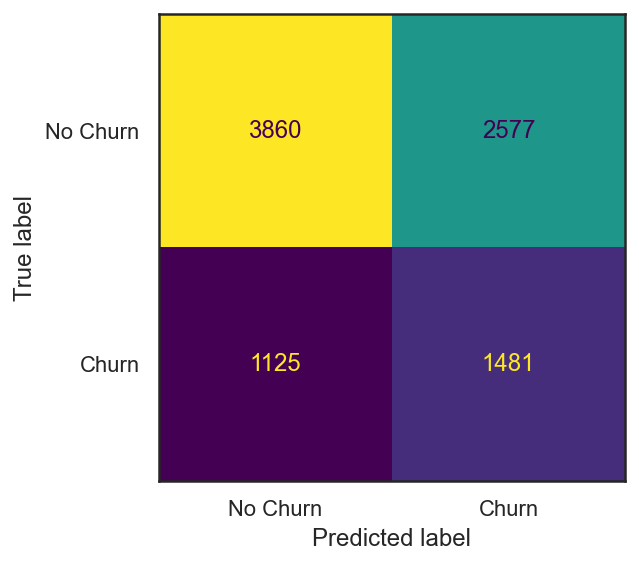

In [66]:
plot_confusion_matrix(model_lr , 
                      X_val_scaled ,
                      y_val,
                      colorbar = False,
                      display_labels = ['No Churn' , 'Churn']);

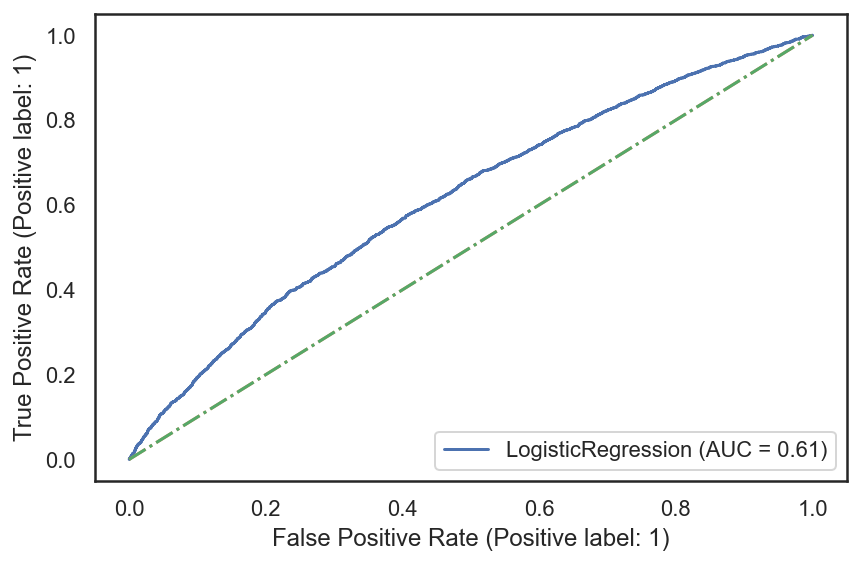

In [67]:
lr_plot = plot_roc_curve(model_lr , X_val_scaled , y_val)
plt.plot([[0,0] , [1,1]] , 
         linestyle = '-.',
         label = 'baseline');

<a id = 'section_4.4'><a/>
### 4.4 Modelling with Random Forest Classifier  [(`back to top`)](#content)
___
* Oversampling does not help RFC. We could try other undersampling technique or combine technique like SMOTEENN to observe if model perform better. (It do perform better with undersampling)    

In [68]:
# %%time

# rfc_param_grid = {'min_samples_split' : np.arange(6 , 10 , 2),
#                  'min_samples_leaf' : np.arange(2, 3 , 1),
#                  'n_estimators' : np.arange(100 , 200 , 10),
#                  'max_features' : ['sqrt' , 'auto'],
#                  'max_depth' : [None]}

# rfc_GS = GridSearchCV(estimator = RandomForestClassifier(random_state = 42),
#                      param_grid = rfc_param_grid,
#                      cv = 5,
#                      n_jobs = -1)

# rfc_GS.fit(X_train_scaled , y_train)

In [69]:
# rfc_GS.best_params_

In [70]:
model_rfc = RandomForestClassifier(random_state=42)

model_rfc.fit(X_train_scaled , y_train)

RandomForestClassifier(random_state=42)

In [71]:
rfc_pred = model_rfc.predict(X_val_scaled)
rfc_proba = model_rfc.predict_proba(X_val_scaled)

In [72]:
model_rfc_score = eval_classification(y_true = y_val,
                                      y_pred = rfc_pred,
                                      y_proba = rfc_proba[:,-1])


model_rfc_score

{'Accuracy': 0.7152493641490656,
 'Precision': 0.5388471177944862,
 'Recall': 0.08250191864927091,
 'F1 Score': 0.14309484193011646,
 'AUC Score': 0.6438891870208816,
 'Gini Score': 0.2877783740417632}

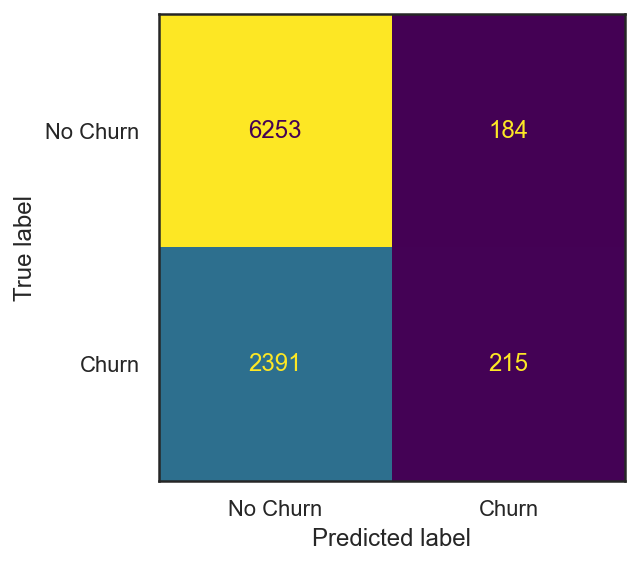

In [73]:
plot_confusion_matrix(model_rfc , 
                      X_val_scaled ,
                      y_val,
                      colorbar = False,
                      display_labels = ['No Churn' , 'Churn']);

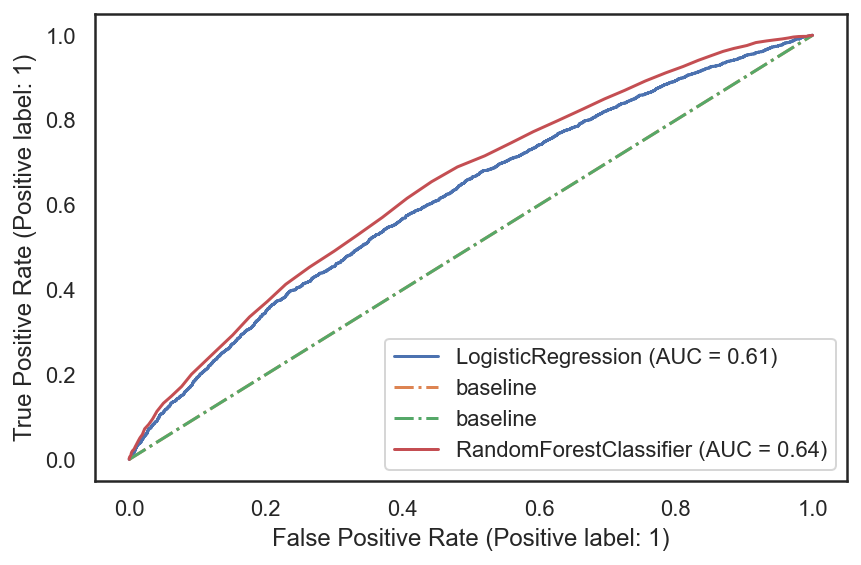

In [74]:
rfc_plot = plot_roc_curve(model_rfc , X_val_scaled , y_val , ax = lr_plot.ax_)
rfc_plot.figure_

<a id = 'section_4.5'><a/>
### 4.5 Results Summary  [(`back to top`)](#content)
___

<mark>__Result:__
    
Logistic Regression Performed generally much better than RFC in the area of F1 Score and Recall

In [75]:
df_score = pd.DataFrame({'Log Reg (No SMOTE)' : model_lr_noSM_score,
                         'Logistic Regression' : model_lr_score,
                         'Random Forest (No SMOTE)' : model_rfc_noSM_score,
                         'Random Forest Classifier' : model_rfc_score})

df_score

Log Reg (No SMOTE)  Logistic Regression  Random Forest (No SMOTE)  \
Accuracy              0.711600             0.590623                  0.721331   
Precision             0.491803             0.364958                  0.647260   
Recall                0.023024             0.568304                  0.072525   
F1 Score              0.043988             0.444478                  0.130435   
AUC Score             0.615507             0.614876                  0.660334   
Gini Score            0.231013             0.229752                  0.320669   

            Random Forest Classifier  
Accuracy                    0.715249  
Precision                   0.538847  
Recall                      0.082502  
F1 Score                    0.143095  
AUC Score                   0.643889  
Gini Score                  0.287778

<a id = 'section_4.6'><a/>
### 4.6 Identifying Feature Importances  [(`back to top`)](#content)
___

#### 4.6.1 Top 20 Features from Logistic Regression
___

In [76]:
df_feature_importance_LR = pd.DataFrame(index= X.columns,
                                        data = {'coeff' :model_lr.coef_[0],
                                                'score' : np.exp(model_lr.coef_[0])}).sort_values(by = 'score' , 
                                                                                           ascending = False)

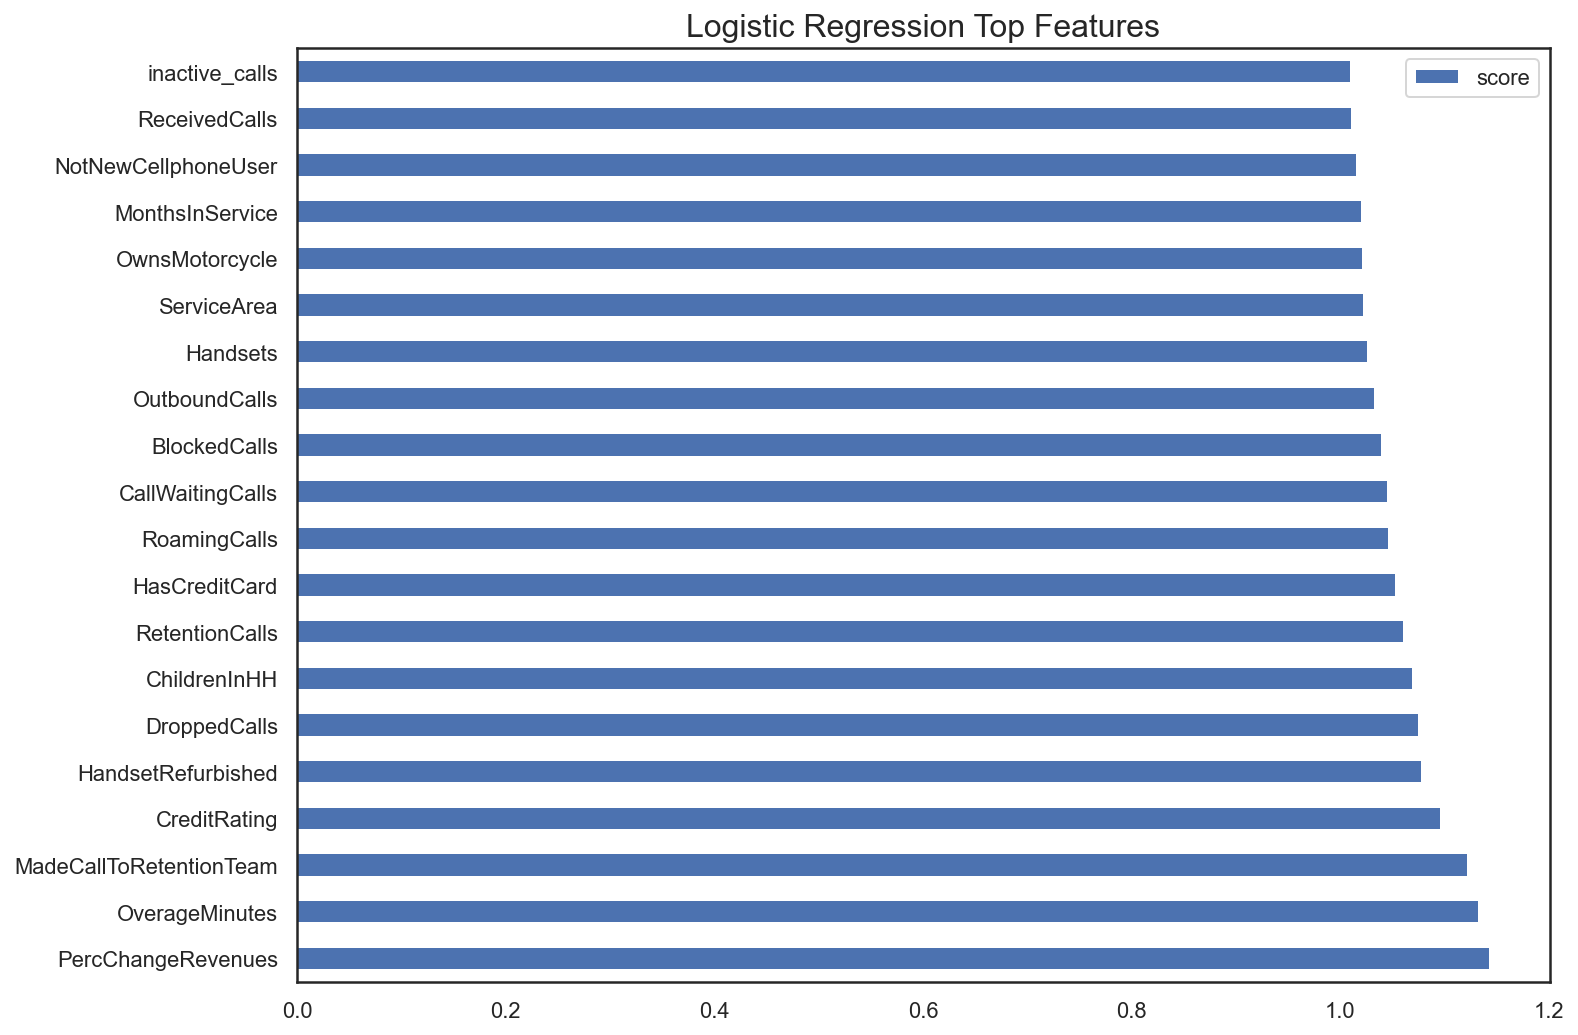

In [77]:
df_feature_importance_LR.drop('coeff' , axis = 1).head(20).plot(kind = 'barh' , figsize = (10,8))
plt.title('Logistic Regression Top Features' , fontsize = 16);

#### 4.6.2 Top 20 Features from RandomForest Classifier
___

In [78]:
df_feature_importance_RFC = pd.DataFrame(index= X.columns,
                                         data = {'feature' : model_rfc.feature_importances_}).sort_values(by = 'feature' , 
                                                                                                          ascending = False)

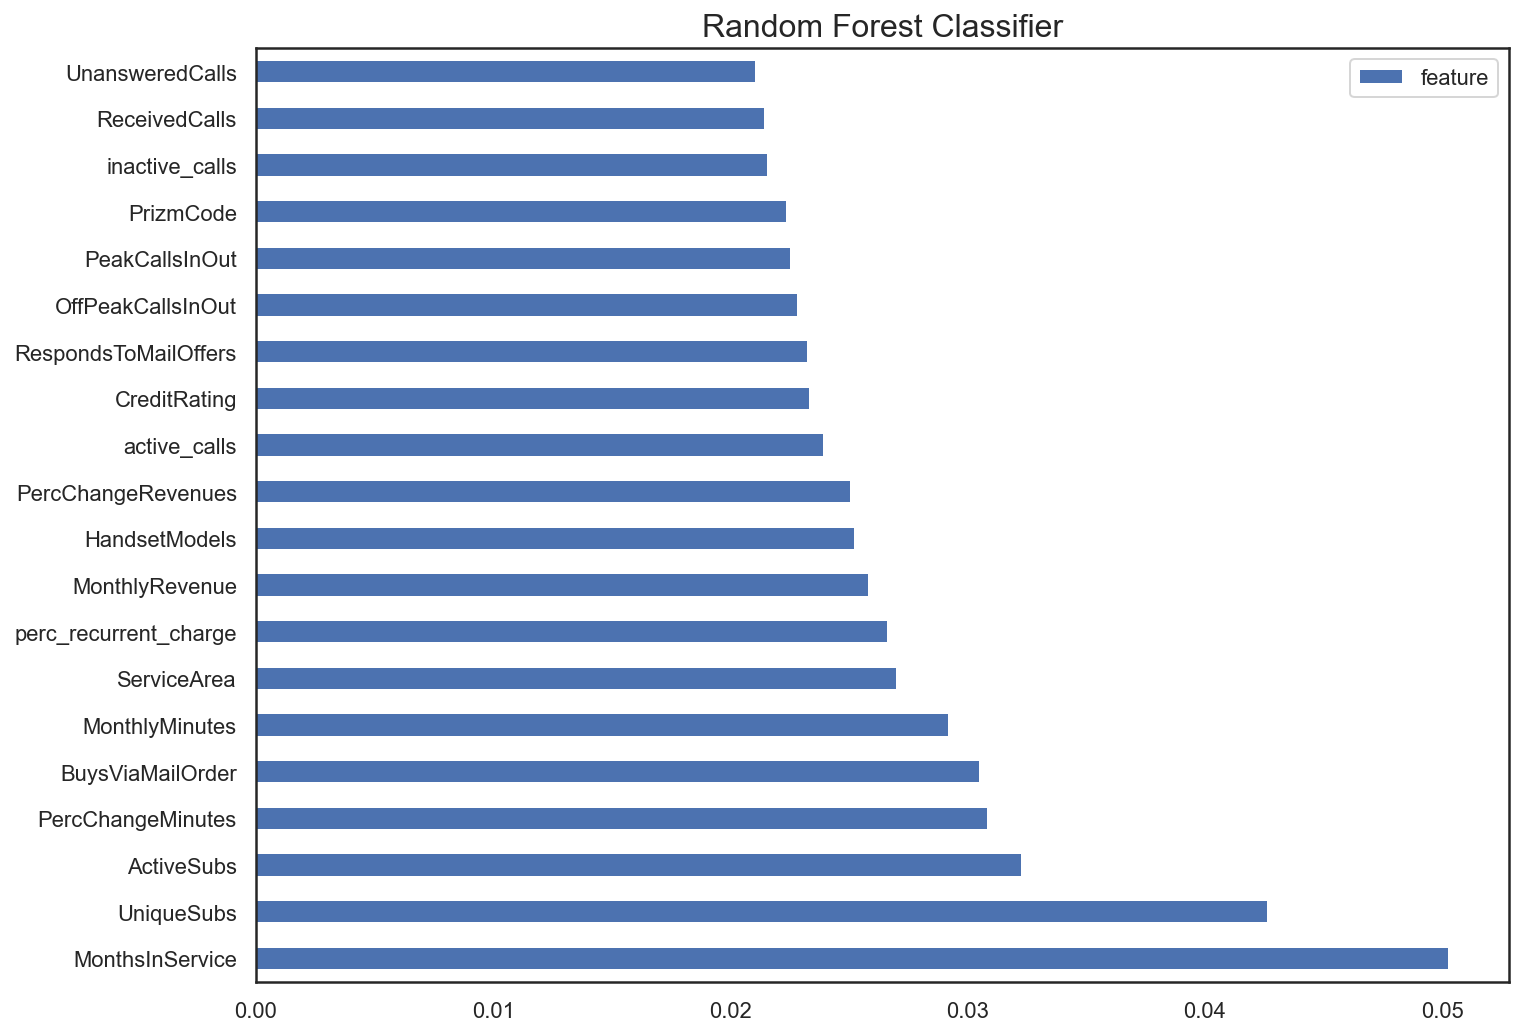

In [79]:
df_feature_importance_RFC.head(20).plot(kind = 'barh' , figsize = (10,8))
plt.title('Random Forest Classifier' , fontsize = 16);

<a id = 'section_5'><a/>
# 5.0 Generating Test Prediction  
___
[(`back to top`)](#content)    

<a id = 'section_5.1'><a/>
### 5.1 Predicting on Pre-split Test Data [(`back to top`)](#content)
___

In [80]:
# X_hold , y_hold = smote_enn.fit_resample(np.array(X_hold), 
#                                          np.array(y_hold))

X_test_scaled = sc.transform(X_test)
X_test_pred = model_lr.predict(X_test_scaled)
X_test_proba = model_lr.predict_proba(X_test_scaled)

In [81]:
model_test_score = eval_classification(y_true = y_test,
                                        y_pred = X_test_pred,
                                        y_proba = X_test_proba[:,-1])


model_test_score
#Evaluate model accuracy using fitted y value and actual y_test
#Evaluatio metrics to be used - GINI, Precision, Recall, confusion matrix

{'Accuracy': 0.5917595541401274,
 'Precision': 0.3612517257248044,
 'Recall': 0.5421270718232044,
 'F1 Score': 0.4335818834576084,
 'AUC Score': 0.6037846694352775,
 'Gini Score': 0.20756933887055506}

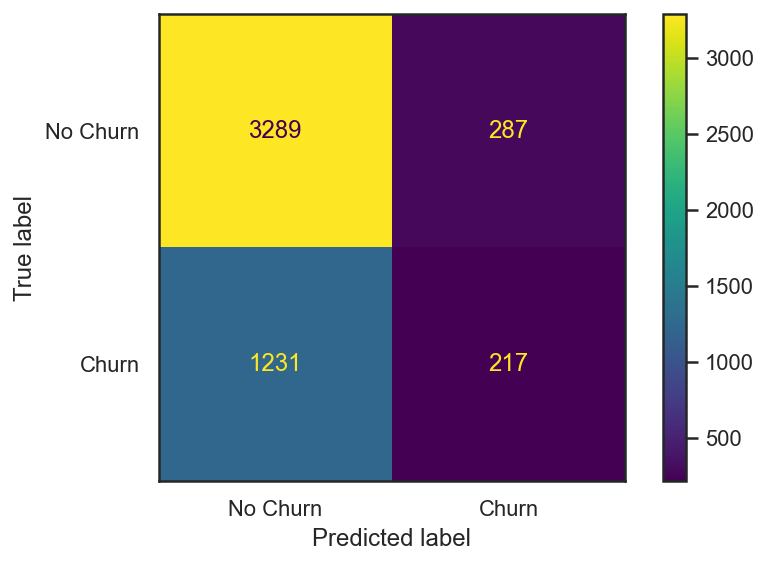

In [82]:
plot_confusion_matrix(model_lr,
                      X = X_test,
                      y_true = y_test,
                      display_labels = ['No Churn' , 'Churn']);

<a id = 'section_5.2'><a/>
### 5.2 Predicting on Seperate Hold Out Data (No labels) [(`back to top`)](#content)
___
* Read in Hold Out CSV.
* Preprocess Hold Out data, as per how it was preprocess for earlier dataset.
* Use previous best model to generate prediction.
* Since csv do not have labels , therefore score cannot be generated.

In [83]:
#Type your code here to predict churners based on the hold out data set provided
#Note #1: use "create_features(cust_df)" functions to create the additional list of features in the hold out data set
#Note #2: Also, perform feature scaling and dummy variables creation as performed during the initial stages of step #4

#Use "predict" function on the transformend data using the best fitted model object

def preprocess_df(df):
    
    # Impute Missing Value    
    df= df[~df['ServiceArea'].isna()]
    
    for col , data in df.items():
        if pd.api.types.is_numeric_dtype(data):
            # Fill Nan Value in Numeric columns with Median Values
            df[col].fillna(value = df[col].median() , inplace = True)

    # Remove Outlier      
    df = df.loc[df['MonthlyRevenue']!=0]
    df = df.loc[df["UniqueSubs"] <= np.quantile(a = df["UniqueSubs"], q = 0.99)]
    df = df.loc[df["DirectorAssistedCalls"] <= np.quantile(a = df["DirectorAssistedCalls"], q = 0.99)]
    
    # Remove Marital Status and HandSetPrice Column   
    df.drop('HandsetPrice' , inplace = True , axis = 1)
    df.drop('MaritalStatus' , inplace = True , axis = 1)
    
    # Create New Feature
    df = create_features(df)
    
    # Dummified the column
    df = ordinal_dummy(df)
    
    # Drop Columns Before StandardScalar
    
    list_customer_id = df['CustomerID'].to_list()
    df = df.drop(to_drop_list , axis = 1)
    
    return df , list_customer_id

In [84]:
# Read in Test CSV
df_hold_out = pd.read_csv('Dataset/Mini_project_3_Hold_Out_Data.xls')

In [85]:
df_hold_out , hold_out_customer_id = preprocess_df(df_hold_out)

In [86]:
print(' No. of Data Rows in DF_test:', len(df_hold_out))
print(' Check No. of Null Rows:', df_hold_out.isnull().sum().sum())
print(' Shape for DF Test:', df_hold_out.shape)
print(' Shape for DF Val:', X_val_scaled.shape) # Double Check the columns shape are the same

 No. of Data Rows in DF_test: 19704
 Check No. of Null Rows: 0
 Shape for DF Test: (19704, 58)
 Shape for DF Val: (9043, 58)


In [87]:
# Dropping Rows and SS
X_hold_out = df_hold_out
X_hold_out_scaled = sc.transform(X_hold_out)

In [88]:
X_hold_out_pred = model_lr.predict(X_hold_out_scaled)
df_hold_out['Churn'] = X_hold_out_pred
df_hold_out['CustomerID'] = hold_out_customer_id

In [89]:
df_prediction = df_hold_out[['CustomerID' , 'Churn']]
df_prediction['Churn'].value_counts(normalize = True)

0    0.558516
1    0.441484
Name: Churn, dtype: float64

<a id = 'section_6'><a/>
# 6.0 Whats could be done next to improve score?
___
[(`back to top`)](#content)    

* Use other classification technique like XGBoost
* Try other SMOTE Technique like undersampling or combined under and over sample.
* Use Hyperparameter tuning to improve model.
* Remove more outliers before parsing through model.
* Focus on top features and do a polynomial transform.
* Collect data for more distinct features that are better able to differentiate between churn and no churn.    

<a id = 'section_7'><a/>
# 7.0 Bonus Question
___
[(`back to top`)](#content)    

*Calculate lift chart and total monthly revenue saved by targeting top 10-20% of the customers using your best predictive model

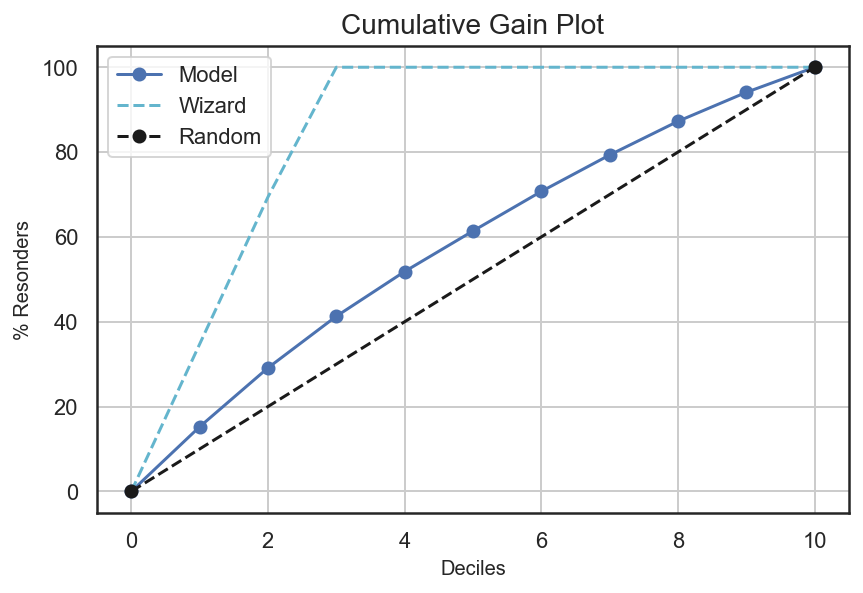

In [90]:
#Cumulative Gains Chart for our best linear regression model

!pip install kds
import kds

kds.metrics.plot_cumulative_gain(y_val , model_lr_proba[: , 1])


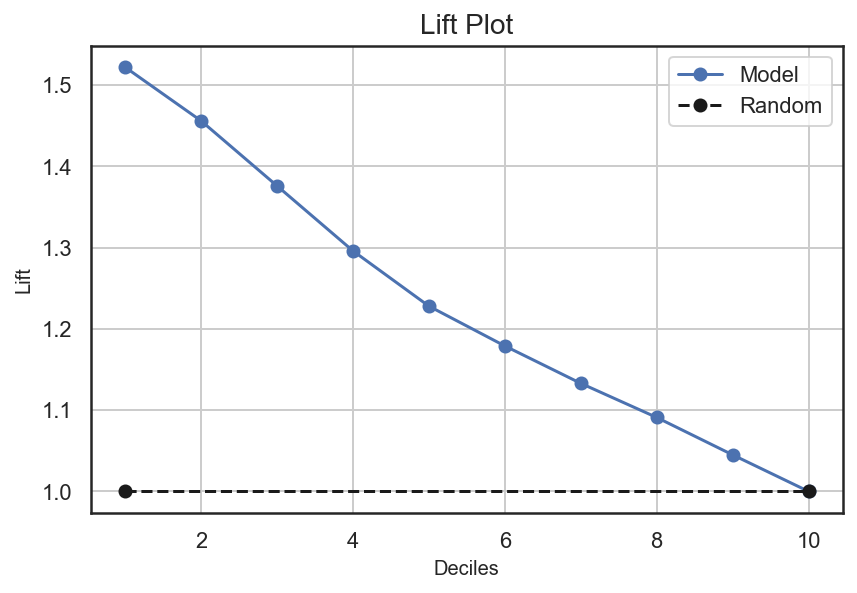

In [91]:
#Lift Chart for our best linear regression model

kds.metrics.plot_lift(y_val , model_lr_proba[: , 1])


In [92]:
#Create df with Monthly Revenue, actual Churn flag and the churn probability from model
df_bonus = pd.DataFrame()
df_bonus['MonthlyRevenue'] = X_val['MonthlyRevenue']
df_bonus['Churn'] = y_val
df_bonus['Churn_Proba'] = model_lr_proba[: , 1]

#Identify the 80th percentile for churn probability
_80_percentile_proba = df_bonus['Churn_Proba'].quantile(0.8)

#Locate actual churners within the the top 20% of churn probability
top_20_percent_churners = df_bonus.loc[(df_bonus['Churn'] == 1) & (df_bonus['Churn_Proba'] >= _80_percentile_proba)]

print('\033[1m' + 'Total Monthly Revenue of actual churners based on top 20% of churn probability' + '\033[0m')
print('USD$ ' + "{:.0f}".format(top_20_percent_churners['MonthlyRevenue'].sum()))

Total Monthly Revenue of actual churners based on top 20% of churn probability
USD$ 43914


<mark>__Result:__
    
1. What is the % actual churn captured by targeting top 20% (top 2 deciles) of the customers sorted by their churn probability? <br>
<b>By referencing the cumulative gains curve and lift chart, approximately 30% of the actual churn can be captured by targeting the top 20% of customers sorted by their churn probability, with a lift of 1.45X over random sampling.</b><br><br>
2. What is the total monthly revenue of actual churn customers identified in the top 20% of the customers?
<b>USD$ 43914</b>
   